In [3]:
import numpy
import numpy as np
import time
import datetime
import netCDF4
import matplotlib.pylab as plt
import os,sys,glob
sys.path.insert(0, os.getcwd() + "/../resort/rasotools-master/")
# sys.path.append(os.getcwd()+'/../adjust/rasotools/')
# from utils import *
from multiprocessing import Pool
#import odb
from eccodes import *
from functools import partial
from collections import OrderedDict
import subprocess
import json
import gzip
# from retrieve_fb_jra55 import add_feedback
import copy
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import scipy
from scipy import stats
import trajectory

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

In [3]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)

In [7]:
f = open(sodblist[-1])
output = {}

In [53]:
while 1:
#         try:
    # get handle for message
    bufr = codes_bufr_new_from_file(f)
    if bufr is None:
        break
    # we need to instruct ecCodes to expand all the descriptors
    # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
    if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
        codes_release(bufr)
        continue
    codes_set(bufr, 'unpack', 1)
    # get all the timePeriods
    iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

    # loop over the keys
    #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
        #codes_release(bufr)
        #continue
    hires=False
    while codes_bufr_keys_iterator_next(iterid):

#             print key name
        keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
        #if keyname in ['#1#blockNumber','#1#stationNumber']:
            #print (keyname,codes_get_array(bufr,keyname))
        if 'latitudeDisplacement' in keyname:
            hires=True
    if not hires:
        codes_bufr_keys_iterator_delete(iterid)
        codes_release(bufr)
        continue
    ## delete the key iterator
    codes_bufr_keys_iterator_delete(iterid)
    output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
    output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
    output['pressure'] = codes_get_array(bufr, "pressure")
    output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
    output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
    output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
    output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
    output['airTemperature'] = codes_get_array(bufr, "airTemperature")
    dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
    output['windDirection'] = codes_get_array(bufr, "windDirection")
    output['windSpeed'] = codes_get_array(bufr, "windSpeed")
    output['lat'] = codes_get(bufr, "latitude")
    output['lon'] = codes_get(bufr, "longitude")
    output['alt'] = float(codes_get(bufr, "heightOfStation"))
    output['blockNumber'] = codes_get(bufr, "blockNumber")
    output['stationNumber'] = codes_get(bufr, "stationNumber")
    try:
        data = pd.DataFrame.from_dict(output)
        if np.abs(np.max(data.longitudeDisplacement)) > 0.8 and np.abs(np.max(data.longitudeDisplacement)) < 2:
            cont = True
            break
    except:
        cont = False

In [54]:
data

datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
0     20200531.0    230400.0       0.0                                     0   
1     20200531.0    230400.0  101670.0                                     0   
2     20200531.0    230400.0  101620.0                                     0   
3     20200531.0    230400.0  101560.0                                     0   
4     20200531.0    230400.0  101500.0                                     0   
...          ...         ...       ...                                   ...   
3433  20200531.0    230400.0   10030.0                                     0   
3434  20200531.0    230400.0   10020.0                                     0   
3435  20200531.0    230400.0   10020.0                                     0   
3436  20200531.0    230400.0   10010.0                                     0   
3437  20200531.0    230400.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
0                      0               0.00000                0.00000   
1                     13              -0.00006               -0.00020   
2                     17              -0.00013               -0.00029   
3                     22              -0.00018               -0.00035   
4                     28              -0.00028               -0.00042   
...                  ...                   ...                    ...   
3433               16449              -0.22181                0.96795   
3434               16454              -0.22179                0.96813   
3435               16459              -0.22176                0.96832   
3436               16464              -0.22173                0.96850   
3437               16468              -0.22172                0.96868   

      airTemperature  windDirection  windSpeed    lat    lon   alt  \
0               0.00             26        2.5  34.78 -76.88  11.0   
1             295.26             28        2.7  34.78 -76.88  11.0   
2             295.14             31        2.9  34.78 -76.88  11.0   
3             295.05             35        3.2  34.78 -76.88  11.0   
4             294.98             37        3.4  34.78 -76.88  11.0   
...              ...            ...        ...    ...    ...   ...   
3433          208.64            264       17.0  34.78 -76.88  11.0   
3434          208.63            264       17.1  34.78 -76.88  11.0   
3435          208.61            264       17.2  34.78 -76.88  11.0   
3436          208.59            263       17.3  34.78 -76.88  11.0   
3437          208.57            263       17.4  34.78 -76.88  11.0   

      blockNumber  stationNumber  
0              72            305  
1              72            305  
2              72            305  
3              72            305  
4              72            305  
...           ...            ...  
3433           72            305  
3434           72            305  
3435           72            305  
3436           72            305  
3437           72            305  

[3438 rows x 15 columns]

In [55]:
data.to_csv('./test_data.csv')

In [2]:
# def calc_height(t, p, jump = True):
#     '''
#     isotherm height formular
#     z = -R*t0/g * ln(p/p0)
#     z = -287.053*t0/9.80665 * ln(p/p0)
    
#     polytrop height forumular
#     z = t0/L * ((p/p0)**(-L*R/g) -1)
#     L = −0.0065 K/m
#     R = 287.053 J/(kg K)
#     g = 9.80665 m/s2
#     z = t0/−0.0065 * ((p/p0)**(0.0065*287.053/9.80665) -1)
    
#     international height formular
#     z = 288.15/0.0065 * (1- (p/1013.25)**(1/5.255))
    
#     '''
#     # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
#     SHR_CONST_AVOGAD  = 6.02214e26
#     SHR_CONST_BOLTZ   = 1.38065e-23
#     SHR_CONST_MWDAIR  = 28.966
#     SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
#     SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
#     rair = SHR_CONST_RDAIR

#     SHR_CONST_G       = 9.80616
#     gravit = SHR_CONST_G

#     SHR_CONST_CPDAIR  = 1.00464e3
#     cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
#     cnst_kap = cappa

#     cnst_faktor = -gravit/rair
#     cnst_ka1    = cnst_kap - 1.
        
#     z = []
#     for i in range(len(t)):
        
#         if i == 0:
#             L = -0.0065
#             height = t[i]/L * ((p[i]/101325)**(-L*287.053/9.80665) -1)
#             z.append(height)
#         else:
#             if jump:
#                 if z[i-1] < 11000:
#                     L = -0.0065
#                 else:
#                     L = -0.001
#             else:                    
#                 # dt/dz
#                 pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
#                 pm = pmk**(1/cnst_kap)               
#                 a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
#                 b = t[i]-(a*p[i]**cnst_kap)
#                 tm = a * pmk + b               
#                 dtdp = a * cnst_kap * (pm**cnst_ka1)
#                 L = cnst_faktor*dtdp*pm/tm # dtdz
# #                 if not ((L < 0.05) and (L > -0.05)):
# #                     L = -0.0065
#                 if L == 0:
#                     L = -0.001

#             height = t[i-1]/L * ((p[i]/p[i-1])**(-L*287.053/9.80665) -1)
#             if np.isnan(height):
#                 print('p: ', p[i])
#                 print('p-1: ', p[i-1])
#                 print('t: ', t[i])
#                 print('t-1: ', t[i-1])
#                 print('L: ', L)
#                 z.append(z[-1])
#             else:
#                 z.append(z[-1] + height)
#     return z




        

# # to gpm
# from scipy.integrate import quad

# def integrand(x):
#     return (6371000 / (6371000 + x))**2
# def expint(x):
#     return quad(integrand, 0, x,)[0]


In [3]:
# def haversine(lon1, lat1, lon2, lat2):
#     """
#     Calculate the great circle distance in kilometers between two points 
#     on the earth (specified in decimal degrees)
#     """
#     # convert decimal degrees to radians 
#     lon1 = numpy.radians(lon1)
#     lat1 = numpy.radians(lat1)
#     lon2 = numpy.radians(lon2)
#     lat2 = numpy.radians(lat2)

#     # haversine formula 
#     dlon = lon2 - lon1 
#     dlat = lat2 - lat1 
#     a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#     c = 2 * np.arcsin(np.sqrt(a)) 
#     r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
#     return c * r

In [4]:
# def inverse_haversine(lat, lon, distance, direction):
#     '''
#     distance: [km]
#     '''
#     lat = numpy.radians(lat)
#     lon = numpy.radians(lon)
#     d = numpy.array(distance)
#     r = 6371 #[km]
#     if direction == "NORTH":
#         brng = 0.
#     elif direction == "EAST":
#         brng = 1.5707963267948966
#     else:
#         return "error - not a valid direction"
#     return_lat = numpy.arcsin(numpy.sin(lat) * numpy.cos(d / r) + numpy.cos(lat) * numpy.sin(d / r) * numpy.cos(brng))
#     return_lon = lon + numpy.arctan2(numpy.sin(brng) * numpy.sin(d / r) * numpy.cos(lat), numpy.cos(d / r) - numpy.sin(lat) * numpy.sin(return_lat))

#     return numpy.degrees(return_lat), numpy.degrees(return_lon)

In [5]:
# # from haversine import inverse_haversine, Direction
# def transport(lat, lon, u_dist, v_dist):
#     '''
#     dist: [km]
#     '''
#     new_lat, new_lon = inverse_haversine(lat, lon, u_dist, "EAST")
#     new_lat, new_lon = inverse_haversine(new_lat, new_lon, v_dist, "NORTH")
#     return new_lat, new_lon

In [6]:
# def trajectory(lat, lon, u, v, pressure, temperature, w_rs = 5.0, wind = 'mean', factor = 1, u_factor = None, v_factor = None, z_variant = 'jump'):
#     '''
#     w_rs -> radio sonde rising speed
#     '''
#     if ((u_factor == None) and (v_factor == None)):
#         u_factor = factor
#         v_factor = factor
    
#     if z_variant == 'jump':
#         z = calc_height(temperature, pressure, jump = True) # m from K and Pa
#     elif z_variant == 'ucar': 
#         z = calc_height(temperature, pressure, jump = False) # m from K and Pa
# #     print(temperature, pressure)
# #     vec_expint = numpy.vectorize(expint)
# #     z = vec_expint(z)
    
#     lat_displacement = [0.]
#     lon_displacement = [0.]
    
#     u_shear=[0.]
#     v_shear=[0.]
    
#     for i in range(len(z)):
#         if i == 0:
#             new_lat = lat
#             new_lon = lon
#         else:
#             rising_time = (z[i]-z[i-1]) / w_rs
# #             print(z[i], z[i-1], z[i]-z[i-1], rising_time)
# #             match wind:
# #                 case 'mean':
# #                     new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000., (np.mean([v[i],v[i-1]]) * rising_time)/1000.)
# #                 case 'upper':
# #                     new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000., (v[i] * rising_time)/1000.)
# #                 case 'lower':
# #                     new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000., (v[i-1] * rising_time)/1000.) 
# #                 case _:
# #                     print('error: not a valid wind request')
#             u_shear.append(u[i]-u[i-1])
#             v_shear.append(v[i]-v[i-1])
# #             if (u_factor != 1) or (v_factor != 1):
# #                 u_factor = 1 +5*(u[i]-u[i-1])
# #                 v_factor = 1 +5*(v[i]-v[i-1])

#             if wind == 'mean':
#                 new_lat, new_lon = transport(new_lat, new_lon, (np.mean([u[i],u[i-1]]) * rising_time)/1000. * u_factor, (np.mean([v[i],v[i-1]]) * rising_time)/1000. * v_factor)
#             elif wind == 'upper':
#                 new_lat, new_lon = transport(new_lat, new_lon, (u[i] * rising_time)/1000. * u_factor, (v[i] * rising_time)/1000. * v_factor)
#             elif wind == 'lower':
#                 new_lat, new_lon = transport(new_lat, new_lon, (u[i-1] * rising_time)/1000. * u_factor, (v[i-1] * rising_time)/1000. * v_factor) 
#             else:
#                 print('error: not a valid wind request')


            
#             lat_displacement.append(lon - new_lon)
#             lon_displacement.append(lat - new_lat)
# #         lat_displacement.append(new_lat)
# #         lon_displacement.append(new_lon)

#     return lat_displacement, lon_displacement, np.array(u_shear), np.array(v_shear)


---
---
---

# Different factors for wind to distance calculation - different for u and v

In [4]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
#     df={}
#     df['temperature']=[]
#     df['pressure']=[]
#     df['u']=[]
#     df['v']=[]
#     df['latd']=[]
#     df['lond']=[]
#     df['calc_latd']=[]
#     df['calc_lond']=[]
#     df['z']=[]
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_0={}
    rms_sum_lat_0={}

#     rms_sum_lon_1={}
#     rms_sum_lat_1={}
#     rms_sum_lon_2={}
#     rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_0[i] = []
        rms_sum_lat_0[i] = []
#         rms_sum_lon_1[i] = []
#         rms_sum_lat_1[i] = []
#         rms_sum_lon_2[i] = []
#         rms_sum_lat_2[i] = []
        
    while 1:
#         try:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
#         print (codes_get_array(bufr,'dataSubCategory'))
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
#             print('not 109')
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)
#         print('iterid ', iterid)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
#         print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

#             print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#                 print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            codes_release(bufr)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float(codes_get_array(bufr, "typicalDate")[0])
#             if str(output['datum'])[4:6] != '12':
#                 codes_release(bufr)
#                 continue
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        codes_release(bufr)
        try:
            data = pd.DataFrame.from_dict(output)
            cont = True
        except:
            cont = False
        if cont:
            if data.pressure[0] < 40000:
                u = -data.windSpeed * numpy.sin(np.radians(data.windDirection))
                data['u'] = u
                v = -data.windSpeed * numpy.cos(np.radians(data.windDirection))
                data['v'] = v
                data = data[data.airTemperature < 350]
                data = data[data.airTemperature > 180]
                data = data.drop_duplicates(['pressure'])

                true_latd = data.latitudeDisplacement
                true_lond = data.longitudeDisplacement
                display(data)
                lat_displacement_100, lon_displacement_100, u_shear, v_shear = trajectory.trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))
#                 lat_displacement_test1, lon_displacement_test1, us, vs = trajectory.trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)

                du_shear = [0]
                dv_shear = [0]
                dlat_disp = [0]
                dlon_disp = [0]
                for k in range(len(u_shear)):
                    if k != 0:
                        du_shear.append(u_shear[k]-u_shear[k-1])
                        dv_shear.append(v_shear[k]-v_shear[k-1])
                        dlat_disp.append((lat_displacement_100[k] - np.array(true_latd)[k])-(lat_displacement_100[k-1] - np.array(true_latd)[k-1]))
                        dlon_disp.append((lon_displacement_100[k] - np.array(true_lond)[k])-(lon_displacement_100[k-1] - np.array(true_lond)[k-1]))

#                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
#                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))


                rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                    codes_release(bufr)
                    print('not a valid station')
                    continue


                print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                print('u_shear - delta lon disp: ', scipy.stats.pearsonr(np.array(u_shear), np.array(true_lond) - np.array(lon_displacement_100)))
                print('u_shear - delta lat disp: ', scipy.stats.pearsonr(np.array(u_shear), np.array(true_latd) - np.array(lat_displacement_100)))
                print('v_shear - delta lon disp: ', scipy.stats.pearsonr(np.array(v_shear), np.array(true_lond) - np.array(lon_displacement_100)))
                print('v_shear - delta lat disp: ', scipy.stats.pearsonr(np.array(v_shear), np.array(true_latd) - np.array(lat_displacement_100)))
                print('')
#                 print('abs u_shear - d delta lon disp: ', scipy.stats.pearsonr(np.abs(u_shear), np.array(dlon_disp)))
#                 print('abs u_shear - d delta lat disp: ', scipy.stats.pearsonr(np.abs(u_shear), np.array(dlat_disp)))
#                 print('abs v_shear - d delta lon disp: ', scipy.stats.pearsonr(np.abs(v_shear), np.array(dlon_disp)))
#                 print('abs v_shear - d delta lat disp: ', scipy.stats.pearsonr(np.abs(v_shear), np.array(dlat_disp)))
                print('du_shear - delta lon disp: ', scipy.stats.pearsonr(np.array(du_shear), np.array(true_lond) - np.array(lon_displacement_100)))
                print('du_shear - delta lat disp: ', scipy.stats.pearsonr(np.array(du_shear), np.array(true_latd) - np.array(lat_displacement_100)))
                print('dv_shear - delta lon disp: ', scipy.stats.pearsonr(np.array(dv_shear), np.array(true_lond) - np.array(lon_displacement_100)))
                print('dv_shear - delta lat disp: ', scipy.stats.pearsonr(np.array(dv_shear), np.array(true_latd) - np.array(lat_displacement_100)))
                print('')
                print('u_shear - d delta lon disp: ', scipy.stats.pearsonr(np.array(u_shear), np.array(dlon_disp)))
                print('u_shear - d delta lat disp: ', scipy.stats.pearsonr(np.array(u_shear), np.array(dlat_disp)))
                print('v_shear - d delta lon disp: ', scipy.stats.pearsonr(np.array(v_shear), np.array(dlon_disp)))
                print('v_shear - d delta lat disp: ', scipy.stats.pearsonr(np.array(v_shear), np.array(dlat_disp)))
                print('')
                print('du_shear - d delta lon disp: ', scipy.stats.pearsonr(np.array(du_shear), np.array(dlon_disp)))
                print('du_shear - d delta lat disp: ', scipy.stats.pearsonr(np.array(du_shear), np.array(dlat_disp)))
                print('dv_shear - d delta lon disp: ', scipy.stats.pearsonr(np.array(dv_shear), np.array(dlon_disp)))
                print('dv_shear - d delta lat disp: ', scipy.stats.pearsonr(np.array(dv_shear), np.array(dlat_disp)))
                print('')
#                 print('abs du_shear - d delta lon disp: ', scipy.stats.pearsonr(np.abs(du_shear), np.array(dlon_disp)))
#                 print('abs du_shear - d delta lat disp: ', scipy.stats.pearsonr(np.abs(du_shear), np.array(dlat_disp)))
#                 print('abs dv_shear - d delta lon disp: ', scipy.stats.pearsonr(np.abs(dv_shear), np.array(dlon_disp)))
#                 print('abs dv_shear - d delta lat disp: ', scipy.stats.pearsonr(np.abs(dv_shear), np.array(dlat_disp)))


                for i in range(len(stdplevs)):
                    if i > 0:
                        b = np.array(true_latd)
                        c = np.array(true_lond)
                        b[data.pressure < stdplevs[i]] = np.nan
                        c[data.pressure >= stdplevs[i-1]] = np.nan
                        b[data.pressure < stdplevs[i]] = np.nan
                        c[data.pressure >= stdplevs[i-1]] = np.nan
                        rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                        rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                        a = np.array(lon_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                        a = np.array(lat_displacement_100)
                        a[data.pressure < stdplevs[i]] = np.nan
                        a[data.pressure >= stdplevs[i-1]] = np.nan
                        rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
#                         rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

#                         a = np.array(lon_displacement_test1)
#                         a[data.pressure < stdplevs[i]] = np.nan
#                         a[data.pressure >= stdplevs[i-1]] = np.nan
#                         rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
# #                         rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
# #                         
#                         a = np.array(lat_displacement_test1)
#                         a[data.pressure < stdplevs[i]] = np.nan
#                         a[data.pressure >= stdplevs[i-1]] = np.nan
#                         rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
# #                         rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                fig, ax1 = maplt.subplots(figsize=(10, 6))
                ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue',alpha = 0.3, label='calc lat disp')
                ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red',alpha = 0.3, label='calc lon disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
#                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', label='original lat disp')
                ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', label='original lon disp')
                ax1.set_xlabel('pressure (Pa)')
                ax1.set_ylabel('displacement (°)')
                ax1.tick_params(axis='y')
                ax1.legend(loc = 'upper center')

                ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
                ax2.plot(data.pressure,du_shear,color = 'orange', alpha = 0.3, label='du_shear')
                ax2.plot(data.pressure,dv_shear,color = 'cyan', alpha = 0.3, label='dv_shear')
                ax2.set_ylabel('wind shear [m/s]')  # we already handled the x-label with ax1
                ax2.legend(loc = 'upper right')
#                 ax2.plot(data.pressure,data.u, label='u')
#                 ax2.plot(data.pressure,data.v, label='v')
#                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
#                 ax2.tick_params(axis='y',)

                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                maplt.title('height calc different wind application factors')
                maplt.legend()
                maplt.grid()
                maplt.show()
                maplt.close()

                print('lat disp rmse: ',rmse_total_lat[-1])
                print('lon disp rmse: ',rmse_total_lon[-1])

                fig, ax1 = maplt.subplots(2,figsize=(10, 6))
#                 ax1[0][0].scatter(np.array(du_shear), np.array(true_lond) - np.array(lon_displacement_100), color = 'orange', alpha = 0.3)
#                 ax1[0][0].set_xlabel('d(u_shear)/dp')
#                 ax1[0][0].set_ylabel('delta lon displacement (°)')
# #                 ax1[0][0].legend()
#                 ax1[0][0].grid()
#                 ax1[0][1].scatter(np.array(dv_shear), np.array(true_latd) - np.array(lat_displacement_100),color = 'cyan', alpha = 0.3)
#                 ax1[0][1].set_xlabel('d(v_shear)/dp')
#                 ax1[0][1].set_ylabel('delta lat displacement (°)')
# #                 ax1[0][1].legend()
#                 ax1[0][1].grid()
#                 ax1[1][0].scatter(np.array(du_shear), np.array(dlon_disp), color = 'orange', alpha = 0.3)
#                 ax1[1][0].set_xlabel('d(u_shear)/dp')
#                 ax1[1][0].set_ylabel('d(delta lon displacement)/dp')
# #                 ax1[1][0].legend()
#                 ax1[1][0].grid()
#                 ax1[1][1].scatter(np.array(du_shear), np.array(dlat_disp),color = 'cyan', alpha = 0.3)
#                 ax1[1][1].set_xlabel('d(v_shear)/dp')
#                 ax1[1][1].set_ylabel('d(delta lat displacement)/dp')
# #                 ax1[1][1].legend()
#                 ax1[1][1].grid()
                ax1[0].scatter(np.array(du_shear), np.array(dlon_disp), color = 'orange', alpha = 0.3)
                ax1[0].set_xlabel('d(u_shear)/dp')
                ax1[0].set_ylabel('d(delta lon displacement)/dp')
#                 ax1[1][0].legend()
                ax1[0].grid()
                ax1[1].scatter(np.array(du_shear), np.array(dlat_disp),color = 'cyan', alpha = 0.3)
                ax1[1].set_xlabel('d(v_shear)/dp')
                ax1[1].set_ylabel('d(delta lat displacement)/dp')
#                 ax1[1][1].legend()
                ax1[1].grid()
                fig.tight_layout()  # otherwise the right y-label is slightly clipped
                fig.suptitle('correlations')
                maplt.show()
                maplt.close()
                
#                 fig, ax1 = maplt.subplots(figsize=(10, 6))
#                 ax1.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', alpha = 0.3,  label='calc lat disp test1')
#                 ax1.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', alpha = 0.3,  label='calc lon disp test1')
# #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
# #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
#                 ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', label='original lat disp')
#                 ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', label='original lon disp')
#                 ax1.set_xlabel('pressure (Pa)')
#                 ax1.set_ylabel('displacement (°)')
#                 ax1.tick_params(axis='y')
#                 ax1.legend(loc = 'upper center')

#                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#                 ax2.plot(data.pressure,du_shear,color = 'orange', alpha = 0.3, label='du_shear')
#                 ax2.plot(data.pressure,dv_shear,color = 'cyan', alpha = 0.3, label='dv_shear')
#                 ax2.set_ylabel('wind shear [m/s]')  # we already handled the x-label with ax1
#                 ax2.legend(loc = 'upper right')
# #                 ax2.plot(data.pressure,data.v, label='v')
# #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
# #                 ax2.tick_params(axis='y',)

#                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
#                 maplt.title('height calc different wind application factors')
#                 maplt.legend()
#                 maplt.grid()
#                 maplt.show()
#                 maplt.close()

#                 rmse_total_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
#                 rmse_total_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
#                 print('lat disp rmse: ',rmse_total_lat_1[-1])
#                 print('lon disp rmse: ',rmse_total_lon_1[-1])

#                     if ((rmse_total_lat_1[-1] < 3) and (rmse_total_lon_1[-1] < 3)):
#                         df['temperature'].append(np.array(data.airTemperature))
#                         df['pressure'].append(np.array(data.pressure))
#                         df['u'].append(np.array(data.u))
#                         df['v'].append(np.array(data.v))
#                         df['latd'].append(np.array(true_latd))
#                         df['lond'].append(np.array(true_lond))
#                         df['calc_latd'].append(np.array(lat_displacement_100))
#                         df['calc_lond'].append(np.array(lon_displacement_100))
#                         df['z'].append(np.array(calc_height(np.array(data.airTemperature), np.array(data.pressure))))


                print('----------------')

                bc += 1
#         except:
#             pass
        codes_release(bufr)
        if bc > 30:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_0 = []
    rms_lon_0 = []
#     rms_lon_1 = []
#     rms_lon_1 = []
#     rms_lat_1 = []
#     rms_lon_1 = []
#     rms_lat_2 = []
#     rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
#             rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
#             print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
#             rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
#             print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])

            
#             rms_lat_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_1[stdplevs[i]])**2))))
#             print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
#             rms_lon_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_1[stdplevs[i]])**2))))
#             print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
#             rms_lat_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_2[stdplevs[i]])**2))))
#             print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_2[-1])
#             rms_lon_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_2[stdplevs[i]])**2))))
#             print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_2[-1])
            
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS disp')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    ax1[0].set_xlabel('pressure (Pa)')
    ax1[0].set_ylabel('RMSE/RMS of displacement')
    ax1[0].legend()
    ax1[0].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS disp')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
    ax1[1].set_xlabel('pressure (Pa)')
    ax1[1].set_ylabel('RMSE/RMS of displacement')
    ax1[1].legend()
    ax1[1].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    maplt.show()
    maplt.close()
    
#     print('data set 1: ',np.median(rmse_total_lat), np.median(rmse_total_lon))
#     print('data set 2: ',np.median(rmse_total_lat_1), np.median(rmse_total_lon_1))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202006' mode='r' encoding='UTF-8'>


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230200.0   96650.0                                     0   
2     20200531.0    230200.0   96610.0                                     0   
3     20200531.0    230200.0   96570.0                                     0   
4     20200531.0    230200.0   96510.0                                     0   
5     20200531.0    230200.0   96460.0                                     0   
...          ...         ...       ...                                   ...   
2677  20200531.0    230200.0   10040.0                                     0   
2678  20200531.0    230200.0   10030.0                                     0   
2679  20200531.0    230200.0   10020.0                                     0   
2681  20200531.0    230200.0   10010.0                                     0   
2682  20200531.0    230200.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    400               0.00007               -0.00008   
2                    403               0.00014               -0.00012   
3                    408               0.00024               -0.00013   
4                    413               0.00037               -0.00017   
5                    418               0.00049               -0.00022   
...                  ...                   ...                    ...   
2677               16490              -0.03426                0.50426   
2678               16496              -0.03438                0.50441   
2679               16501              -0.03448                0.50452   
2681               16512              -0.03464                0.50477   
2682               16517              -0.03474                0.50490   

      airTemperature  windDirection  windSpeed    lat    lon    alt  \
1             299.79            160        9.5  45.46 -98.41  400.0   
2             299.75            160        9.6  45.46 -98.41  400.0   
3             299.70            160        9.8  45.46 -98.41  400.0   
4             299.55            160        9.9  45.46 -98.41  400.0   
5             299.52            160       10.1  45.46 -98.41  400.0   
...              ...            ...        ...    ...    ...    ...   
2677          210.21            318       16.3  45.46 -98.41  400.0   
2678          210.21            319       16.2  45.46 -98.41  400.0   
2679          210.21            319       16.1  45.46 -98.41  400.0   
2681          210.18            319       16.0  45.46 -98.41  400.0   
2682          210.17            319       15.8  45.46 -98.41  400.0   

      blockNumber  stationNumber          u          v  
1              72            659  -3.249191   8.927080  
2              72            659  -3.283393   9.021049  
3              72            659  -3.351797   9.208988  
4              72            659  -3.385999   9.302957  
5              72            659  -3.454403   9.490895  
...           ...            ...        ...        ...  
2677           72            659  10.906829 -12.113261  
2678           72            659  10.628156 -12.226295  
2679           72            659  10.562550 -12.150824  
2681           72            659  10.496944 -12.075353  
2682           72            659  10.365733 -11.924411  

[2670 rows x 17 columns]

45.46 -98.41000000000001 20200531.0 230200.0
u_shear - delta lon disp:  (0.16802541711017252, 2.323701132251231e-18)
u_shear - delta lat disp:  (-0.16620098880136508, 5.42278384590026e-18)
v_shear - delta lon disp:  (-0.011543727741987255, 0.551022560239739)
v_shear - delta lat disp:  (0.05940129396083902, 0.002135858530946141)

du_shear - delta lon disp:  (0.000615965075857876, 0.9746209619120796)
du_shear - delta lat disp:  (-0.0004988420502160806, 0.9794454810450636)
dv_shear - delta lon disp:  (-0.0005547696442910033, 0.9771416129919377)
dv_shear - delta lat disp:  (0.0004811162379925557, 0.980175710627867)

u_shear - d delta lon disp:  (-0.01765117576794355, 0.36191811294542425)
u_shear - d delta lat disp:  (0.017509811779358498, 0.365776234862265)
v_shear - d delta lon disp:  (-0.03151523097160641, 0.1035040647817298)
v_shear - d delta lat disp:  (0.02043120258980681, 0.29127087494817)

du_shear - d delta lon disp:  (0.04530051262143871, 0.019238574755942317)
du_shear - d delta l

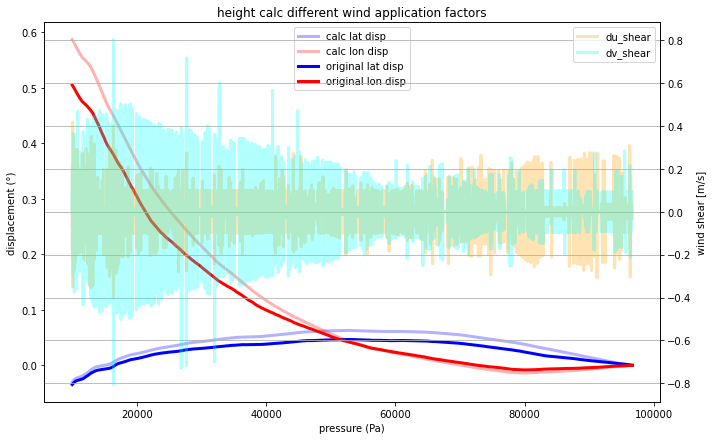

lat disp rmse:  0.012031459923819819
lon disp rmse:  0.04673010375914281


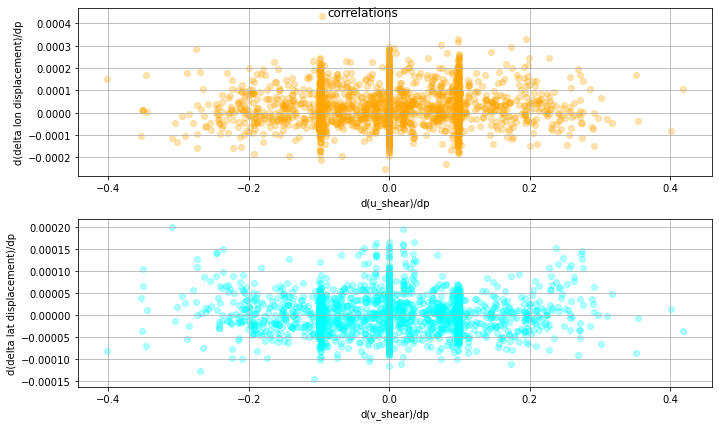

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230300.0   93060.0                                     0   
2     20200531.0    230300.0   93020.0                                     0   
3     20200531.0    230300.0   92970.0                                     0   
4     20200531.0    230300.0   92920.0                                     0   
5     20200531.0    230300.0   92860.0                                     0   
...          ...         ...       ...                                   ...   
2633  20200531.0    230300.0   10040.0                                     0   
2634  20200531.0    230300.0   10030.0                                     0   
2635  20200531.0    230300.0   10020.0                                     0   
2636  20200531.0    230300.0   10010.0                                     0   
2637  20200531.0    230300.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    732               0.00007                0.00011   
2                    736               0.00013                0.00016   
3                    740               0.00017                0.00018   
4                    745               0.00025                0.00032   
5                    750               0.00031                0.00044   
...                  ...                   ...                    ...   
2633               16445               0.25505                0.64621   
2634               16452               0.25507                0.64620   
2635               16460               0.25507                0.64624   
2636               16467               0.25509                0.64627   
2637               16474               0.25515                0.64621   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             288.96            226        7.4  47.68 -117.63  729.0   
2             288.82            225        7.5  47.68 -117.63  729.0   
3             288.67            225        7.6  47.68 -117.63  729.0   
4             288.51            224        7.8  47.68 -117.63  729.0   
5             288.38            224        7.9  47.68 -117.63  729.0   
...              ...            ...        ...    ...     ...    ...   
2633          216.12            132        3.1  47.68 -117.63  729.0   
2634          216.08            134        3.2  47.68 -117.63  729.0   
2635          216.05            135        3.3  47.68 -117.63  729.0   
2636          216.02            135        3.4  47.68 -117.63  729.0   
2637          216.01            136        3.5  47.68 -117.63  729.0   

      blockNumber  stationNumber         u         v  
1              72            786  5.323115  5.140472  
2              72            786  5.303301  5.303301  
3              72            786  5.374012  5.374012  
4              72            786  5.418335  5.610850  
5              72            786  5.487801  5.682784  
...           ...            ...       ...       ...  
2633           72            786 -2.303749  2.074305  
2634           72            786 -2.301887  2.222907  
2635           72            786 -2.333452  2.333452  
2636           72            786 -2.404163  2.404163  
2637           72            786 -2.431304  2.517689  

[2637 rows x 17 columns]

not a valid station


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230300.0   95080.0                                     0   
2     20200531.0    230300.0   95030.0                                     0   
3     20200531.0    230300.0   94990.0                                     0   
4     20200531.0    230300.0   94940.0                                     0   
5     20200531.0    230300.0   94890.0                                     0   
...          ...         ...       ...                                   ...   
2923  20200531.0    230300.0   10040.0                                     0   
2924  20200531.0    230300.0   10030.0                                     0   
2926  20200531.0    230300.0   10020.0                                     0   
2927  20200531.0    230300.0   10010.0                                     0   
2928  20200531.0    230300.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    511               0.00002               -0.00011   
2                    515               0.00005               -0.00022   
3                    519               0.00013               -0.00029   
4                    523               0.00026               -0.00040   
5                    528               0.00040               -0.00046   
...                  ...                   ...                    ...   
2923               16485               0.10494                0.49634   
2924               16490               0.10484                0.49643   
2926               16501               0.10463                0.49650   
2927               16506               0.10453                0.49656   
2928               16512               0.10442                0.49664   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             299.66            156        4.9  46.77 -100.76  505.0   
2             299.56            156        5.1  46.77 -100.76  505.0   
3             299.47            156        5.5  46.77 -100.76  505.0   
4             299.37            156        5.7  46.77 -100.76  505.0   
5             299.28            156        5.9  46.77 -100.76  505.0   
...              ...            ...        ...    ...     ...    ...   
2923          211.49            327       13.2  46.77 -100.76  505.0   
2924          211.47            328       13.1  46.77 -100.76  505.0   
2926          211.46            328       12.9  46.77 -100.76  505.0   
2927          211.46            329       12.9  46.77 -100.76  505.0   
2928          211.47            329       12.7  46.77 -100.76  505.0   

      blockNumber  stationNumber         u          v  
1              72            764 -1.993010   4.476373  
2              72            764 -2.074357   4.659082  
3              72            764 -2.237052   5.024500  
4              72            764 -2.318399   5.207209  
5              72            764 -2.399746   5.389918  
...           ...            ...       ...        ...  
2923           72            764  7.189235 -11.070451  
2924           72            764  6.941942 -11.109430  
2926           72            764  6.835959 -10.939820  
2927           72            764  6.643991 -11.057458  
2928           72            764  6.540984 -10.886025  

[2906 rows x 17 columns]

46.77 -100.76 20200531.0 230300.0
u_shear - delta lon disp:  (0.1140766121259909, 6.957110255794377e-10)
u_shear - delta lat disp:  (0.09145790811959513, 7.87326601927838e-07)
v_shear - delta lon disp:  (0.05053434825864749, 0.006435203080872887)
v_shear - delta lat disp:  (0.0777622139319989, 2.710653662835924e-05)

du_shear - delta lon disp:  (0.0002976166915355792, 0.9872050185956003)
du_shear - delta lat disp:  (0.0006699042765060829, 0.9712048415875913)
dv_shear - delta lon disp:  (-0.0005345718090337811, 0.9770201595528349)
dv_shear - delta lat disp:  (-0.0007524239718177001, 0.9676596514567207)

u_shear - d delta lon disp:  (-0.0019171678165704512, 0.9177208875428363)
u_shear - d delta lat disp:  (0.06764426500157161, 0.00026312704865598575)
v_shear - d delta lon disp:  (0.023165150595178343, 0.21188401537364085)
v_shear - d delta lat disp:  (-0.0184473630482559, 0.32017185213744276)

du_shear - d delta lon disp:  (0.03180531045704599, 0.0864855175592298)
du_shear - d delta lat 

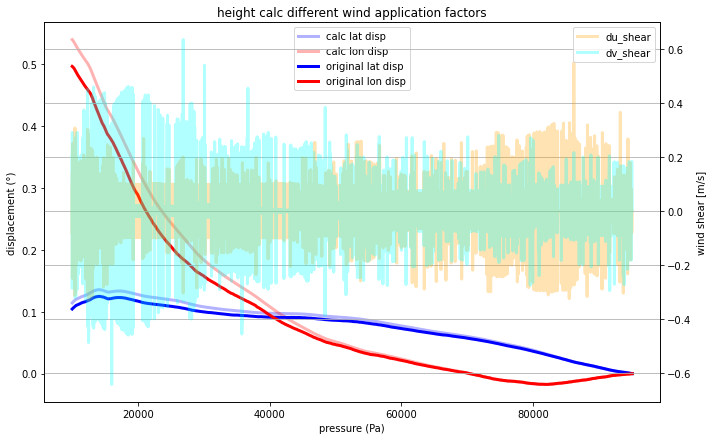

lat disp rmse:  0.00782404232906885
lon disp rmse:  0.027190874058180582


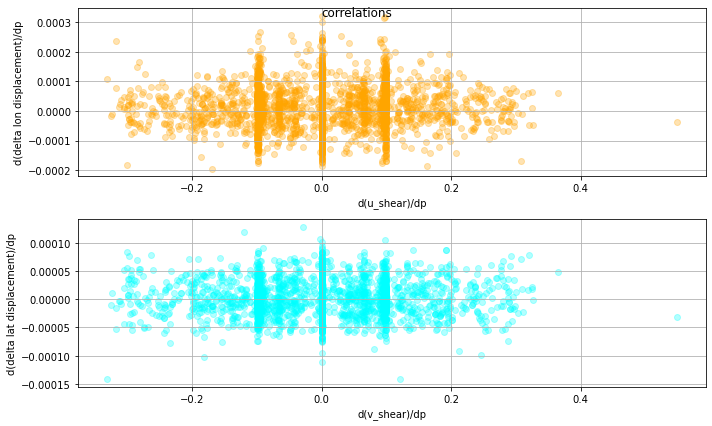

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230400.0  101320.0                                     0   
2     20200531.0    230400.0  101250.0                                     0   
3     20200531.0    230400.0  101180.0                                     0   
4     20200531.0    230400.0  101110.0                                     0   
5     20200531.0    230400.0  101040.0                                     0   
...          ...         ...       ...                                   ...   
2900  20200531.0    230400.0   10040.0                                     0   
2902  20200531.0    230400.0   10030.0                                     0   
2903  20200531.0    230400.0   10020.0                                     0   
2904  20200531.0    230400.0   10010.0                                     0   
2905  20200531.0    230400.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                     12               0.00008               -0.00009   
2                     19               0.00015               -0.00015   
3                     25               0.00018               -0.00022   
4                     31               0.00020               -0.00030   
5                     37               0.00019               -0.00034   
...                  ...                   ...                    ...   
2900               16571               0.31041                0.22807   
2902               16581               0.31046                0.22812   
2903               16587               0.31048                0.22819   
2904               16593               0.31049                0.22825   
2905               16598               0.31050                0.22828   

      airTemperature  windDirection  windSpeed    lat    lon  alt  \
1             301.07            103        2.7  25.92 -97.42  8.0   
2             300.97            103        2.7  25.92 -97.42  8.0   
3             300.89            100        2.7  25.92 -97.42  8.0   
4             300.81            100        2.8  25.92 -97.42  8.0   
5             300.72             98        2.8  25.92 -97.42  8.0   
...              ...            ...        ...    ...    ...  ...   
2900          204.46            264        3.9  25.92 -97.42  8.0   
2902          204.48            262        3.4  25.92 -97.42  8.0   
2903          204.53            261        3.2  25.92 -97.42  8.0   
2904          204.58            261        3.0  25.92 -97.42  8.0   
2905          204.62            258        2.9  25.92 -97.42  8.0   

      blockNumber  stationNumber         u         v  
1              72            250 -2.630799  0.607368  
2              72            250 -2.630799  0.607368  
3              72            250 -2.658981  0.468850  
4              72            250 -2.757462  0.486215  
5              72            250 -2.772751  0.389685  
...           ...            ...       ...       ...  
2900           72            250  3.878635  0.407661  
2902           72            250  3.366911  0.473189  
2903           72            250  3.160603  0.500590  
2904           72            250  2.963065  0.469303  
2905           72            250  2.836628  0.602944  

[2892 rows x 17 columns]

25.92 -97.42 20200531.0 230400.0
u_shear - delta lon disp:  (0.12040711632031911, 8.247368671078762e-11)
u_shear - delta lat disp:  (0.06454844089360268, 0.0005139780294352858)
v_shear - delta lon disp:  (0.14159923640364777, 2.0080760868854134e-14)
v_shear - delta lat disp:  (0.11245745597374135, 1.3253699242391526e-09)

du_shear - delta lon disp:  (0.0003667942293489771, 0.9842693819782621)
du_shear - delta lat disp:  (0.00047024812845539654, 0.9798334194170801)
dv_shear - delta lon disp:  (-0.0006522256291864862, 0.972032067912938)
dv_shear - delta lat disp:  (-0.00048660736475885025, 0.9791320111470334)

u_shear - d delta lon disp:  (-0.013496674396101431, 0.4681243569004662)
u_shear - d delta lat disp:  (0.005800175017416312, 0.7552034408225843)
v_shear - d delta lon disp:  (0.013890114880476537, 0.45525298580384715)
v_shear - d delta lat disp:  (0.02000898206365615, 0.28207401786405817)

du_shear - d delta lon disp:  (0.025683786962826645, 0.16732943709506248)
du_shear - d delta 

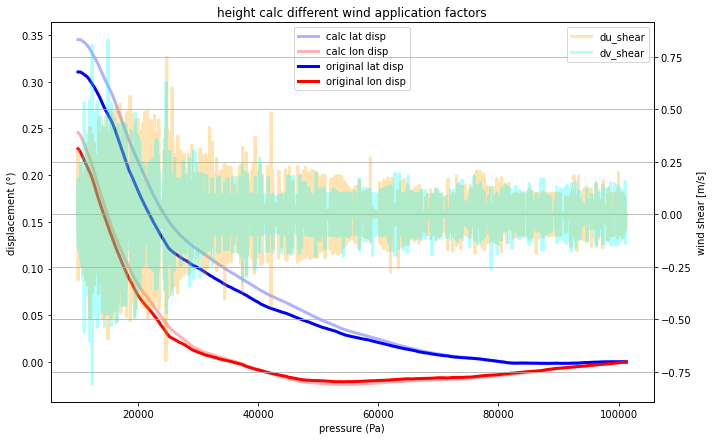

lat disp rmse:  0.02135574140325942
lon disp rmse:  0.00785104982125741


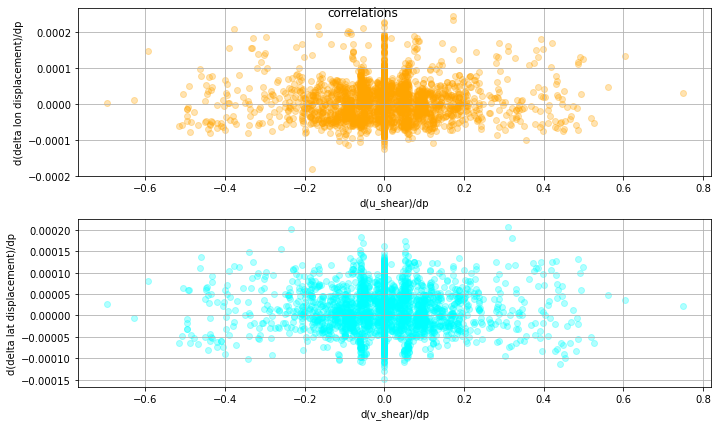

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230400.0   92280.0                                     0   
2     20200531.0    230400.0   92230.0                                     0   
3     20200531.0    230400.0   92170.0                                     0   
4     20200531.0    230400.0   92120.0                                     0   
5     20200531.0    230400.0   92060.0                                     0   
...          ...         ...       ...                                   ...   
2796  20200531.0    230400.0   10040.0                                     0   
2797  20200531.0    230400.0   10030.0                                     0   
2799  20200531.0    230400.0   10020.0                                     0   
2800  20200531.0    230400.0   10010.0                                     0   
2801  20200531.0    230400.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    698               0.00018               -0.00016   
2                    703               0.00034               -0.00032   
3                    708               0.00042               -0.00045   
4                    713               0.00049               -0.00058   
5                    719               0.00053               -0.00071   
...                  ...                   ...                    ...   
2796               16510               0.40812                0.41543   
2797               16514               0.40811                0.41552   
2799               16523               0.40809                0.41564   
2800               16528               0.40807                0.41566   
2801               16532               0.40805                0.41568   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             303.09            144        7.3  48.21 -106.63  694.0   
2             302.86            144        7.3  48.21 -106.63  694.0   
3             302.78            144        7.4  48.21 -106.63  694.0   
4             302.64            144        7.5  48.21 -106.63  694.0   
5             302.53            144        7.6  48.21 -106.63  694.0   
...              ...            ...        ...    ...     ...    ...   
2796          215.37            289        4.3  48.21 -106.63  694.0   
2797          215.38            289        4.2  48.21 -106.63  694.0   
2799          215.43            293        4.0  48.21 -106.63  694.0   
2800          215.44            295        4.0  48.21 -106.63  694.0   
2801          215.44            296        3.9  48.21 -106.63  694.0   

      blockNumber  stationNumber         u         v  
1              72            768 -4.290832  5.905824  
2              72            768 -4.290832  5.905824  
3              72            768 -4.349611  5.986726  
4              72            768 -4.408389  6.067627  
5              72            768 -4.467168  6.148529  
...           ...            ...       ...       ...  
2796           72            768  4.065730 -1.399943  
2797           72            768  3.971178 -1.367386  
2799           72            768  3.682019 -1.562925  
2800           72            768  3.625231 -1.690473  
2801           72            768  3.505297 -1.709647  

[2737 rows x 17 columns]

not a valid station


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230100.0   91480.0                                     0   
2     20200531.0    230100.0   91450.0                                     0   
3     20200531.0    230100.0   91400.0                                     0   
4     20200531.0    230100.0   91360.0                                     0   
5     20200531.0    230100.0   91300.0                                     0   
...          ...         ...       ...                                   ...   
3047  20200531.0    230100.0   10040.0                                     0   
3049  20200531.0    230100.0   10030.0                                     0   
3050  20200531.0    230100.0   10020.0                                     0   
3051  20200531.0    230100.0   10010.0                                     0   
3052  20200531.0    230100.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    850               0.00004                0.00004   
2                    854               0.00008                0.00004   
3                    858               0.00013               -0.00003   
4                    863               0.00022               -0.00012   
5                    868               0.00030               -0.00020   
...                  ...                   ...                    ...   
3047               16543               0.07797                0.37458   
3049               16553               0.07792                0.37471   
3050               16558               0.07793                0.37479   
3051               16563               0.07794                0.37487   
3052               16568               0.07794                0.37494   

      airTemperature  windDirection  windSpeed    lat    lon    alt  \
1             304.35            168        5.8  41.13 -100.7  848.0   
2             304.48            165        6.0  41.13 -100.7  848.0   
3             304.40            163        6.2  41.13 -100.7  848.0   
4             304.26            162        6.3  41.13 -100.7  848.0   
5             304.17            159        6.5  41.13 -100.7  848.0   
...              ...            ...        ...    ...    ...    ...   
3047          208.59            288        5.8  41.13 -100.7  848.0   
3049          208.54            288        5.8  41.13 -100.7  848.0   
3050          208.57            288        5.8  41.13 -100.7  848.0   
3051          208.62            288        5.8  41.13 -100.7  848.0   
3052          208.62            288        5.8  41.13 -100.7  848.0   

      blockNumber  stationNumber         u         v  
1              72            562 -1.205888  5.673256  
2              72            562 -1.552914  5.795555  
3              72            562 -1.812705  5.929089  
4              72            562 -1.946807  5.991656  
5              72            562 -2.329392  6.068273  
...           ...            ...       ...       ...  
3047           72            562  5.516128 -1.792299  
3049           72            562  5.516128 -1.792299  
3050           72            562  5.516128 -1.792299  
3051           72            562  5.516128 -1.792299  
3052           72            562  5.516128 -1.792299  

[3019 rows x 17 columns]

41.13 -100.7 20200531.0 230100.0
u_shear - delta lon disp:  (-0.013552158841918283, 0.45666175209871457)
u_shear - delta lat disp:  (0.052370563818819264, 0.003998163897824823)
v_shear - delta lon disp:  (-0.025904755085248362, 0.15473697233683373)
v_shear - delta lat disp:  (0.094247006408116, 2.1273800052779905e-07)

du_shear - delta lon disp:  (-0.0005113124179539658, 0.9775962345319119)
du_shear - delta lat disp:  (0.0004181254018818977, 0.9816785378512423)
dv_shear - delta lon disp:  (-0.00024916024038705846, 0.9890816522497823)
dv_shear - delta lat disp:  (-0.0006700661185088365, 0.9706430175896948)

u_shear - d delta lon disp:  (-0.01937900044341382, 0.2871264960106415)
u_shear - d delta lat disp:  (0.03269040752361375, 0.07250651829134502)
v_shear - d delta lon disp:  (-0.01361781073854682, 0.45448353141701897)
v_shear - d delta lat disp:  (-0.02696646927555941, 0.1385160077143666)

du_shear - d delta lon disp:  (0.022957094991377238, 0.20729760357151159)
du_shear - d delta lat

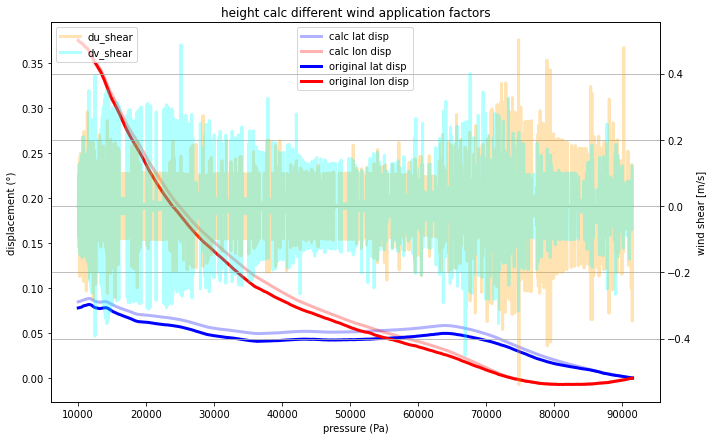

lat disp rmse:  0.0076684754114757754
lon disp rmse:  0.0070566781759092


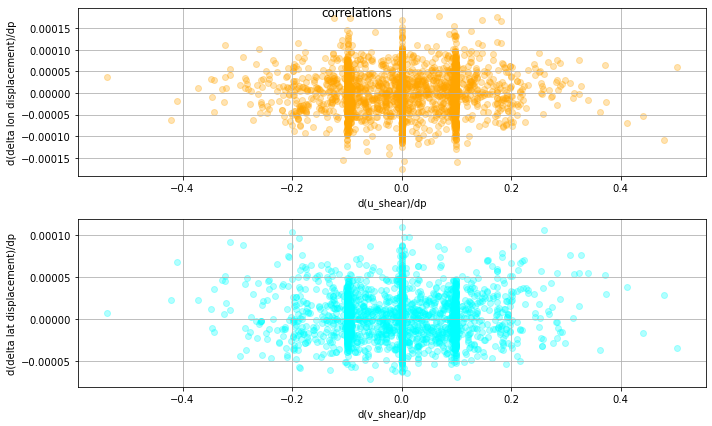

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230600.0   82530.0                                     0   
2     20200531.0    230600.0   82470.0                                     0   
3     20200531.0    230600.0   82410.0                                     0   
4     20200531.0    230600.0   82350.0                                     0   
5     20200531.0    230600.0   82290.0                                     0   
...          ...         ...       ...                                   ...   
2721  20200531.0    230600.0   10040.0                                     0   
2722  20200531.0    230600.0   10030.0                                     0   
2724  20200531.0    230600.0   10020.0                                     0   
2725  20200531.0    230600.0   10010.0                                     0   
2726  20200531.0    230600.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                   1705               0.00013                0.00014   
2                   1712               0.00026                0.00025   
3                   1718               0.00036                0.00031   
4                   1725               0.00045                0.00034   
5                   1731               0.00055                0.00032   
...                  ...                   ...                    ...   
2721               16495               0.27044                0.65070   
2722               16501               0.27039                0.65073   
2724               16512               0.27030                0.65086   
2725               16517               0.27029                0.65101   
2726               16522               0.27032                0.65116   

      airTemperature  windDirection  windSpeed    lat     lon     alt  \
1             301.67            210        7.3  43.06 -108.48  1699.0   
2             301.49            208        7.2  43.06 -108.48  1699.0   
3             301.32            207        7.3  43.06 -108.48  1699.0   
4             301.14            206        7.4  43.06 -108.48  1699.0   
5             300.96            204        7.4  43.06 -108.48  1699.0   
...              ...            ...        ...    ...     ...     ...   
2721          210.96            288        7.2  43.06 -108.48  1699.0   
2722          210.94            287        7.1  43.06 -108.48  1699.0   
2724          210.91            286        6.9  43.06 -108.48  1699.0   
2725          210.91            285        6.8  43.06 -108.48  1699.0   
2726          210.89            285        6.7  43.06 -108.48  1699.0   

      blockNumber  stationNumber         u         v  
1              72            672  3.650000  6.321985  
2              72            672  3.380195  6.357223  
3              72            672  3.314131  6.504348  
4              72            672  3.243946  6.651076  
5              72            672  3.009851  6.760236  
...           ...            ...       ...       ...  
2721           72            672  6.847607 -2.224922  
2722           72            672  6.789764 -2.075839  
2724           72            672  6.632706 -1.901898  
2725           72            672  6.568296 -1.759970  
2726           72            672  6.471703 -1.734088  

[2703 rows x 17 columns]

43.06 -108.48 20200531.0 230600.0
u_shear - delta lon disp:  (-0.01413640409328568, 0.46255034733376277)
u_shear - delta lat disp:  (-0.08235140986206778, 1.812786944129887e-05)
v_shear - delta lon disp:  (-0.03636065233650327, 0.0587372507194315)
v_shear - delta lat disp:  (-0.10514625979336707, 4.271089807997961e-08)

du_shear - delta lon disp:  (0.000827697812643011, 0.965691625510323)
du_shear - delta lat disp:  (0.00045298464364716413, 0.9812195692077075)
dv_shear - delta lon disp:  (0.0005110388959131029, 0.9788132133067922)
dv_shear - delta lat disp:  (4.915140978866031e-05, 0.9979620305807996)

u_shear - d delta lon disp:  (0.13206816686940473, 5.4508036243367965e-12)
u_shear - d delta lat disp:  (0.06654876902845298, 0.0005359103111764245)
v_shear - d delta lon disp:  (0.04500954989515477, 0.01927510181130035)
v_shear - d delta lat disp:  (0.017132759140832156, 0.3732554042291564)

du_shear - d delta lon disp:  (0.05080036325923739, 0.008251194689296677)
du_shear - d delta lat

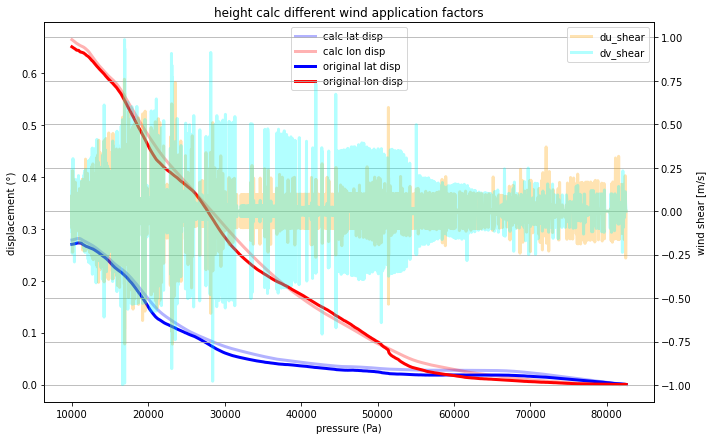

lat disp rmse:  0.008930208934874423
lon disp rmse:  0.011680261644970873


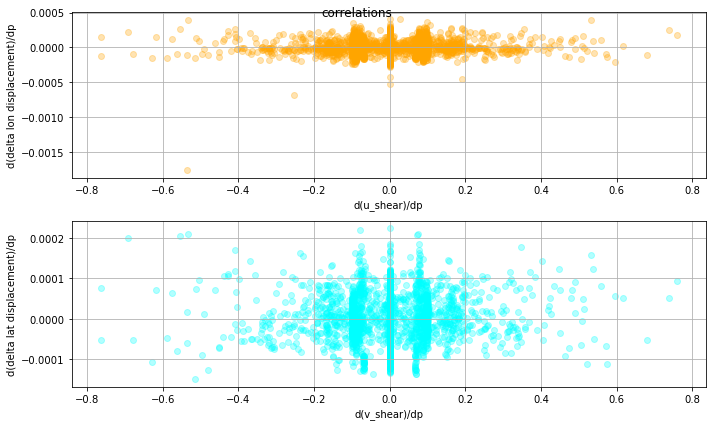

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230500.0   92360.0                                     0   
2     20200531.0    230500.0   92300.0                                     0   
3     20200531.0    230500.0   92230.0                                     0   
4     20200531.0    230500.0   92170.0                                     0   
5     20200531.0    230500.0   92100.0                                     0   
...          ...         ...       ...                                   ...   
2826  20200531.0    230500.0   10040.0                                     0   
2828  20200531.0    230500.0   10030.0                                     0   
2829  20200531.0    230500.0   10020.0                                     0   
2831  20200531.0    230500.0   10010.0                                     0   
2832  20200531.0    230500.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    757               0.00003               -0.00007   
2                    764               0.00005               -0.00005   
3                    770               0.00003                0.00002   
4                    776               0.00003                0.00005   
5                    783               0.00009                0.00005   
...                  ...                   ...                    ...   
2826               16548               0.08120                0.05008   
2828               16557               0.08131                0.05010   
2829               16561               0.08137                0.05011   
2831               16569               0.08152                0.05011   
2832               16573               0.08160                0.05011   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             306.72              0        2.2  32.23 -110.96  747.0   
2             306.60            357        1.8  32.23 -110.96  747.0   
3             306.51            352        1.4  32.23 -110.96  747.0   
4             306.43            345        1.1  32.23 -110.96  747.0   
5             306.34            330        0.8  32.23 -110.96  747.0   
...              ...            ...        ...    ...     ...    ...   
2826          208.39            182        7.8  32.23 -110.96  747.0   
2828          208.35            182        7.9  32.23 -110.96  747.0   
2829          208.28            182        7.9  32.23 -110.96  747.0   
2831          208.18            181        8.0  32.23 -110.96  747.0   
2832          208.15            181        8.1  32.23 -110.96  747.0   

      blockNumber  stationNumber         u         v  
1              72            274 -0.000000 -2.200000  
2              72            274  0.094205 -1.797533  
3              72            274  0.194842 -1.386375  
4              72            274  0.284701 -1.062518  
5              72            274  0.400000 -0.692820  
...           ...            ...       ...       ...  
2826           72            274  0.272216  7.795248  
2828           72            274  0.275706  7.895188  
2829           72            274  0.275706  7.895188  
2831           72            274  0.139619  7.998782  
2832           72            274  0.141364  8.098766  

[2785 rows x 17 columns]

32.230000000000004 -110.96000000000001 20200531.0 230500.0
u_shear - delta lon disp:  (0.07492583936165258, 7.562498783603189e-05)
u_shear - delta lat disp:  (0.040393083404023325, 0.033041294745565025)
v_shear - delta lon disp:  (0.08784367055015074, 3.4392137720785077e-06)
v_shear - delta lat disp:  (0.04785681980150272, 0.011541344201491806)

du_shear - delta lon disp:  (-0.0024194188358341363, 0.8984472509844937)
du_shear - delta lat disp:  (-0.0001997881128744143, 0.9915914858076864)
dv_shear - delta lon disp:  (-0.000945472897514202, 0.960223476433866)
dv_shear - delta lat disp:  (-0.002808775913882986, 0.8822152684779746)

u_shear - d delta lon disp:  (-0.06193288345725177, 0.0010752380917332484)
u_shear - d delta lat disp:  (-0.005641491794520345, 0.7660178479586802)
v_shear - d delta lon disp:  (-0.04967927761180055, 0.008737142676669593)
v_shear - d delta lat disp:  (-0.12403780488067728, 5.0892999536741516e-11)

du_shear - d delta lon disp:  (0.0468742850611208, 0.0133628157

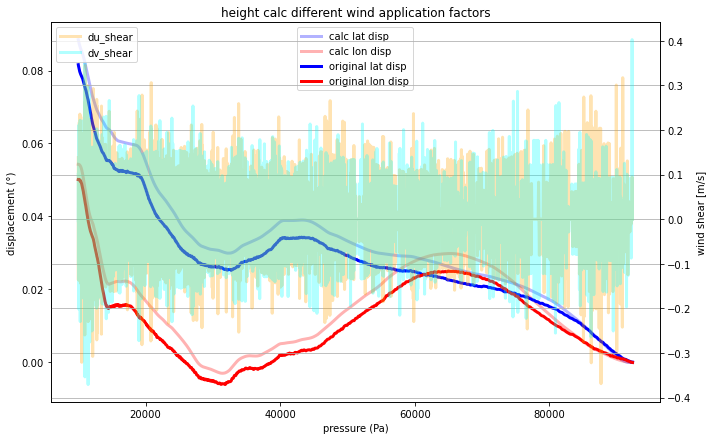

lat disp rmse:  0.005656866832547272
lon disp rmse:  0.004505916829214022


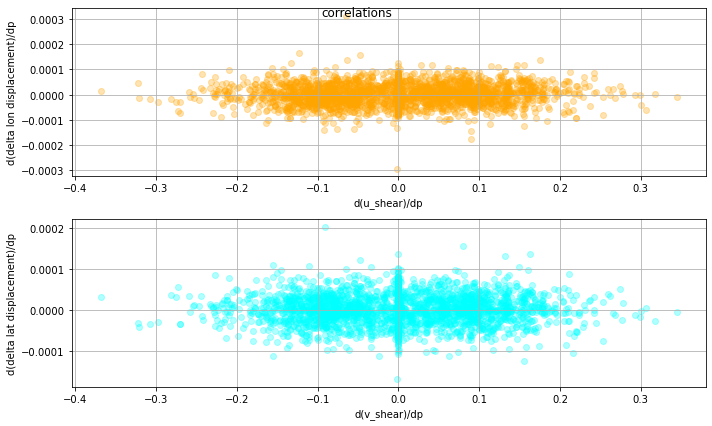

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230000.0   98540.0                                     0   
2     20200531.0    230000.0   98480.0                                     0   
3     20200531.0    230000.0   98420.0                                     0   
4     20200531.0    230000.0   98360.0                                     0   
5     20200531.0    230000.0   98300.0                                     0   
...          ...         ...       ...                                   ...   
3222  20200531.0    230000.0   10040.0                                     0   
3223  20200531.0    230000.0   10030.0                                     0   
3224  20200531.0    230000.0   10020.0                                     0   
3225  20200531.0    230000.0   10010.0                                     0   
3227  20200531.0    230000.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    282               0.00004               -0.00014   
2                    287               0.00006               -0.00026   
3                    292               0.00002               -0.00033   
4                    298              -0.00002               -0.00034   
5                    303              -0.00005               -0.00032   
...                  ...                   ...                    ...   
3222               16418              -0.46603                0.92623   
3223               16423              -0.46605                0.92645   
3224               16428              -0.46609                0.92669   
3225               16433              -0.46612                0.92692   
3227               16443              -0.46615                0.92736   

      airTemperature  windDirection  windSpeed   lat    lon    alt  \
1             296.40             80        3.6  36.1 -79.94  277.0   
2             296.34             82        3.4  36.1 -79.94  277.0   
3             296.29             82        3.4  36.1 -79.94  277.0   
4             296.23             83        3.3  36.1 -79.94  277.0   
5             296.18             85        3.3  36.1 -79.94  277.0   
...              ...            ...        ...   ...    ...    ...   
3222          209.49            275       19.7  36.1 -79.94  277.0   
3223          209.46            275       19.8  36.1 -79.94  277.0   
3224          209.43            275       19.9  36.1 -79.94  277.0   
3225          209.40            275       19.9  36.1 -79.94  277.0   
3227          209.37            275       20.0  36.1 -79.94  277.0   

      blockNumber  stationNumber          u         v  
1              72            317  -3.545308 -0.625133  
2              72            317  -3.366911 -0.473189  
3              72            317  -3.366911 -0.473189  
4              72            317  -3.275402 -0.402169  
5              72            317  -3.287443 -0.287614  
...           ...            ...        ...       ...  
3222           72            317  19.625036 -1.716968  
3223           72            317  19.724655 -1.725684  
3224           72            317  19.824274 -1.734399  
3225           72            317  19.824274 -1.734399  
3227           72            317  19.923894 -1.743115  

[3182 rows x 17 columns]

36.1 -79.94000000000001 20200531.0 230000.0
u_shear - delta lon disp:  (-0.0344081687489161, 0.052288613014655254)
u_shear - delta lat disp:  (0.05228710929321172, 0.003174302489417131)
v_shear - delta lon disp:  (-0.09149125645087872, 2.343848361401806e-07)
v_shear - delta lat disp:  (0.10647062142736391, 1.7368082483442168e-09)

du_shear - delta lon disp:  (-0.0007059134902240636, 0.9682490777361165)
du_shear - delta lat disp:  (0.00073715831112564, 0.9668445245486122)
dv_shear - delta lon disp:  (0.0005597533190738145, 0.9748206748042191)
dv_shear - delta lat disp:  (-0.00022946014699201132, 0.9896767930181966)

u_shear - d delta lon disp:  (-0.0008713499463915202, 0.9608134107830243)
u_shear - d delta lat disp:  (-0.00022740879919741502, 0.989769076243412)
v_shear - d delta lon disp:  (0.06598633449985933, 0.00019544297848692434)
v_shear - d delta lat disp:  (-0.050885191254586466, 0.004090123075580012)

du_shear - d delta lon disp:  (0.020540237118217758, 0.2467311532650208)
du_sh

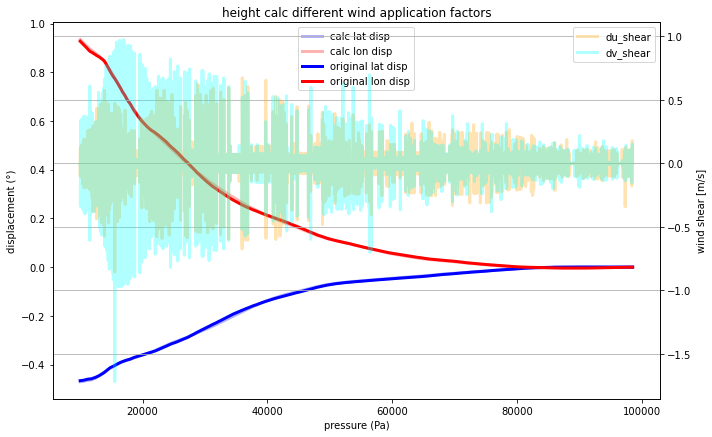

lat disp rmse:  0.003098055119745312
lon disp rmse:  0.004890441491970685


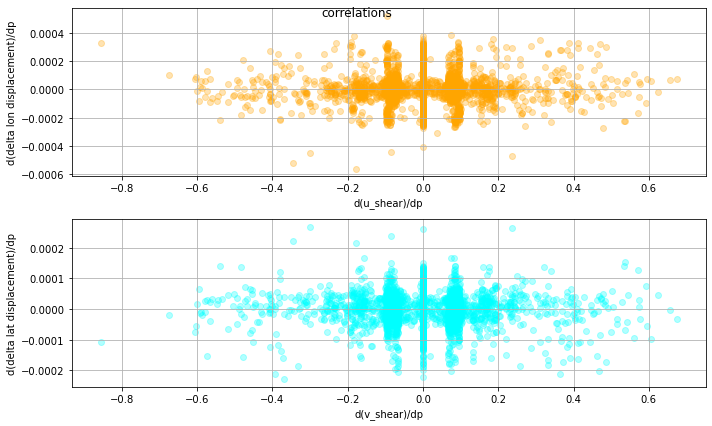

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230400.0   91820.0                                     0   
2     20200531.0    230400.0   91780.0                                     0   
3     20200531.0    230400.0   91730.0                                     0   
4     20200531.0    230400.0   91680.0                                     0   
5     20200531.0    230400.0   91620.0                                     0   
...          ...         ...       ...                                   ...   
3070  20200531.0    230400.0   10040.0                                     0   
3072  20200531.0    230400.0   10030.0                                     0   
3073  20200531.0    230400.0   10020.0                                     0   
3074  20200531.0    230400.0   10010.0                                     0   
3075  20200531.0    230400.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    870               0.00011                0.00004   
2                    873               0.00020                0.00004   
3                    878               0.00025               -0.00002   
4                    883               0.00034               -0.00010   
5                    889               0.00042               -0.00017   
...                  ...                   ...                    ...   
3070               16557               0.08486               -0.15995   
3072               16567               0.08484               -0.15995   
3073               16572               0.08485               -0.15990   
3074               16577               0.08487               -0.15987   
3075               16581               0.08488               -0.15986   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             303.13            167        3.7  31.94 -102.19  874.0   
2             303.01            166        3.8  31.94 -102.19  874.0   
3             302.89            165        3.8  31.94 -102.19  874.0   
4             302.77            165        3.9  31.94 -102.19  874.0   
5             302.65            164        4.1  31.94 -102.19  874.0   
...              ...            ...        ...    ...     ...    ...   
3070          205.72            283        1.7  31.94 -102.19  874.0   
3072          205.80            279        1.8  31.94 -102.19  874.0   
3073          205.89            276        1.8  31.94 -102.19  874.0   
3074          206.01            276        1.8  31.94 -102.19  874.0   
3075          206.14            273        1.8  31.94 -102.19  874.0   

      blockNumber  stationNumber         u         v  
1              72            265 -0.832319  3.605169  
2              72            265 -0.919303  3.687124  
3              72            265 -0.983512  3.670518  
4              72            265 -1.009394  3.767111  
5              72            265 -1.130113  3.941173  
...           ...            ...       ...       ...  
3070           72            265  1.656429 -0.382417  
3072           72            265  1.777839 -0.281582  
3073           72            265  1.790139 -0.188151  
3074           72            265  1.790139 -0.188151  
3075           72            265  1.797533 -0.094205  

[3047 rows x 17 columns]

31.94 -102.19000000000001 20200531.0 230400.0
u_shear - delta lon disp:  (-0.04348375145575262, 0.01637547291489703)
u_shear - delta lat disp:  (-0.04817956884466711, 0.007815266738133575)
v_shear - delta lon disp:  (-0.12971734473924754, 6.584383980604892e-13)
v_shear - delta lat disp:  (0.10042860834392385, 2.7698028390778597e-08)

du_shear - delta lon disp:  (-0.0013218356412283616, 0.9418578885905727)
du_shear - delta lat disp:  (-0.00028126817731513257, 0.9876177026869147)
dv_shear - delta lon disp:  (0.0018461157906073788, 0.9188652631159672)
dv_shear - delta lat disp:  (-0.0013994160510803167, 0.9384520309556861)

u_shear - d delta lon disp:  (0.03262787124073908, 0.07173644254466124)
u_shear - d delta lat disp:  (-0.026671029128310368, 0.1410508871495474)
v_shear - d delta lon disp:  (0.051458380718886185, 0.004494399942102211)
v_shear - d delta lat disp:  (-0.05327310032068983, 0.0032658670622748597)

du_shear - d delta lon disp:  (0.06875610584080386, 0.0001457212233649434)
d

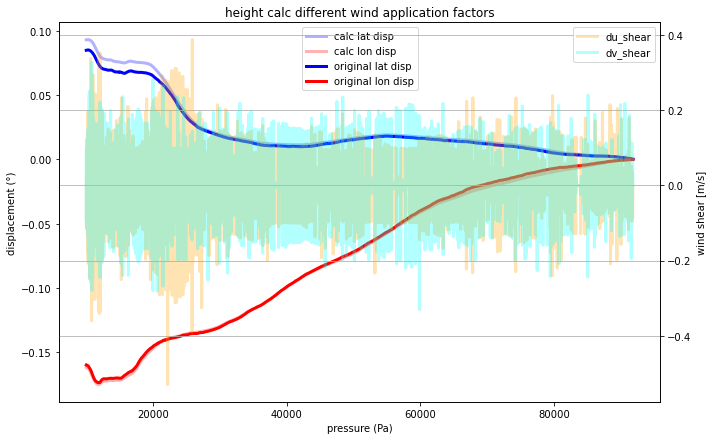

lat disp rmse:  0.00436452345107945
lon disp rmse:  0.0014501907479927112


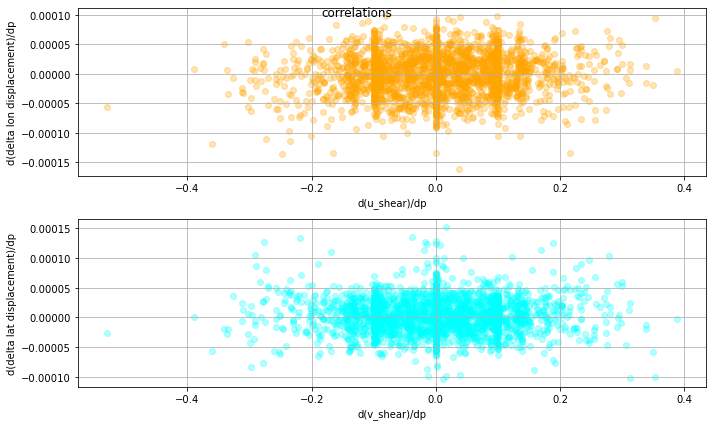

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230700.0   99560.0                                     0   
2     20200531.0    230700.0   99520.0                                     0   
3     20200531.0    230700.0   99480.0                                     0   
4     20200531.0    230700.0   99430.0                                     0   
5     20200531.0    230700.0   99380.0                                     0   
...          ...         ...       ...                                   ...   
3064  20200531.0    230700.0   10030.0                                     0   
3065  20200531.0    230700.0   10020.0                                     0   
3066  20200531.0    230700.0   10010.0                                     0   
3067  20200531.0    230700.0   10000.0                                     0   
3068  20200531.0    230700.0    9990.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    196               0.00011                0.00000   
2                    199               0.00019               -0.00001   
3                    203               0.00019               -0.00009   
4                    207               0.00022               -0.00022   
5                    211               0.00024               -0.00035   
...                  ...                   ...                    ...   
3064               16575               0.21748               -0.04067   
3065               16580               0.21749               -0.04063   
3066               16586               0.21752               -0.04061   
3067               16591               0.21755               -0.04059   
3068               16596               0.21759               -0.04057   

      airTemperature  windDirection  windSpeed    lat   lon    alt  \
1             302.67             63        3.0  32.84 -97.3  199.0   
2             302.39             65        3.1  32.84 -97.3  199.0   
3             302.25             69        3.0  32.84 -97.3  199.0   
4             302.13             71        3.1  32.84 -97.3  199.0   
5             302.05             73        3.1  32.84 -97.3  199.0   
...              ...            ...        ...    ...   ...    ...   
3064          205.06            232        5.0  32.84 -97.3  199.0   
3065          205.11            232        5.0  32.84 -97.3  199.0   
3066          205.15            232        5.0  32.84 -97.3  199.0   
3067          205.18            231        5.0  32.84 -97.3  199.0   
3068          205.22            231        5.0  32.84 -97.3  199.0   

      blockNumber  stationNumber         u         v  
1              72            249 -2.673020 -1.361971  
2              72            249 -2.809554 -1.310117  
3              72            249 -2.800741 -1.075104  
4              72            249 -2.931108 -1.009261  
5              72            249 -2.964545 -0.906352  
...           ...            ...       ...       ...  
3064           72            249  3.940054  3.078307  
3065           72            249  3.940054  3.078307  
3066           72            249  3.940054  3.078307  
3067           72            249  3.885730  3.146602  
3068           72            249  3.885730  3.146602  

[3045 rows x 17 columns]

32.84 -97.30000000000001 20200531.0 230700.0
u_shear - delta lon disp:  (0.09230773419496227, 3.352201901025885e-07)
u_shear - delta lat disp:  (0.008260046164654212, 0.6486614481772395)
v_shear - delta lon disp:  (0.05342284643121411, 0.003189595478981715)
v_shear - delta lat disp:  (0.11812041275633577, 6.222704440168222e-11)

du_shear - delta lon disp:  (-0.0006174206302185767, 0.9728323176005561)
du_shear - delta lat disp:  (-7.741284931790883e-05, 0.9965930395483107)
dv_shear - delta lon disp:  (0.0003343465413897316, 0.9852861072027156)
dv_shear - delta lat disp:  (-0.00012366040387093682, 0.994557697808578)

u_shear - d delta lon disp:  (0.0029093586004433937, 0.8725051422351547)
u_shear - d delta lat disp:  (-0.01622695067428809, 0.37072344562642207)
v_shear - d delta lon disp:  (0.024418674790089266, 0.17794572237659587)
v_shear - d delta lat disp:  (-0.0022192724953861266, 0.9025721843910567)

du_shear - d delta lon disp:  (0.04489350673273692, 0.013229757693281318)
du_shear 

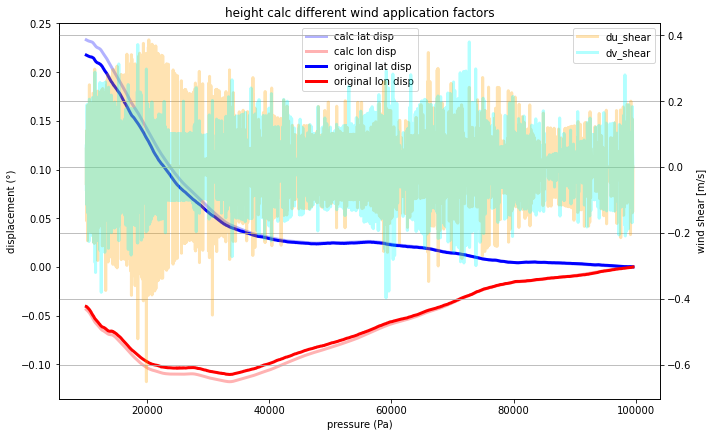

lat disp rmse:  0.007900286215605172
lon disp rmse:  0.00467056223357241


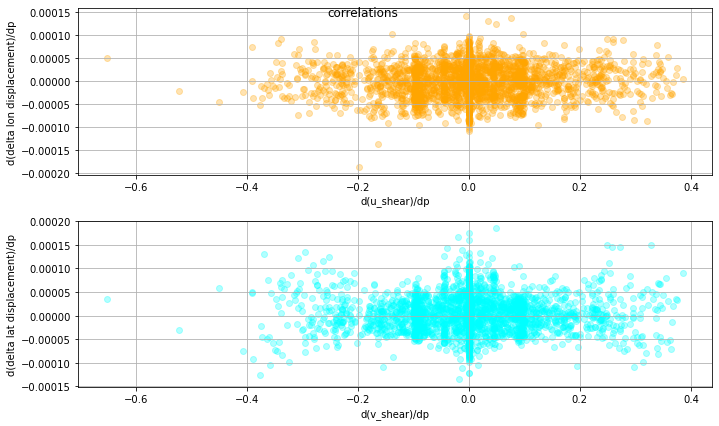

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230500.0   98090.0                                     0   
2     20200531.0    230500.0   98050.0                                     0   
3     20200531.0    230500.0   97990.0                                     0   
4     20200531.0    230500.0   97940.0                                     0   
5     20200531.0    230500.0   97870.0                                     0   
...          ...         ...       ...                                   ...   
3265  20200531.0    230500.0   10040.0                                     0   
3266  20200531.0    230500.0   10030.0                                     0   
3267  20200531.0    230500.0   10020.0                                     0   
3269  20200531.0    230500.0   10010.0                                     0   
3270  20200531.0    230500.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    361               0.00001                0.00003   
2                    364               0.00003                0.00007   
3                    369               0.00001                0.00014   
4                    374              -0.00005                0.00021   
5                    379              -0.00010                0.00029   
...                  ...                   ...                    ...   
3265               16341              -0.56460                0.83210   
3266               16346              -0.56469                0.83237   
3267               16350              -0.56479                0.83267   
3269               16359              -0.56497                0.83321   
3270               16363              -0.56505                0.83340   

      airTemperature  windDirection  windSpeed    lat    lon    alt  \
1             289.16            314        3.2  40.53 -80.22  359.0   
2             289.00            314        3.3  40.53 -80.22  359.0   
3             288.80            314        3.5  40.53 -80.22  359.0   
4             288.64            314        3.6  40.53 -80.22  359.0   
5             288.50            314        3.7  40.53 -80.22  359.0   
...              ...            ...        ...    ...    ...    ...   
3265          215.93            294       22.2  40.53 -80.22  359.0   
3266          215.95            294       22.2  40.53 -80.22  359.0   
3267          215.96            294       22.3  40.53 -80.22  359.0   
3269          215.99            294       22.2  40.53 -80.22  359.0   
3270          216.01            295       22.1  40.53 -80.22  359.0   

      blockNumber  stationNumber          u         v  
1              72            520   2.301887 -2.222907  
2              72            520   2.373821 -2.292373  
3              72            520   2.517689 -2.431304  
4              72            520   2.589623 -2.500770  
5              72            520   2.661557 -2.570236  
...           ...            ...        ...       ...  
3265           72            520  20.280709 -9.029553  
3266           72            520  20.280709 -9.029553  
3267           72            520  20.372064 -9.070227  
3269           72            520  20.280709 -9.029553  
3270           72            520  20.029402 -9.339864  

[3229 rows x 17 columns]

40.53 -80.22000000000001 20200531.0 230500.0
u_shear - delta lon disp:  (-0.12835909764529707, 2.4540723992110215e-13)
u_shear - delta lat disp:  (0.12014923878874981, 7.406858387368631e-12)
v_shear - delta lon disp:  (0.1233509533336255, 2.0142846289814493e-12)
v_shear - delta lat disp:  (-0.13820509465528916, 3.0646226392179123e-15)

du_shear - delta lon disp:  (-0.0008038761208547627, 0.9635796429273027)
du_shear - delta lat disp:  (0.0007542863497009361, 0.9658249347787298)
dv_shear - delta lon disp:  (-0.0006798368596182571, 0.9691963110443242)
dv_shear - delta lat disp:  (0.0007099353435019572, 0.9678332593890548)

u_shear - d delta lon disp:  (-0.005922322620065997, 0.7365659085162193)
u_shear - d delta lat disp:  (-0.011720195105327102, 0.505566578210262)
v_shear - d delta lon disp:  (-0.023047559567471995, 0.1904232530470779)
v_shear - d delta lat disp:  (0.0017223454003960806, 0.9220647172046819)

du_shear - d delta lon disp:  (-0.0016789236223502433, 0.9240235078094962)
du_s

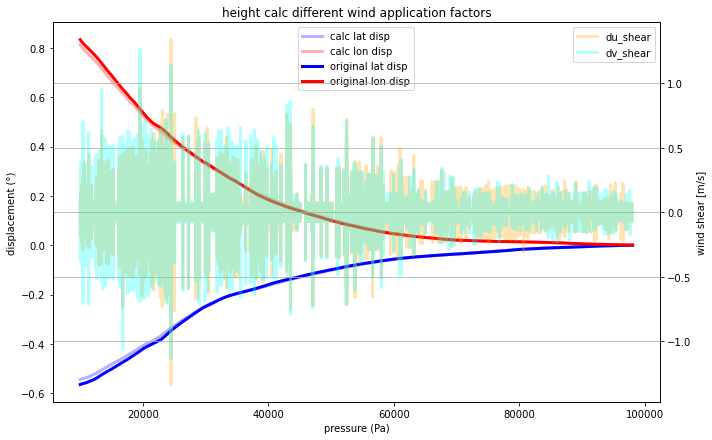

lat disp rmse:  0.010747025262576019
lon disp rmse:  0.011460660297592625


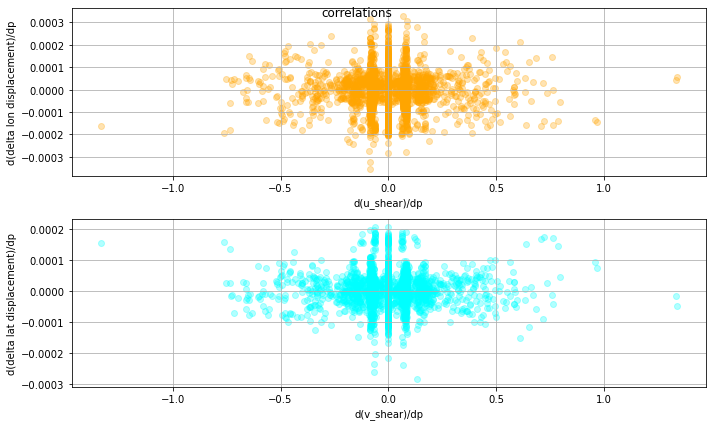

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230000.0  101390.0                                     0   
2     20200531.0    230000.0  101320.0                                     0   
3     20200531.0    230000.0  101250.0                                     0   
4     20200531.0    230000.0  101180.0                                     0   
5     20200531.0    230000.0  101110.0                                     0   
...          ...         ...       ...                                   ...   
3165  20200531.0    230000.0   10040.0                                     0   
3167  20200531.0    230000.0   10030.0                                     0   
3168  20200531.0    230000.0   10020.0                                     0   
3169  20200531.0    230000.0   10010.0                                     0   
3170  20200531.0    230000.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                     10               0.00008                0.00001   
2                     16               0.00015                0.00003   
3                     22               0.00016                0.00009   
4                     28               0.00015                0.00012   
5                     34               0.00010                0.00016   
...                  ...                   ...                    ...   
3165               16447               0.46182                0.14986   
3167               16457               0.46189                0.15004   
3168               16462               0.46192                0.15015   
3169               16467               0.46199                0.15020   
3170               16472               0.46210                0.15016   

      airTemperature  windDirection  windSpeed    lat     lon  alt  \
1             292.34            288        4.2  37.74 -122.22  4.0   
2             292.22            288        4.3  37.74 -122.22  4.0   
3             292.11            287        4.4  37.74 -122.22  4.0   
4             291.99            287        4.5  37.74 -122.22  4.0   
5             291.88            287        4.5  37.74 -122.22  4.0   
...              ...            ...        ...    ...     ...  ...   
3165          216.19            215        7.8  37.74 -122.22  4.0   
3167          216.15            214        7.6  37.74 -122.22  4.0   
3168          216.15            213        7.4  37.74 -122.22  4.0   
3169          216.16            213        7.4  37.74 -122.22  4.0   
3170          216.15            213        7.2  37.74 -122.22  4.0   

      blockNumber  stationNumber         u         v  
1              72            493  3.994437 -1.297871  
2              72            493  4.089543 -1.328773  
3              72            493  4.207741 -1.286436  
4              72            493  4.303371 -1.315673  
5              72            493  4.303371 -1.315673  
...           ...            ...       ...       ...  
3165           72            493  4.473896  6.389386  
3167           72            493  4.249866  6.300686  
3168           72            493  4.030329  6.206162  
3169           72            493  4.030329  6.206162  
3170           72            493  3.921401  6.038428  

[3129 rows x 17 columns]

37.74 -122.22000000000001 20200531.0 230000.0
u_shear - delta lon disp:  (-0.03376899675756146, 0.058927216305692)
u_shear - delta lat disp:  (-0.01497802970768737, 0.4022861666403945)
v_shear - delta lon disp:  (0.006779491503389504, 0.7046281603686723)
v_shear - delta lat disp:  (0.036188699657265753, 0.0429538686891205)

du_shear - delta lon disp:  (-0.000854938040654234, 0.9618724747617038)
du_shear - delta lat disp:  (-8.99610442281894e-05, 0.9959865122797427)
dv_shear - delta lon disp:  (0.0002417233490474259, 0.9892161294184643)
dv_shear - delta lat disp:  (-2.0850476686659318e-05, 0.9990697810706299)

u_shear - d delta lon disp:  (0.004007400143934693, 0.822698837688188)
u_shear - d delta lat disp:  (0.01888442326266935, 0.2909596016909128)
v_shear - d delta lon disp:  (0.038183480343870486, 0.03269469797366668)
v_shear - d delta lat disp:  (0.04620620891133249, 0.009737726920217304)

du_shear - d delta lon disp:  (0.027280296878257847, 0.12709335243055145)
du_shear - d delta l

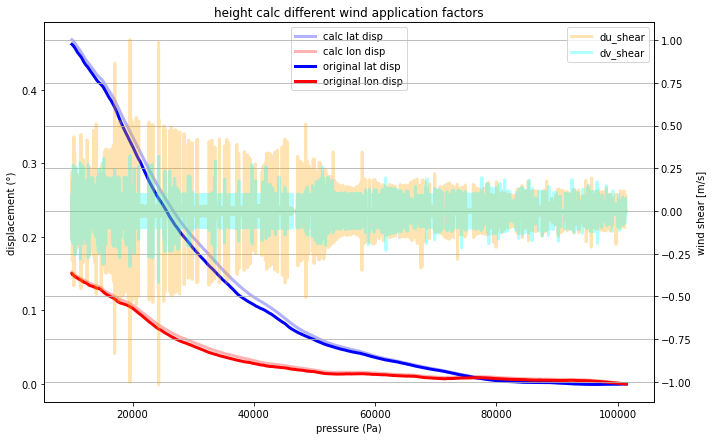

lat disp rmse:  0.009400621247725382
lon disp rmse:  0.0034973036447949074


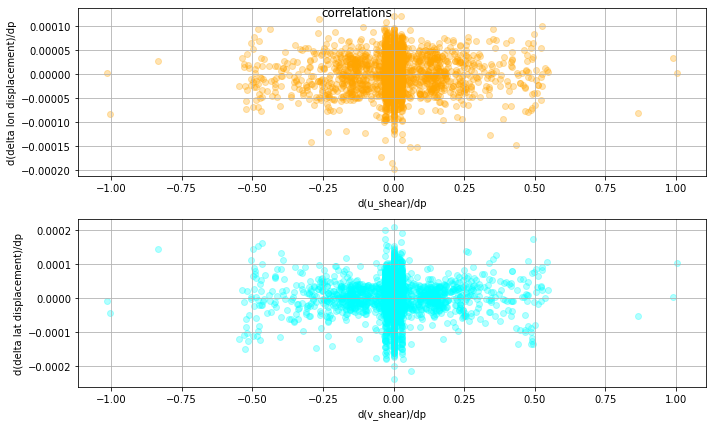

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230300.0  100240.0                                     0   
2     20200531.0    230300.0  100160.0                                     0   
3     20200531.0    230300.0  100080.0                                     0   
4     20200531.0    230300.0  100010.0                                     0   
5     20200531.0    230300.0   99940.0                                     0   
...          ...         ...       ...                                   ...   
3162  20200531.0    230300.0   10040.0                                     0   
3164  20200531.0    230300.0   10030.0                                     0   
3165  20200531.0    230300.0   10020.0                                     0   
3166  20200531.0    230300.0   10010.0                                     0   
3167  20200531.0    230300.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    125              -0.00013                0.00004   
2                    131              -0.00027                0.00007   
3                    138              -0.00040                0.00010   
4                    144              -0.00050                0.00015   
5                    150              -0.00058                0.00022   
...                  ...                   ...                    ...   
3162               16287               0.38729                0.75879   
3164               16297               0.38745                0.75916   
3165               16302               0.38752                0.75933   
3166               16307               0.38759                0.75950   
3167               16312               0.38767                0.75968   

      airTemperature  windDirection  windSpeed    lat    lon    alt  \
1             284.56            326        6.9  43.89 -70.26  118.0   
2             284.42            326        7.1  43.89 -70.26  118.0   
3             284.32            325        7.4  43.89 -70.26  118.0   
4             284.23            326        7.6  43.89 -70.26  118.0   
5             284.15            325        7.9  43.89 -70.26  118.0   
...              ...            ...        ...    ...    ...    ...   
3162          221.23            241       16.8  43.89 -70.26  118.0   
3164          221.19            242       16.6  43.89 -70.26  118.0   
3165          221.16            242       16.4  43.89 -70.26  118.0   
3166          221.15            242       16.2  43.89 -70.26  118.0   
3167          221.14            243       16.2  43.89 -70.26  118.0   

      blockNumber  stationNumber          u         v  
1              74            389   3.858431 -5.720359  
2              74            389   3.970270 -5.886167  
3              74            389   4.244466 -6.061725  
4              74            389   4.249866 -6.300686  
5              74            389   4.531254 -6.471301  
...           ...            ...        ...       ...  
3162           74            389  14.693611  8.144802  
3164           74            389  14.656930  7.793228  
3165           74            389  14.480341  7.699334  
3166           74            389  14.303751  7.605439  
3167           74            389  14.434306  7.354646  

[3121 rows x 17 columns]

43.89 -70.26 20200531.0 230300.0
u_shear - delta lon disp:  (0.08777641238672415, 9.050853318102002e-07)
u_shear - delta lat disp:  (0.08259780687578365, 3.829089158962564e-06)
v_shear - delta lon disp:  (0.06728364833386156, 0.00016881666458920747)
v_shear - delta lat disp:  (0.06383503343288895, 0.00035914953916770735)

du_shear - delta lon disp:  (1.0267903106909346e-05, 0.999542496228056)
du_shear - delta lat disp:  (0.00019908120241384636, 0.9911297828490121)
dv_shear - delta lon disp:  (0.00012637543169320687, 0.9943691755516132)
dv_shear - delta lat disp:  (-0.00011680606141937036, 0.9947955452047366)

u_shear - d delta lon disp:  (-0.005351637117366967, 0.7650495716094109)
u_shear - d delta lat disp:  (0.005963764686806712, 0.7391036031403073)
v_shear - d delta lon disp:  (0.08964314867833297, 5.273330279299371e-07)
v_shear - d delta lat disp:  (0.0552462836112765, 0.002018439404789776)

du_shear - d delta lon disp:  (-0.0005371973825067802, 0.9760678496906803)
du_shear - d del

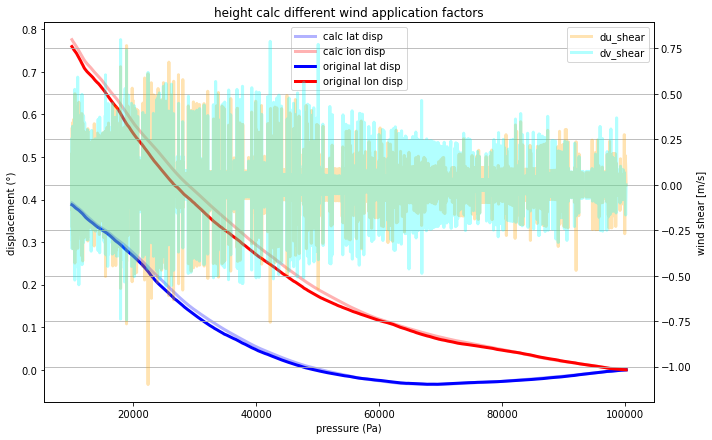

lat disp rmse:  0.007112823881626124
lon disp rmse:  0.02004584309109585


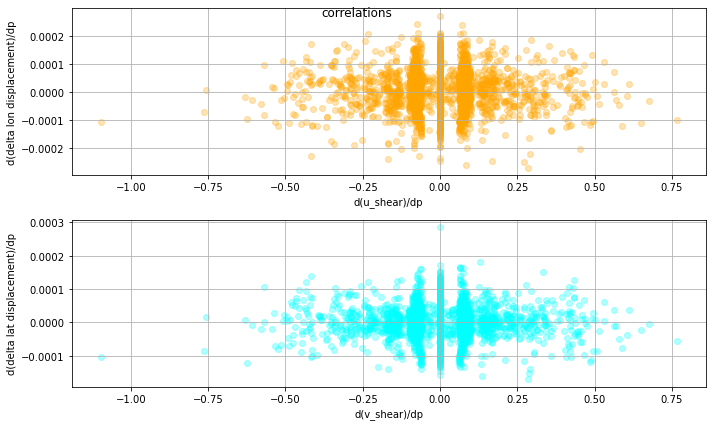

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230300.0   96780.0                                     0   
2     20200531.0    230300.0   96720.0                                     0   
3     20200531.0    230300.0   96650.0                                     0   
4     20200531.0    230300.0   96590.0                                     0   
5     20200531.0    230300.0   96520.0                                     0   
...          ...         ...       ...                                   ...   
3167  20200531.0    230300.0   10030.0                                     0   
3168  20200531.0    230300.0   10020.0                                     0   
3170  20200531.0    230300.0   10010.0                                     0   
3171  20200531.0    230300.0   10000.0                                     0   
3172  20200531.0    230300.0    9990.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    404              -0.00008               -0.00010   
2                    409              -0.00015               -0.00016   
3                    415              -0.00020               -0.00019   
4                    421              -0.00024               -0.00026   
5                    427              -0.00024               -0.00031   
...                  ...                   ...                    ...   
3167               16434               0.45685                0.34623   
3168               16439               0.45694                0.34626   
3170               16448               0.45708                0.34632   
3171               16453               0.45713                0.34634   
3172               16458               0.45719                0.34636   

      airTemperature  windDirection  windSpeed    lat     lon    alt  \
1             293.49            259        1.5  42.38 -122.88  399.0   
2             293.42            263        1.6  42.38 -122.88  399.0   
3             293.26            266        1.6  42.38 -122.88  399.0   
4             293.11            270        1.6  42.38 -122.88  399.0   
5             293.00            274        1.6  42.38 -122.88  399.0   
...              ...            ...        ...    ...     ...    ...   
3167          217.44            198        9.2  42.38 -122.88  399.0   
3168          217.40            198        9.2  42.38 -122.88  399.0   
3170          217.30            197        9.3  42.38 -122.88  399.0   
3171          217.26            197        9.3  42.38 -122.88  399.0   
3172          217.22            197        9.3  42.38 -122.88  399.0   

      blockNumber  stationNumber         u             v  
1              72            597  1.472441  2.862135e-01  
2              72            597  1.588074  1.949909e-01  
3              72            597  1.596102  1.116104e-01  
4              72            597  1.600000  2.939152e-16  
5              72            597  1.596102 -1.116104e-01  
...           ...            ...       ...           ...  
3167           72            597  2.842956  8.749720e+00  
3168           72            597  2.842956  8.749720e+00  
3170           72            597  2.719057  8.893634e+00  
3171           72            597  2.719057  8.893634e+00  
3172           72            597  2.719057  8.893634e+00  

[3121 rows x 17 columns]

not a valid station


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    230000.0  100020.0                                     0   
2     20200531.0    230000.0   99980.0                                     0   
3     20200531.0    230000.0   99920.0                                     0   
4     20200531.0    230000.0   99870.0                                     0   
5     20200531.0    230000.0   99820.0                                     0   
...          ...         ...       ...                                   ...   
3351  20200531.0    230000.0   10040.0                                     0   
3352  20200531.0    230000.0   10030.0                                     0   
3354  20200531.0    230000.0   10020.0                                     0   
3355  20200531.0    230000.0   10010.0                                     0   
3356  20200531.0    230000.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                    181               0.00008                0.00009   
2                    185               0.00014                0.00014   
3                    190               0.00013                0.00010   
4                    194               0.00011                0.00007   
5                    199               0.00005                0.00000   
...                  ...                   ...                    ...   
3351               16501              -0.38655                0.49866   
3352               16505              -0.38665                0.49887   
3354               16514              -0.38691                0.49919   
3355               16519              -0.38705                0.49934   
3356               16523              -0.38717                0.49953   

      airTemperature  windDirection  windSpeed    lat    lon    alt  \
1             296.19             52        1.8  36.25 -86.56  173.0   
2             296.43             49        2.0  36.25 -86.56  173.0   
3             296.53             47        2.2  36.25 -86.56  173.0   
4             296.55             48        2.4  36.25 -86.56  173.0   
5             296.61             47        2.6  36.25 -86.56  173.0   
...              ...            ...        ...    ...    ...    ...   
3351          205.55            314       22.6  36.25 -86.56  173.0   
3352          205.53            315       22.5  36.25 -86.56  173.0   
3354          205.50            315       22.3  36.25 -86.56  173.0   
3355          205.47            315       22.3  36.25 -86.56  173.0   
3356          205.44            315       22.3  36.25 -86.56  173.0   

      blockNumber  stationNumber          u          v  
1              72            327  -1.418419  -1.108191  
2              72            327  -1.509419  -1.312118  
3              72            327  -1.608978  -1.500396  
4              72            327  -1.783548  -1.605913  
5              72            327  -1.901520  -1.773196  
...           ...            ...        ...        ...  
3351           72            327  16.257079 -15.699279  
3352           72            327  15.909903 -15.909903  
3354           72            327  15.768481 -15.768481  
3355           72            327  15.768481 -15.768481  
3356           72            327  15.768481 -15.768481  

[3341 rows x 17 columns]

36.25 -86.56 20200531.0 230000.0
u_shear - delta lon disp:  (0.03006015213110639, 0.08234115122718265)
u_shear - delta lat disp:  (0.019331206544221123, 0.26397006418500446)
v_shear - delta lon disp:  (0.07548229067858162, 1.2563083777136897e-05)
v_shear - delta lat disp:  (-0.06963661059115558, 5.6139328610874466e-05)

du_shear - delta lon disp:  (-0.000614783543136296, 0.9716634676261744)
du_shear - delta lat disp:  (0.00016825379583691182, 0.9922433572882604)
dv_shear - delta lon disp:  (0.00010706116378047273, 0.9950643432867113)
dv_shear - delta lat disp:  (-5.220861917759437e-05, 0.9975931041209009)

u_shear - d delta lon disp:  (-0.03985864651514426, 0.021226105465766216)
u_shear - d delta lat disp:  (0.009693851489053102, 0.5753965532500226)
v_shear - d delta lon disp:  (-0.044239170086858695, 0.010546381702215092)
v_shear - d delta lat disp:  (0.009367271629224882, 0.5883349136920781)

du_shear - d delta lon disp:  (0.009875014546692087, 0.5682777153512582)
du_shear - d delta 

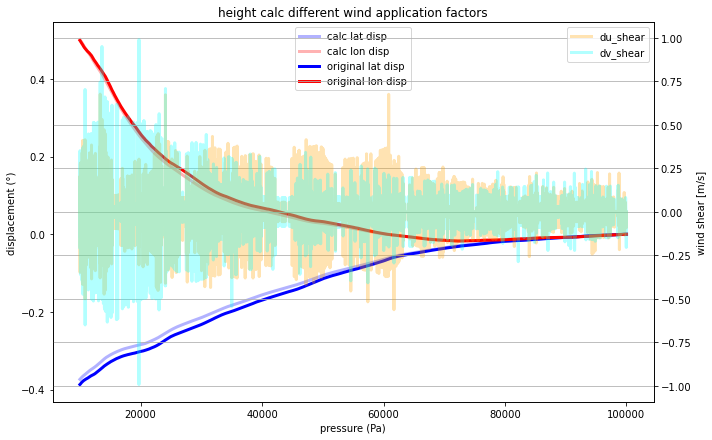

lat disp rmse:  0.013125904754031938
lon disp rmse:  0.006505023485380775


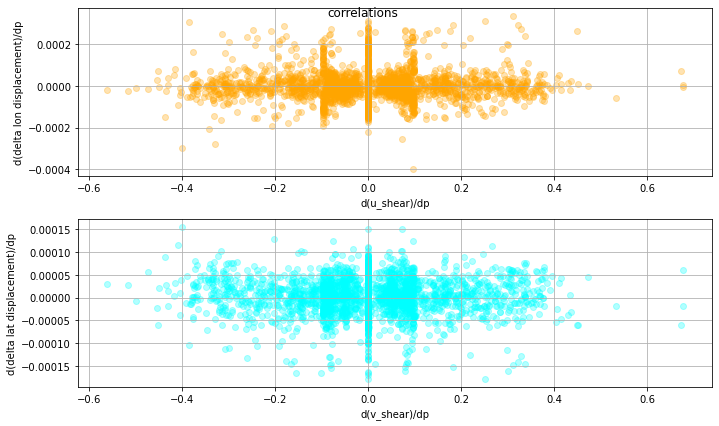

----------------


datum  timePeriod  pressure  extendedVerticalSoundingSignificance  \
1     20200531.0    231300.0   83860.0                                     0   
2     20200531.0    231300.0   83820.0                                     0   
3     20200531.0    231300.0   83780.0                                     0   
4     20200531.0    231300.0   83750.0                                     0   
5     20200531.0    231300.0   83700.0                                     0   
...          ...         ...       ...                                   ...   
2705  20200531.0    231300.0   10040.0                                     0   
2707  20200531.0    231300.0   10030.0                                     0   
2708  20200531.0    231300.0   10020.0                                     0   
2709  20200531.0    231300.0   10010.0                                     0   
2711  20200531.0    231300.0   10000.0                                     0   

      geopotentialHeight  latitudeDisplacement  longitudeDisplacement  \
1                   1622               0.00000               -0.00016   
2                   1626               0.00000               -0.00029   
3                   1630               0.00001               -0.00041   
4                   1634               0.00000               -0.00053   
5                   1638              -0.00002               -0.00063   
...                  ...                   ...                    ...   
2705               16541               0.06976               -0.02510   
2707               16551               0.06981               -0.02501   
2708               16555               0.06984               -0.02497   
2709               16560               0.06987               -0.02494   
2711               16569               0.06993               -0.02485   

      airTemperature  windDirection  windSpeed    lat     lon     alt  \
1             302.21             88        5.2  35.04 -106.62  1619.0   
2             302.07             88        5.3  35.04 -106.62  1619.0   
3             301.93             89        5.4  35.04 -106.62  1619.0   
4             301.79             90        5.4  35.04 -106.62  1619.0   
5             301.65             90        5.5  35.04 -106.62  1619.0   
...              ...            ...        ...    ...     ...     ...   
2705          206.74            234        4.6  35.04 -106.62  1619.0   
2707          206.79            236        4.7  35.04 -106.62  1619.0   
2708          206.81            237        4.8  35.04 -106.62  1619.0   
2709          206.84            239        4.9  35.04 -106.62  1619.0   
2711          206.90            241        5.0  35.04 -106.62  1619.0   

      blockNumber  stationNumber         u             v  
1              72            365 -5.196832 -1.814774e-01  
2              72            365 -5.296771 -1.849673e-01  
3              72            365 -5.399178 -9.424299e-02  
4              72            365 -5.400000 -3.306546e-16  
5              72            365 -5.500000 -3.367779e-16  
...           ...            ...       ...           ...  
2705           72            365  3.721478  2.703812e+00  
2707           72            365  3.896477  2.628207e+00  
2708           72            365  4.025619  2.614267e+00  
2709           72            365  4.200120  2.523687e+00  
2711           72            365  4.373099  2.424048e+00  

[2657 rows x 17 columns]

In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202006')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0]) #'./out.bufr')# sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))
# # exit()

# More ascents

In [4]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_1={}
    rms_sum_lat_1={}
    rms_sum_lon_2={}
    rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_1[i] = []
        rms_sum_lat_1[i] = []
        rms_sum_lon_2[i] = []
        rms_sum_lat_2[i] = []
        
    while 1:
        try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
                ##print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

                # print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                codes_release(bufr)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            codes_release(bufr)
            try:
                data = pd.DataFrame.from_dict(output)
                cont = True
            except:
                cont = False
            if cont:
                if data.pressure[0] < 40000:
                    u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                    data['u'] = u
                    v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                    data['v'] = v
                    data = data[data.airTemperature < 350]
                    data = data[data.airTemperature > 180]
                    data = data.drop_duplicates(['pressure'])

                    true_latd = data.latitudeDisplacement
                    true_lond = data.longitudeDisplacement


                    lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)
                    lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)

    #                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
    #                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))


                    rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                    rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                    rms_total_lat = (np.sqrt(np.nanmean((np.array(lat_displacement_100))**2)))
                    rms_total_lon = (np.sqrt(np.nanmean((np.array(lon_displacement_100))**2)))
                    if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                        print('not a valid station')
                        print('lat: ', rms_total_lat, ' / ', rmse_total_lat[-1])
                        print('lon: ', rms_total_lon, ' / ', rmse_total_lon[-1])
                        codes_release(bufr)
                        continue


                    print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                    for i in range(len(stdplevs)):
                        if i > 0:
                            a = np.array(lon_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lat_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lon_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lat_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
                            rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

    #                 fig, ax1 = maplt.subplots()
    #                 ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
    #                 ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
    #                 ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
    #                 ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
    #                 ax1.set_xlabel('pressure (Pa)')
    #                 ax1.set_ylabel('displacement (°)')
    #                 ax1.tick_params(axis='y')

    # #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    # #                 ax2.plot(data.pressure,data.u, label='u')
    # #                 ax2.plot(data.pressure,data.v, label='v')
    # #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    # #                 ax2.tick_params(axis='y',)

    #                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #                 maplt.title('height calc different wind application factors')
    #                 maplt.legend()
    #                 maplt.grid()
    #                 maplt.show()
    #                 maplt.close()

                    print('lat disp rmse: ',rmse_total_lat[-1])
                    print('lon disp rmse: ',rmse_total_lon[-1])



    #                 fig, ax1 = maplt.subplots()
    #                 ax1.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
    #                 ax1.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    # #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
    #                 ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
    #                 ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
    #                 ax1.set_xlabel('pressure (Pa)')
    #                 ax1.set_ylabel('displacement (°)')
    #                 ax1.tick_params(axis='y')

    # #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    # #                 ax2.plot(data.pressure,data.u, label='u')
    # #                 ax2.plot(data.pressure,data.v, label='v')
    # #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    # #                 ax2.tick_params(axis='y',)

    #                 fig.tight_layout()  # otherwise the right y-label is slightly clipped
    #                 maplt.title('height calc different wind application factors')
    #                 maplt.legend()
    #                 maplt.grid()
    #                 maplt.show()
    #                 maplt.close()

                    rmse_total_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                    rmse_total_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                    print('lat disp rmse: ',rmse_total_lat_1[-1])
                    print('lon disp rmse: ',rmse_total_lon_1[-1])


                    print('----------------')
                    codes_release(bufr)
                    bc += 1
        except:
            pass
        if bc > 10:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_1 = []
    rms_lon_1 = []
    rms_lat_2 = []
    rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
            rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
            rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
            rms_lat_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_2[-1])
            rms_lon_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_2[-1])
            
    # fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    # ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
    # ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    # ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
    # ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    # ax1[0].set_xlabel('pressure (Pa)')
    # ax1[0].set_ylabel('RMSE/RMS of displacement')
    # ax1[0].legend()
    # ax1[0].grid()
    # maplt.title('LEVEL RMSE/RMS for Displacement')
    # ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
    # ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    # ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
    # ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
    # ax1[1].set_xlabel('pressure (Pa)')
    # ax1[1].set_ylabel('RMSE/RMS of displacement')
    # ax1[1].legend()
    # ax1[1].grid()
    # maplt.title('LEVEL RMSE/RMS for Displacement')
    # maplt.show()
    # maplt.close()
    
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].set_yscale('log')
    ax1[0].plot(np.array(rmse_lat_1), stdplevs[1:], color = 'blue', label = 'lat disp RMSE')
    ax1[0].plot(np.array(rms_lat_1), stdplevs[1:], color = 'blue', ls='dotted', label = 'lat disp RMS')
    ax1[0].set_ylim(ax1[0].get_ylim()[::-1])
    ax1[0].set_ylabel('pressure (Pa)')
    ax1[0].set_xlabel('RMSE/RMS of displacement')
    ax1[0].legend(loc='upper center')
    ax1[0].grid()
    
    ax1[1].set_yscale('log')
    ax1[1].plot(np.array(rmse_lon_1), stdplevs[1:], color = 'red', label = 'lon disp RMSE')
    ax1[1].plot(np.array(rms_lon_1), stdplevs[1:], color = 'red', ls = 'dotted', label = 'lon disp RMS')
    ax1[1].set_ylim(ax1[1].get_ylim()[::-1])
    ax1[1].set_ylabel('pressure (Pa)')
    ax1[1].set_xlabel('RMSE/RMS of displacement')
    ax1[1].legend(loc='upper center')
    ax1[1].grid()
    
    print('data set 1: ',np.median(rmse_total_lat), np.median(rmse_total_lon))
    print('data set 2: ',np.median(rmse_total_lat_1), np.median(rmse_total_lon_1))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


<_io.TextIOWrapper name='/users/staff/leo/ectrans/era5.bufr.202012' mode='r' encoding='UTF-8'>
Latitude Displacement data set 1 - plev:  92500  RMSE:  nan
Longitude Displacement data set 1 - plev:  92500  RMSE:  nan
Latitude Displacement data set 2 - plev:  92500  RMSE:  nan
Longitude Displacement data set 2 - plev:  92500  RMSE:  nan
Latitude Displacement data set 1 - plev:  92500  RMS:  nan
Longitude Displacement data set 1 - plev:  92500  RMS:  nan
Latitude Displacement data set 2 - plev:  92500  RMS:  nan
Longitude Displacement data set 2 - plev:  92500  RMS:  nan
Latitude Displacement data set 1 - plev:  85000  RMSE:  nan
Longitude Displacement data set 1 - plev:  85000  RMSE:  nan
Latitude Displacement data set 2 - plev:  85000  RMSE:  nan
Longitude Displacement data set 2 - plev:  85000  RMSE:  nan
Latitude Displacement data set 1 - plev:  85000  RMS:  nan
Longitude Displacement data set 1 - plev:  85000  RMS:  nan
Latitude Displacement data set 2 - plev:  85000  RMS:  nan
Longi

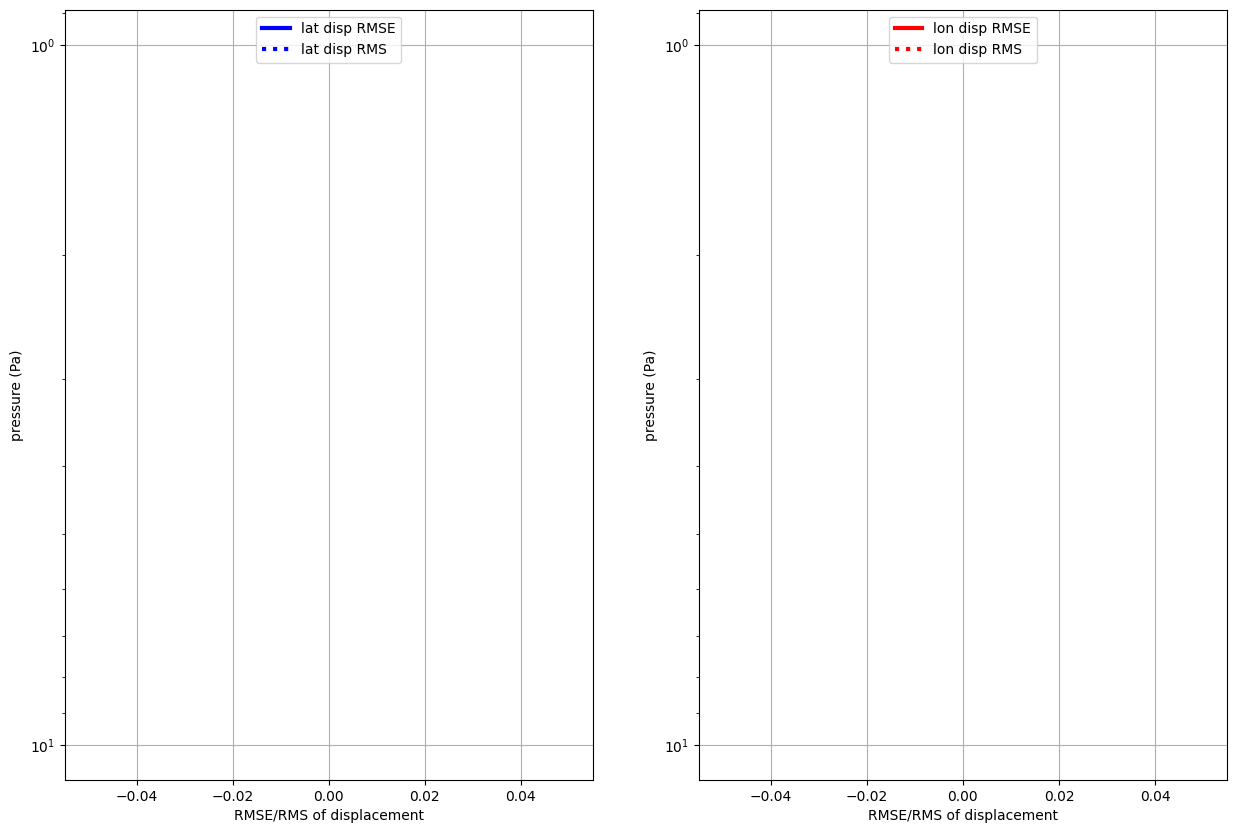

In [5]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

In [11]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    bc = 0
    
    
    rmse_total_lat = []
    rmse_total_lon = []
    rmse_total_lat_1 = []
    rmse_total_lon_1 = []
    
    rmse_sum_lon_1={}
    rmse_sum_lat_1={}
    rmse_sum_lon_2={}
    rmse_sum_lat_2={}
    rms_sum_lon_0={}
    rms_sum_lat_0={}

#     rms_sum_lon_1={}
#     rms_sum_lat_1={}
#     rms_sum_lon_2={}
#     rms_sum_lat_2={}
    stdplevs = [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000]

    for i in stdplevs:
        rmse_sum_lon_1[i] = []
        rmse_sum_lat_1[i] = []
        rmse_sum_lon_2[i] = []
        rmse_sum_lat_2[i] = []
        rms_sum_lon_0[i] = []
        rms_sum_lat_0[i] = []
#         rms_sum_lon_1[i] = []
#         rms_sum_lat_1[i] = []
#         rms_sum_lon_2[i] = []
#         rms_sum_lat_2[i] = []
        
    while 1:
        try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
    #         print (codes_get_array(bufr,'dataSubCategory'))
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
    #             print('not 109')
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)
    #         print('iterid ', iterid)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
    #         print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

    #             print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            try:
                data = pd.DataFrame.from_dict(output)
                cont = True
            except:
                cont = False
            if cont:
                if data.pressure[0] < 40000:
                    u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                    data['u'] = u
                    v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                    data['v'] = v
                    data = data[data.airTemperature < 350]
                    data = data[data.airTemperature > 180]
                    data = data.drop_duplicates(['pressure'])

                    true_latd = data.latitudeDisplacement
                    true_lond = data.longitudeDisplacement


                    lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', factor=1)
                    lat_displacement_test1, lon_displacement_test1 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), z_variant='ucar', u_factor=0.83, v_factor = 1.15)

    #                 reduced = data[numpy.isin(data.pressure, [100000,92500,85000,70000,50000,40000,30000,25000,20000,15000,10000,7000,5000,3000,2000,1000])]
    #                 reduced_lat_displacement, reduced_lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))


                    rmse_total_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                    rmse_total_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))
                    if (rmse_total_lat[-1] > 3) or (rmse_total_lon[-1] > 3):
                        print('not a valid station')
                        continue


                    print(output['lat'], output['lon'], output['datum'], output['timePeriod'])
                    for i in range(len(stdplevs)):
                        if i > 0:
                            b = np.array(true_latd)
                            c = np.array(true_lond)
                            b[data.pressure < stdplevs[i]] = np.nan
                            c[data.pressure >= stdplevs[i-1]] = np.nan
                            b[data.pressure < stdplevs[i]] = np.nan
                            c[data.pressure >= stdplevs[i-1]] = np.nan
                            rms_sum_lat_0[stdplevs[i]].append( np.nanmean(b[~np.isnan(b)]))
                            rms_sum_lon_0[stdplevs[i]].append( np.nanmean(c[~np.isnan(c)]))

                            a = np.array(lon_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
    #                         rms_sum_lon_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lat_displacement_100)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
    #                         rms_sum_lat_1[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                            a = np.array(lon_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_lond[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
    #                         rms_sum_lon_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))
    #                         
                            a = np.array(lat_displacement_test1)
                            a[data.pressure < stdplevs[i]] = np.nan
                            a[data.pressure >= stdplevs[i-1]] = np.nan
                            rmse_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]) - np.nanmean(true_latd[data.pressure > stdplevs[i]][data.pressure <= stdplevs[i-1]]))
    #                         rms_sum_lat_2[stdplevs[i]].append( np.nanmean(a[~np.isnan(a)]))

                    fig, ax1 = maplt.subplots()
                    ax1.plot(data.pressure,np.array(lat_displacement_100),color = 'blue', label='calc lat disp 100')
                    ax1.plot(data.pressure,np.array(lon_displacement_100),color = 'red', label='calc lon disp 100')
    #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                    ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                    ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                    ax1.set_xlabel('pressure (Pa)')
                    ax1.set_ylabel('displacement (°)')
                    ax1.tick_params(axis='y')

    #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    #                 ax2.plot(data.pressure,data.u, label='u')
    #                 ax2.plot(data.pressure,data.v, label='v')
    #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    #                 ax2.tick_params(axis='y',)

                    fig.tight_layout()  # otherwise the right y-label is slightly clipped
                    maplt.title('height calc different wind application factors')
                    maplt.legend()
                    maplt.grid()
                    maplt.show()
                    maplt.close()

                    print('lat disp rmse: ',rmse_total_lat[-1])
                    print('lon disp rmse: ',rmse_total_lon[-1])


                    fig, ax1 = maplt.subplots()
                    ax1.plot(data.pressure,np.array(lat_displacement_test1),color = 'blue', label='calc lat disp test1')
                    ax1.plot(data.pressure,np.array(lon_displacement_test1),color = 'red', label='calc lon disp test1')
    #                 plt.plot(reduced.pressure,np.array(reduced_lat_displacement),color = 'cyan', alpha = 0.7, label='reduced calc lat disp')
    #                 plt.plot(reduced.pressure,np.array(reduced_lon_displacement),color = 'orange', alpha = 0.7, label='reduced calc lon disp')
                    ax1.plot(data.pressure,data.latitudeDisplacement,color = 'blue', alpha = 0.3, label='original lat disp')
                    ax1.plot(data.pressure,data.longitudeDisplacement, color = 'red', alpha = 0.3, label='original lon disp')
                    ax1.set_xlabel('pressure (Pa)')
                    ax1.set_ylabel('displacement (°)')
                    ax1.tick_params(axis='y')

    #                 ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    # #                 ax2.plot(data.pressure,data.airTemperature,color = 'orange', label='temperature')
    # #                 ax2.set_ylabel('temperature (K)')  # we already handled the x-label with ax1
    #                 ax2.plot(data.pressure,data.u, label='u')
    #                 ax2.plot(data.pressure,data.v, label='v')
    #                 ax2.set_ylabel('u/v (m/s)')  # we already handled the x-label with ax1
    #                 ax2.tick_params(axis='y',)

                    fig.tight_layout()  # otherwise the right y-label is slightly clipped
                    maplt.title('height calc different wind application factors')
                    maplt.legend()
                    maplt.grid()
                    maplt.show()
                    maplt.close()

                    rmse_total_lat_1.append(np.sqrt(np.nanmean((np.array(lat_displacement_test1)-true_latd)**2)))
                    rmse_total_lon_1.append(np.sqrt(np.nanmean((np.array(lon_displacement_test1)-true_lond)**2)))
                    print('lat disp rmse: ',rmse_total_lat_1[-1])
                    print('lon disp rmse: ',rmse_total_lon_1[-1])


                    print('----------------')

                    bc += 1
        except:
            pass
        if bc > 100:
            break
    
    rmse_lat_1 = []
    rmse_lon_1 = []
    rmse_lat_2 = []
    rmse_lon_2 = []
    
    rms_lat_0 = []
    rms_lon_0 = []
#     rms_lon_1 = []
#     rms_lon_1 = []
#     rms_lat_1 = []
#     rms_lon_1 = []
#     rms_lat_2 = []
#     rms_lon_2 = []
    for i in range(len(stdplevs)):
        if i > 0:
            rmse_lat_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_1[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_1[-1])
            rmse_lon_1.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_1[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_1[-1])
            rmse_lat_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lat_2[stdplevs[i]])**2))))
            print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lat_2[-1])
            rmse_lon_2.append(np.sqrt(np.nanmean((np.array(rmse_sum_lon_2[stdplevs[i]])**2))))
            print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMSE: ', rmse_lon_2[-1])
            
            rms_lat_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_0[stdplevs[i]])**2))))
            print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
            rms_lon_0.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_0[stdplevs[i]])**2))))
            print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])

            
#             rms_lat_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_1[stdplevs[i]])**2))))
#             print('Latitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_1[-1])
#             rms_lon_1.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_1[stdplevs[i]])**2))))
#             print('Longitude Displacement data set 1 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_1[-1])
#             rms_lat_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lat_2[stdplevs[i]])**2))))
#             print('Latitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lat_2[-1])
#             rms_lon_2.append(np.sqrt(np.nanmean((np.array(rms_sum_lon_2[stdplevs[i]])**2))))
#             print('Longitude Displacement data set 2 - plev: ', stdplevs[i], ' RMS: ', rmse_lon_2[-1])
            
    fig, ax1 = maplt.subplots(1, 2, figsize = (15,10))
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_1),color = 'blue',alpha = 0.3, label='lat RMSE disp 1')
    ax1[0].plot(stdplevs[1:],np.array(rmse_lat_2),color = 'blue', label='lat RMSE disp 2')
    ax1[0].plot(stdplevs[1:],np.array(rms_lat_0),color = 'blue', linestyle = 'dotted', label='lat RMS disp')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_1),color = 'blue', linestyle = 'dotted', alpha = 0.3, label='lat RMS disp 1')
#     ax1[0].plot(stdplevs[1:],np.array(rms_lat_2),color = 'blue', linestyle = 'dotted', label='lat RMS disp 2')
    ax1[0].set_xlabel('pressure (Pa)')
    ax1[0].set_ylabel('RMSE/RMS of displacement')
    ax1[0].legend()
    ax1[0].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_1),color = 'red',alpha = 0.3, label='lon RMSE disp 1')
    ax1[1].plot(stdplevs[1:],np.array(rmse_lon_2),color = 'red', label='lon RMSE disp 2')
    ax1[1].plot(stdplevs[1:],np.array(rms_lon_0),color = 'red', linestyle = 'dotted', label='lon RMS disp')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_1),color = 'red', linestyle = 'dotted', alpha = 0.3, label='lon RMS disp 1')
#     ax1[1].plot(stdplevs[1:],np.array(rms_lon_2),color = 'red', linestyle = 'dotted', label='lon RMS disp 2')
    ax1[1].set_xlabel('pressure (Pa)')
    ax1[1].set_ylabel('RMSE/RMS of displacement')
    ax1[1].legend()
    ax1[1].grid()
    maplt.title('LEVEL RMSE/RMS for Displacement')
    maplt.show()
    maplt.close()
    
#     print('data set 1: ',np.median(rmse_total_lat), np.median(rmse_total_lon))
#     print('data set 2: ',np.median(rmse_total_lat_1), np.median(rmse_total_lon_1))
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(names, values)
axs[1].scatter(names, values)
axs[2].plot(names, values)

<_io.TextIOWrapper name='./out.bufr' mode='r' encoding='UTF-8'>
43.06 -108.48 19201130.0 230100.0


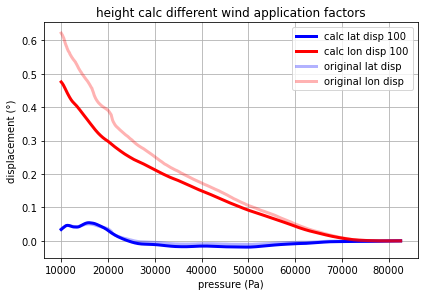

lat disp rmse:  0.00498653684496597
lon disp rmse:  0.07086273256490315


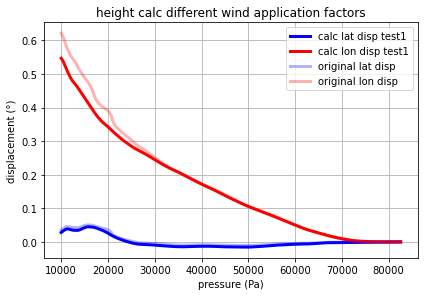

lat disp rmse:  0.0052443999719619045
lon disp rmse:  0.03425626472122954
----------------
35.040000000000006 -106.62 19201130.0 230300.0


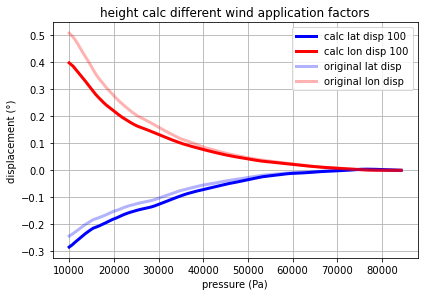

lat disp rmse:  0.02318725593415237
lon disp rmse:  0.05166604816216149


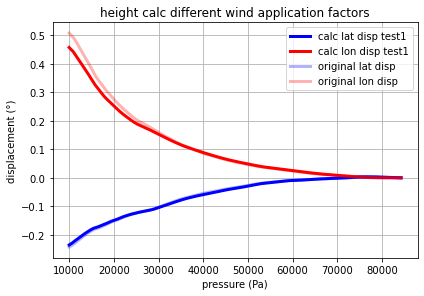

lat disp rmse:  0.0036127781678991513
lon disp rmse:  0.022875329983819418
----------------
37.760000000000005 -99.97000000000001 19201130.0 230100.0


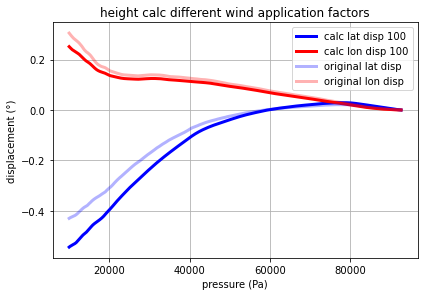

lat disp rmse:  0.06780080711199972
lon disp rmse:  0.022470666260192784


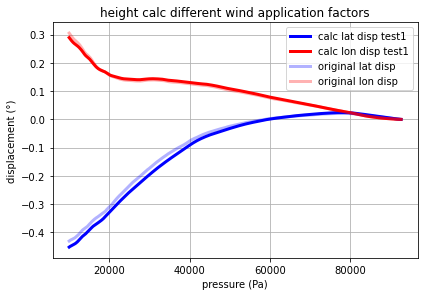

lat disp rmse:  0.017014257339044717
lon disp rmse:  0.005766063995573028
----------------
40.86000000000001 -115.74000000000001 19201130.0 230300.0


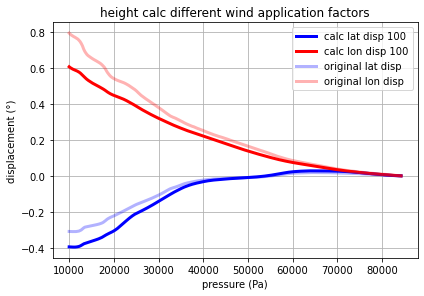

lat disp rmse:  0.05444139474975005
lon disp rmse:  0.09231758421960976


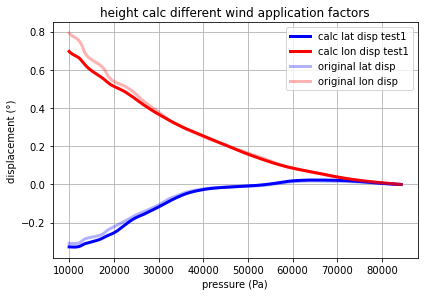

lat disp rmse:  0.015870483826508606
lon disp rmse:  0.04039571847578099
----------------
39.120000000000005 -108.53000000000002 19201130.0 230100.0


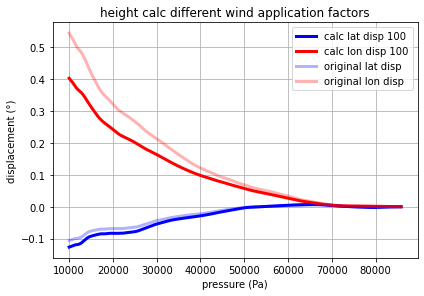

lat disp rmse:  0.011617657626388615
lon disp rmse:  0.06943284114807197


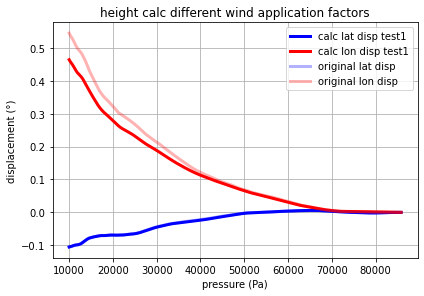

lat disp rmse:  0.0008567447252423573
lon disp rmse:  0.03856413219411597
----------------
39.42 -83.82000000000001 19201130.0 230500.0


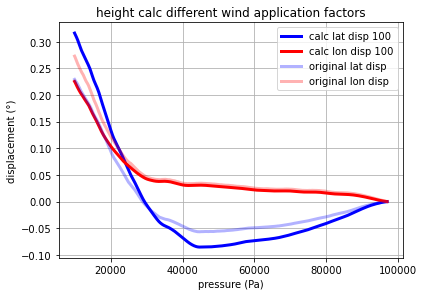

lat disp rmse:  0.041859085661555315
lon disp rmse:  0.020176167884819966


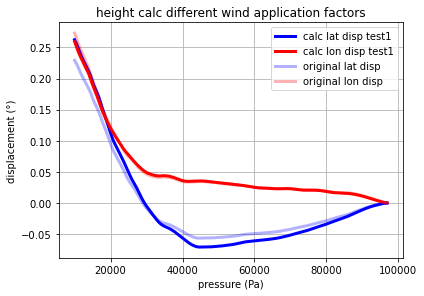

lat disp rmse:  0.017118669542169212
lon disp rmse:  0.005284743240174432
----------------
40.150000000000006 -89.34 19201130.0 230100.0


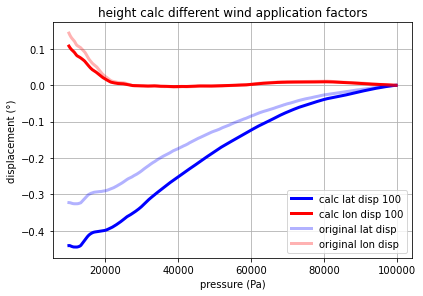

lat disp rmse:  0.0865527380053849
lon disp rmse:  0.012776691250682702


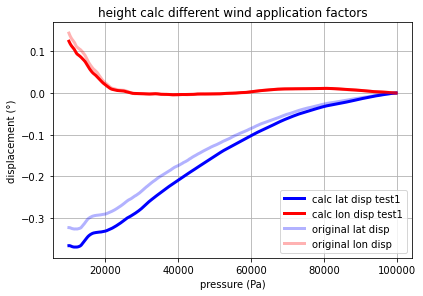

lat disp rmse:  0.0341422877892504
lon disp rmse:  0.007455402341653675
----------------
13.48 144.79000000000002 19201130.0 230100.0


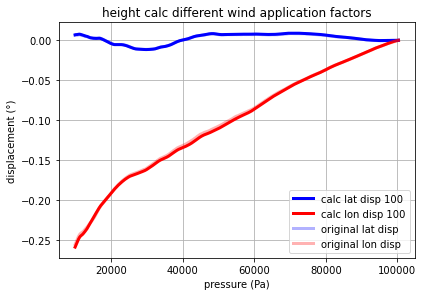

lat disp rmse:  0.0003719870487845598
lon disp rmse:  0.0019087156778020572


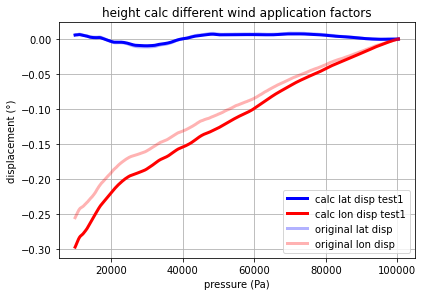

lat disp rmse:  0.000875005309503114
lon disp rmse:  0.024371368746628805
----------------
40.53 -80.22000000000001 19201130.0 230800.0


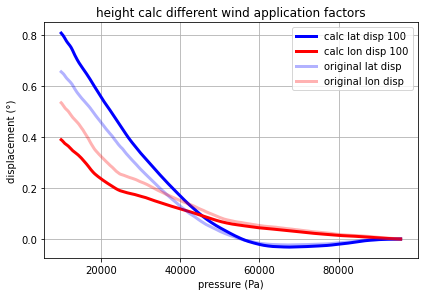

lat disp rmse:  0.07934810175040206
lon disp rmse:  0.0732179600223062


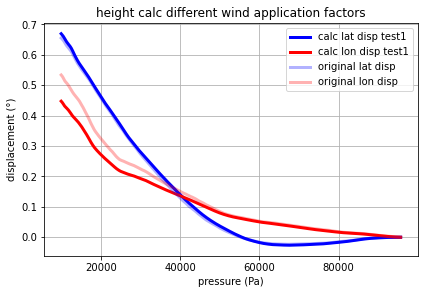

lat disp rmse:  0.007228703034713357
lon disp rmse:  0.04320035844125975
----------------
27.71 -82.4 19201130.0 230300.0


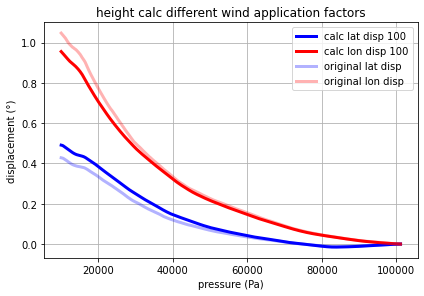

lat disp rmse:  0.03746812395278179
lon disp rmse:  0.04703097478087676


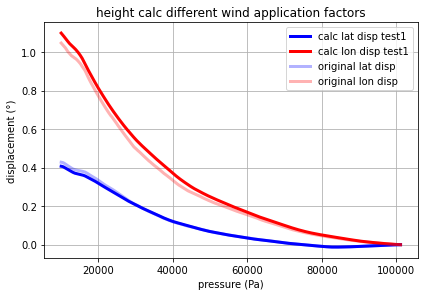

lat disp rmse:  0.010370966585329275
lon disp rmse:  0.03486381281776224
----------------
34.84 -92.26 19201130.0 231100.0


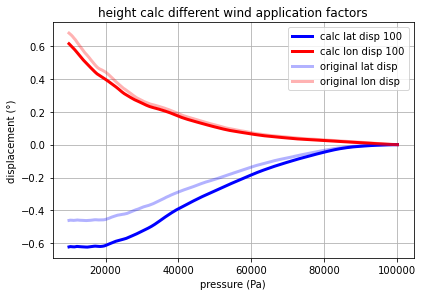

lat disp rmse:  0.11891145650095268
lon disp rmse:  0.03264043158753544


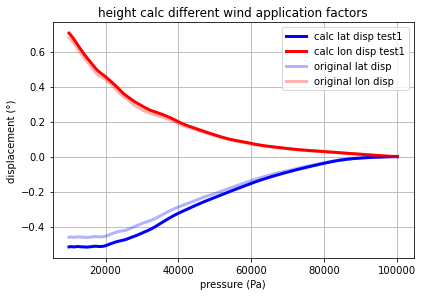

lat disp rmse:  0.04155266695527802
lon disp rmse:  0.015081984324851092
----------------
36.25 -86.56 19201130.0 230700.0


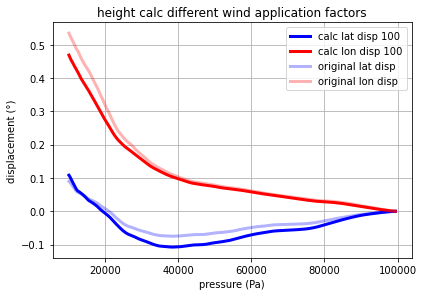

lat disp rmse:  0.020427525736876506
lon disp rmse:  0.03375081440819628


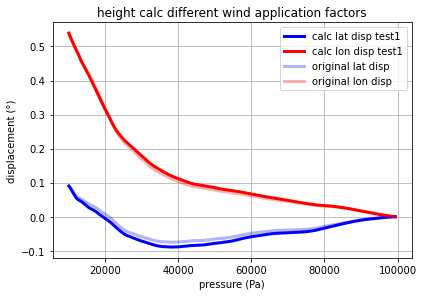

lat disp rmse:  0.010623533352831574
lon disp rmse:  0.005798514425500542
----------------
35.230000000000004 -101.71000000000001 19201130.0 230600.0


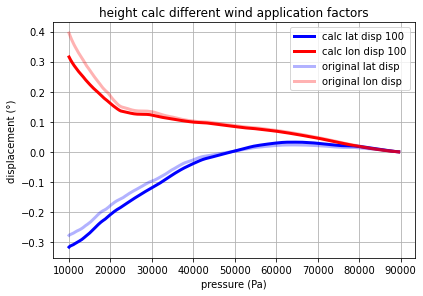

lat disp rmse:  0.0241064439245392
lon disp rmse:  0.029641660858303834


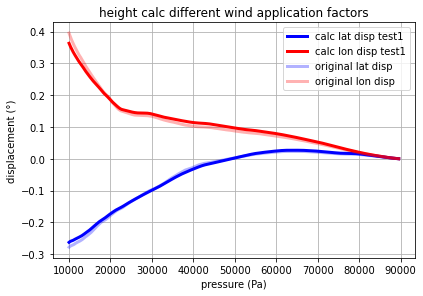

lat disp rmse:  0.006769394841289102
lon disp rmse:  0.01154738312549018
----------------
47.68000000000001 -117.63000000000001 19201130.0 230400.0


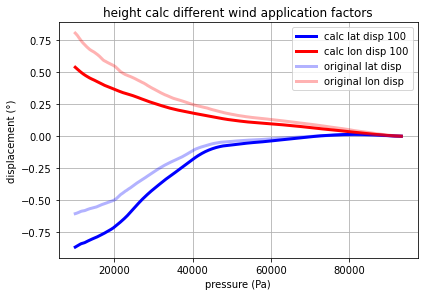

lat disp rmse:  0.15761268016758578
lon disp rmse:  0.14011579786819195


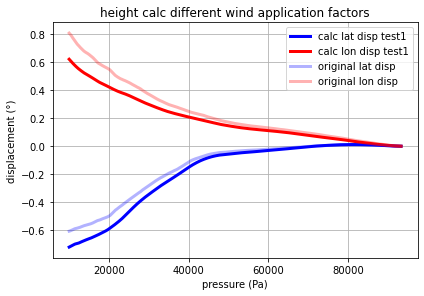

lat disp rmse:  0.07037793368494263
lon disp rmse:  0.0959308014714192
----------------
42.940000000000005 -78.72000000000001 19201130.0 231300.0


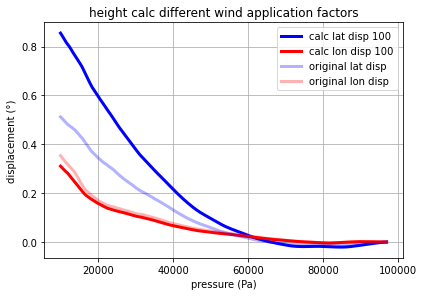

lat disp rmse:  0.1897747333473205
lon disp rmse:  0.018159476947631318


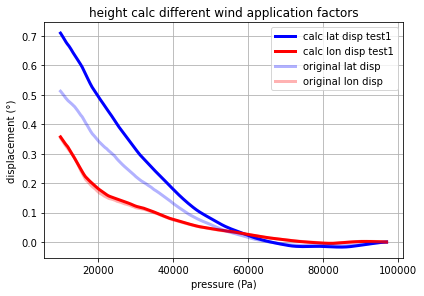

lat disp rmse:  0.11059705874320121
lon disp rmse:  0.004808809349829735
----------------
27.78 -97.51 19201130.0 230800.0


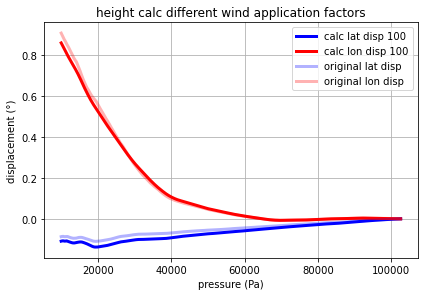

lat disp rmse:  0.020884582455344594
lon disp rmse:  0.022433735751924085


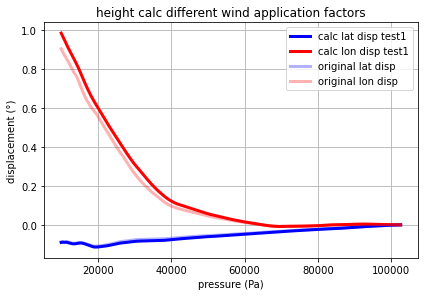

lat disp rmse:  0.005158152032376489
lon disp rmse:  0.043029380628441055
----------------
31.94 -102.19000000000001 19201130.0 230300.0


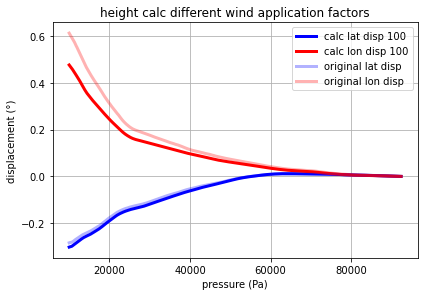

lat disp rmse:  0.009999734133694276
lon disp rmse:  0.06074310719153026


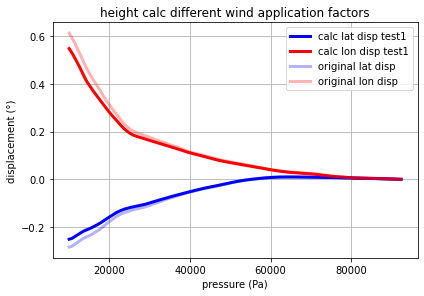

lat disp rmse:  0.016377956407506
lon disp rmse:  0.028826291220636863
----------------
32.32 -90.08000000000001 19201130.0 230600.0


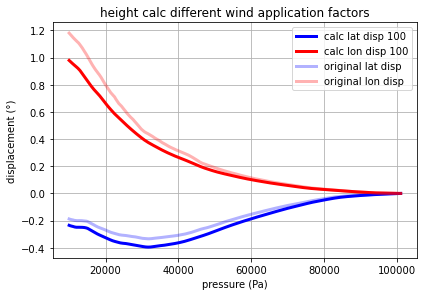

lat disp rmse:  0.04693739402559307
lon disp rmse:  0.10519892249877577


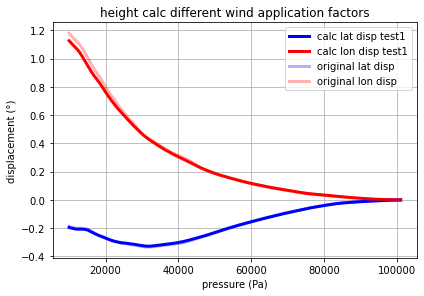

lat disp rmse:  0.004211083517511781
lon disp rmse:  0.02861077299481279
----------------
44.85 -93.56 19201130.0 230300.0


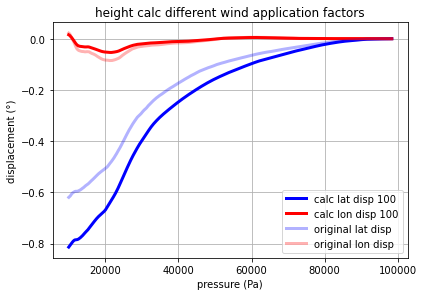

lat disp rmse:  0.11896082645240035
lon disp rmse:  0.014991486548417672


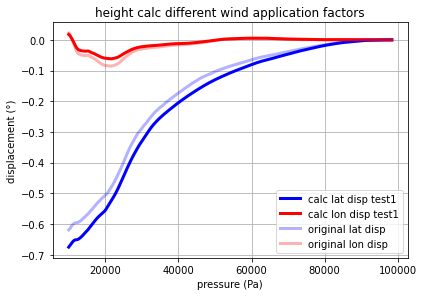

lat disp rmse:  0.03811364103208548
lon disp rmse:  0.01111911303521906
----------------
19.720000000000002 -155.06 19201130.0 230300.0


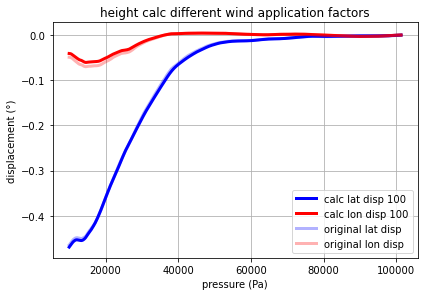

lat disp rmse:  0.002623125149234603
lon disp rmse:  0.00534624339437167


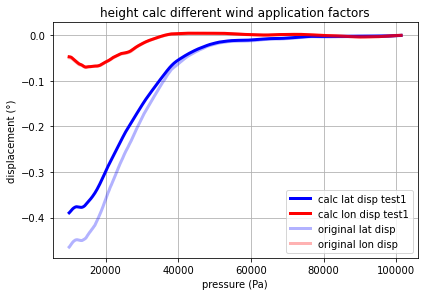

lat disp rmse:  0.041164973448724315
lon disp rmse:  0.0008345255111776474
----------------
32.900000000000006 -80.03 19201130.0 230600.0


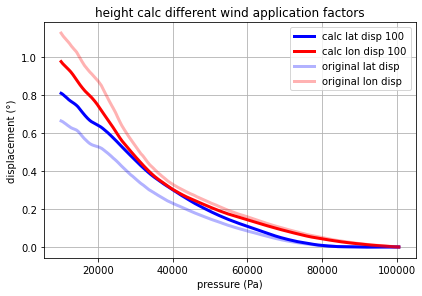

lat disp rmse:  0.08833341724511705
lon disp rmse:  0.08360920541004198


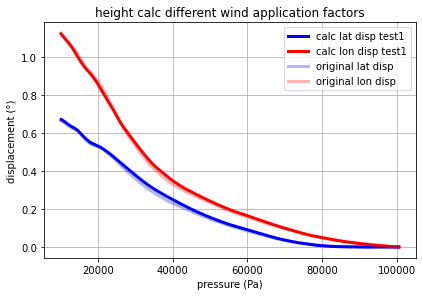

lat disp rmse:  0.010535613818602725
lon disp rmse:  0.010903465215251682
----------------
44.07 -103.21000000000001 19201130.0 230600.0


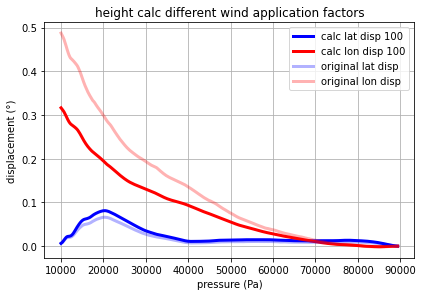

lat disp rmse:  0.008182114307794574
lon disp rmse:  0.0847961369476892


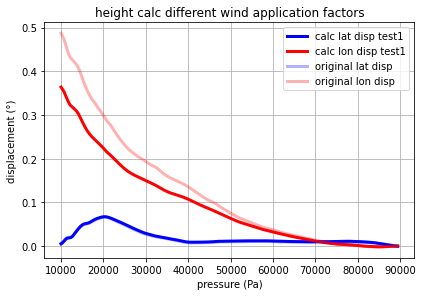

lat disp rmse:  0.0015001320390629334
lon disp rmse:  0.060836346295372025
----------------
not a valid station
-14.340000000000002 -170.72000000000003 19201130.0 230100.0


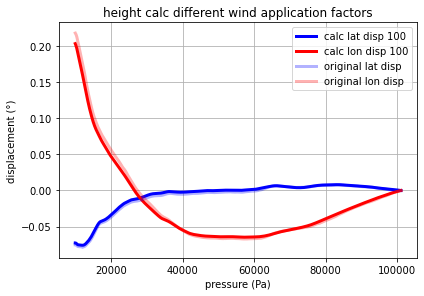

lat disp rmse:  0.002456614377010621
lon disp rmse:  0.006947480441044442


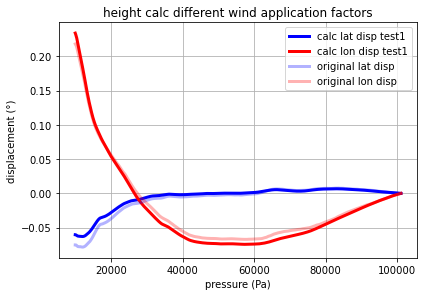

lat disp rmse:  0.0070327422962252915
lon disp rmse:  0.006743178888668186
----------------
40.77 -111.96000000000001 19201130.0 230600.0


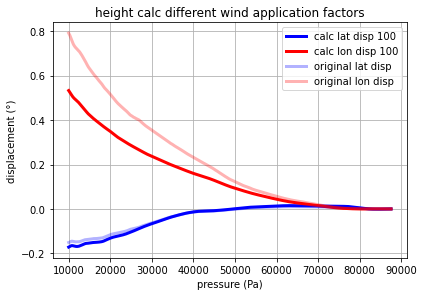

lat disp rmse:  0.010991304911267727
lon disp rmse:  0.1353575546979846


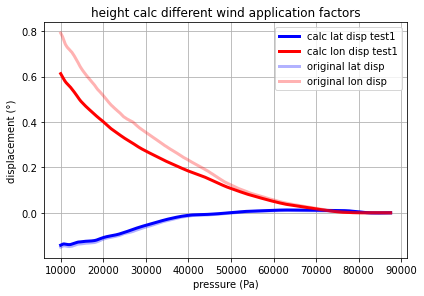

lat disp rmse:  0.005980429932055945
lon disp rmse:  0.09345746399272639
----------------
not a valid station
48.21 -106.63000000000001 19201130.0 230100.0


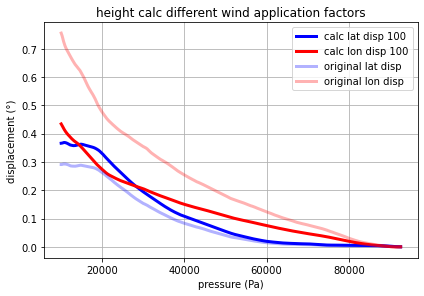

lat disp rmse:  0.045833274897638776
lon disp rmse:  0.16509777344390075


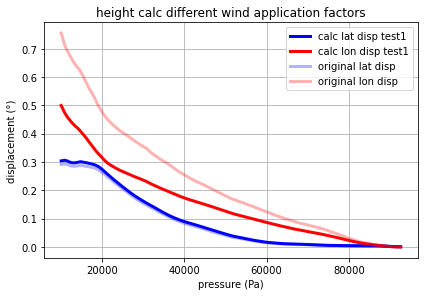

lat disp rmse:  0.0078247092477825
lon disp rmse:  0.13136386556728044
----------------
46.77 -100.76 19201130.0 230800.0


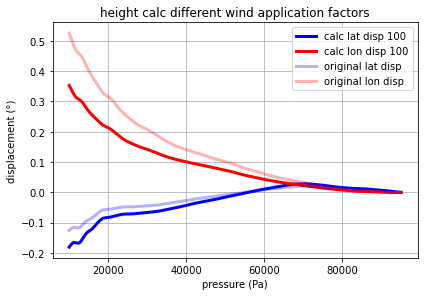

lat disp rmse:  0.02550056925444472
lon disp rmse:  0.08361217424793718


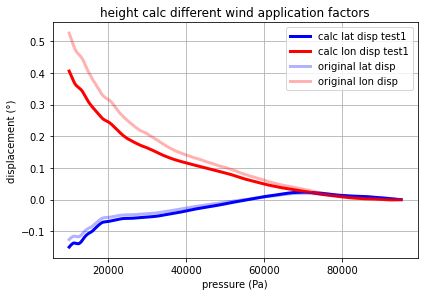

lat disp rmse:  0.011585466068138523
lon disp rmse:  0.05774089623526969
----------------
32.230000000000004 -110.96000000000001 19201130.0 230300.0


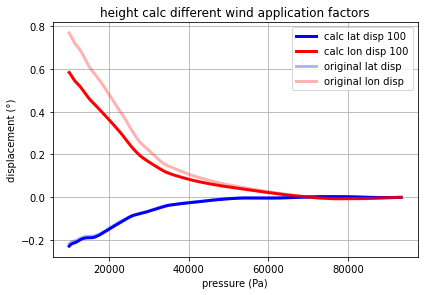

lat disp rmse:  0.0038873762397448903
lon disp rmse:  0.08943610655815072


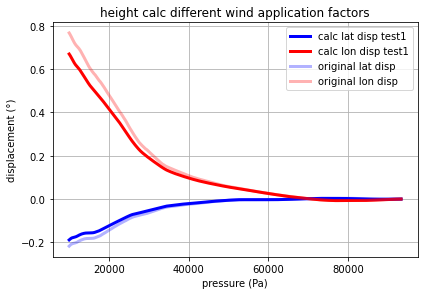

lat disp rmse:  0.01476743968359643
lon disp rmse:  0.048148841861988326
----------------
35.230000000000004 -111.82000000000001 19201130.0 231900.0


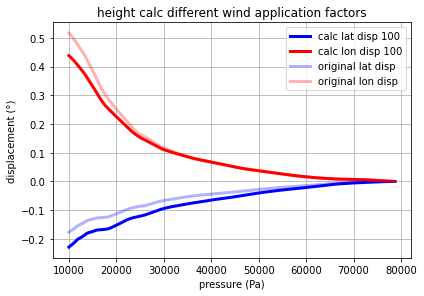

lat disp rmse:  0.031918939398148306
lon disp rmse:  0.03414615455159772


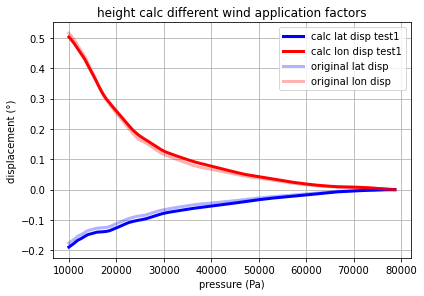

lat disp rmse:  0.010940469288386212
lon disp rmse:  0.00824662626537529
----------------
32.84 -97.30000000000001 19201130.0 230900.0


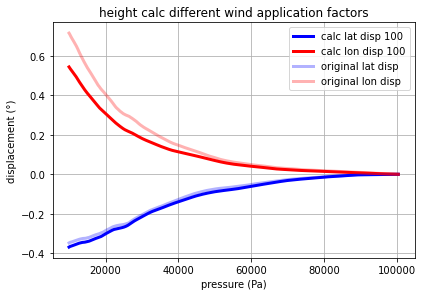

lat disp rmse:  0.013361798977312269
lon disp rmse:  0.07942363554147507


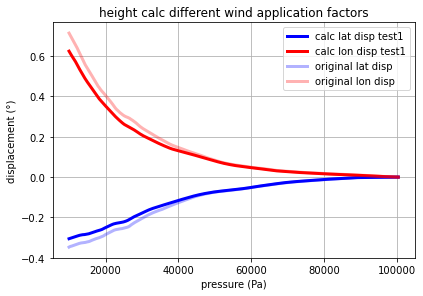

lat disp rmse:  0.024820432962397717
lon disp rmse:  0.04203070758099929
----------------
30.480000000000004 -81.7 19201130.0 231000.0


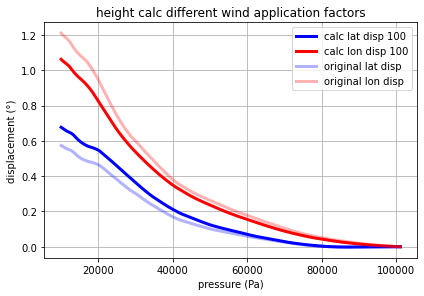

lat disp rmse:  0.06108306486845058
lon disp rmse:  0.0810971870201555


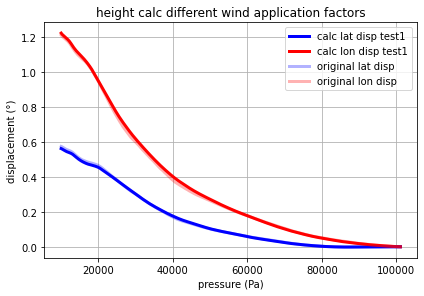

lat disp rmse:  0.006247760134748256
lon disp rmse:  0.011934453208665426
----------------
42.7 -83.47000000000001 19201130.0 230700.0


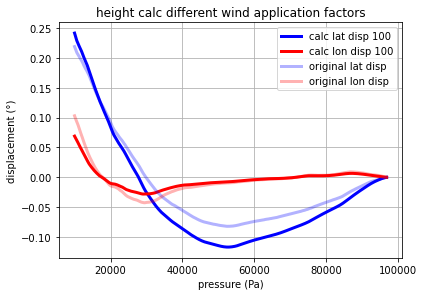

lat disp rmse:  0.02200549220548437
lon disp rmse:  0.01076776327565416


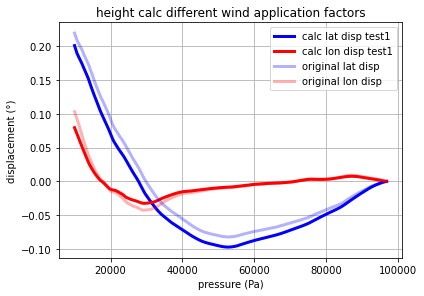

lat disp rmse:  0.01750070618517436
lon disp rmse:  0.007600975030297588
----------------
37.230000000000004 -93.4 19201130.0 231200.0


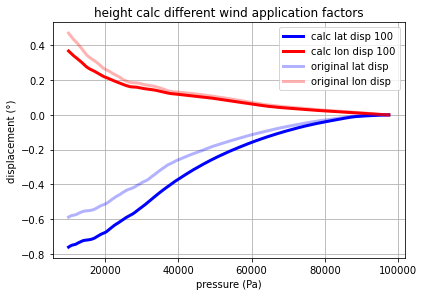

lat disp rmse:  0.12665883491169744
lon disp rmse:  0.044439345283977846


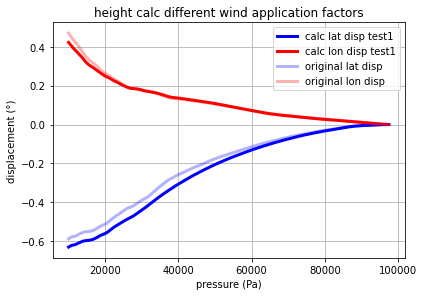

lat disp rmse:  0.040032325810523496
lon disp rmse:  0.017790131562631085
----------------
30.450000000000003 -84.30000000000001 19201130.0 230400.0


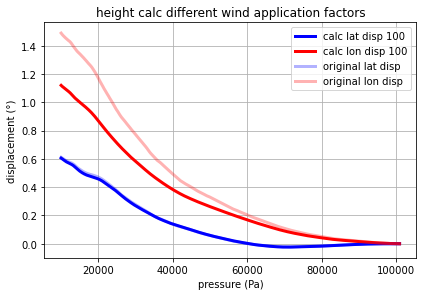

lat disp rmse:  0.007170305950383742
lon disp rmse:  0.21031694326415218


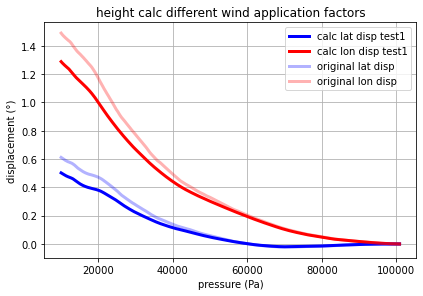

lat disp rmse:  0.061207953518553675
lon disp rmse:  0.11595609983324975
----------------
39.57 -119.80000000000001 19201130.0 232400.0


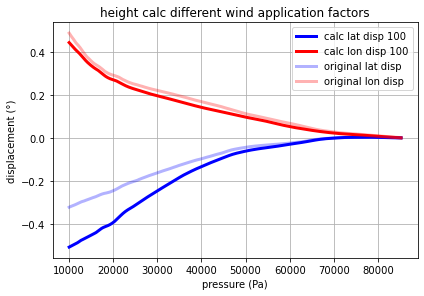

lat disp rmse:  0.1067882453622721
lon disp rmse:  0.02221461924320045


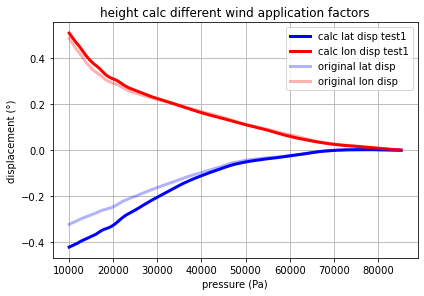

lat disp rmse:  0.05746678675931889
lon disp rmse:  0.015441984688127991
----------------
47.46 -111.38000000000001 19201130.0 231800.0


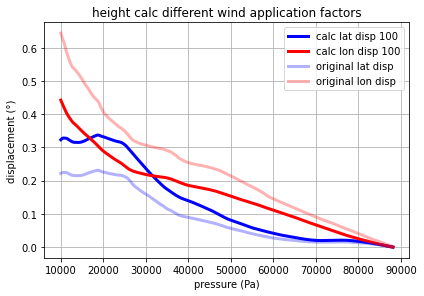

lat disp rmse:  0.07419784446834324
lon disp rmse:  0.10552678341240823


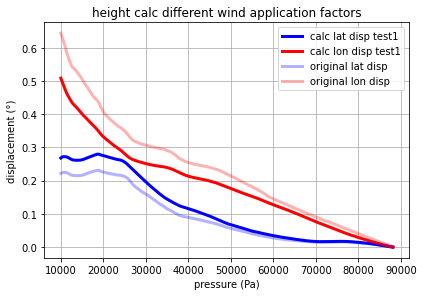

lat disp rmse:  0.03462061027503138
lon disp rmse:  0.06866416954909249
----------------
-28.8 114.7 19201130.0 231400.0


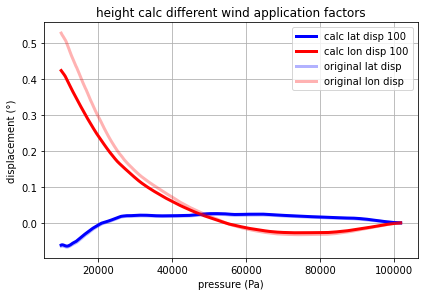

lat disp rmse:  0.002313762112518586
lon disp rmse:  0.046522778780970706


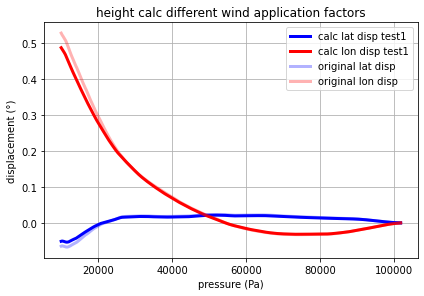

lat disp rmse:  0.0057981835809721065
lon disp rmse:  0.017547849054189844
----------------
43.89 -70.26 19201130.0 232100.0


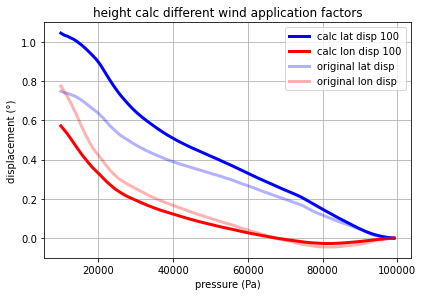

lat disp rmse:  0.1818901505753585
lon disp rmse:  0.08960312923651458


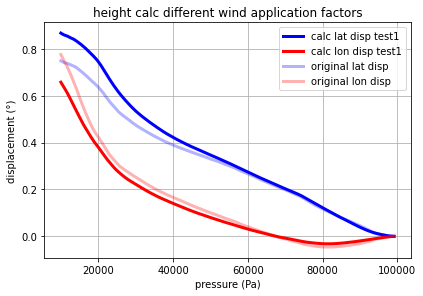

lat disp rmse:  0.07081286972778075
lon disp rmse:  0.04990482910312151
----------------
44.50000000000001 -88.11000000000001 19201130.0 231900.0


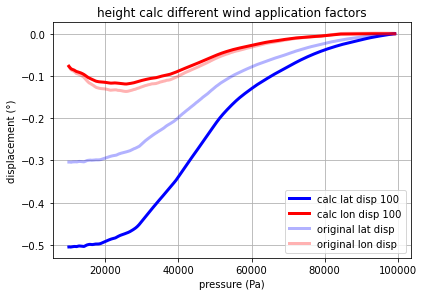

lat disp rmse:  0.15527722234698071
lon disp rmse:  0.01071919205247419


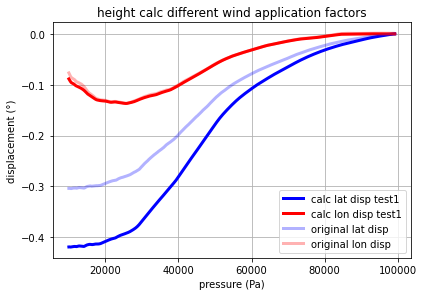

lat disp rmse:  0.08998288440409552
lon disp rmse:  0.0039486267122861695
----------------
41.13 -100.7 19201130.0 230800.0


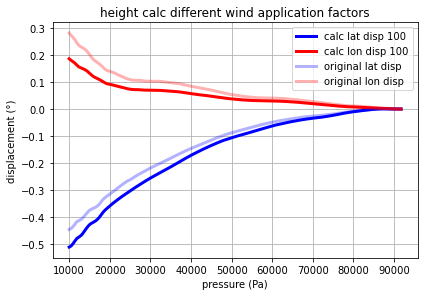

lat disp rmse:  0.036749572707200355
lon disp rmse:  0.043108593338000135


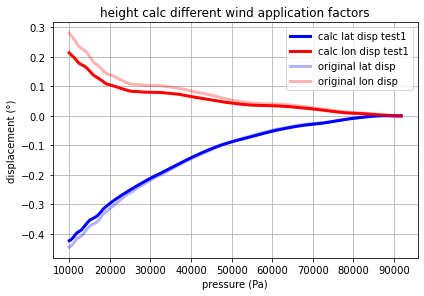

lat disp rmse:  0.011567850556906628
lon disp rmse:  0.030347381872102102
----------------
33.18 -86.78 19201130.0 231800.0


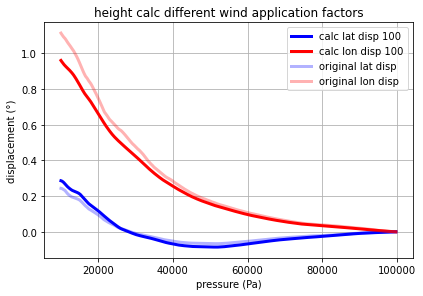

lat disp rmse:  0.02126305878086116
lon disp rmse:  0.07446642743290134


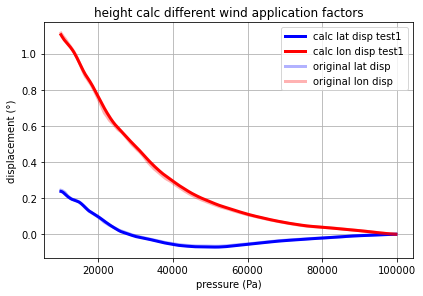

lat disp rmse:  0.0033564384283698958
lon disp rmse:  0.009321524933850448
----------------
not a valid station
not a valid station
36.050000000000004 -115.18 19201130.0 231500.0


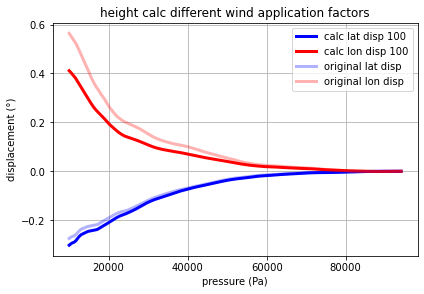

lat disp rmse:  0.013109220815297952
lon disp rmse:  0.06743968811501605


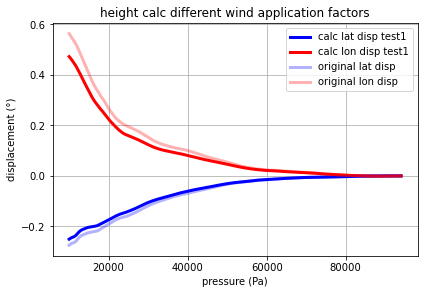

lat disp rmse:  0.013379855597301997
lon disp rmse:  0.04102709524305864
----------------
31.87 -106.7 19201130.0 232400.0


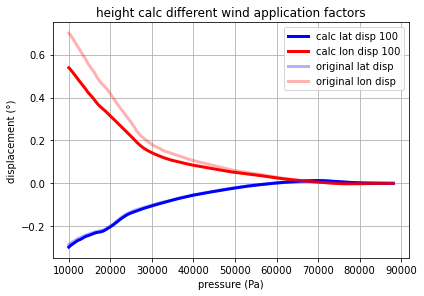

lat disp rmse:  0.004586931975587921
lon disp rmse:  0.07884791051251394


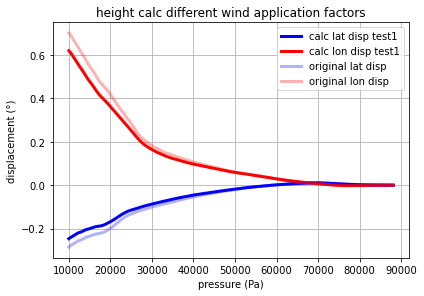

lat disp rmse:  0.021143581478199638
lon disp rmse:  0.04085879848389108
----------------
not a valid station
not a valid station
not a valid station
not a valid station
41.660000000000004 -69.96000000000001 19201130.0 232500.0


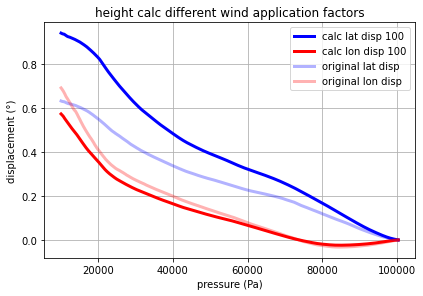

lat disp rmse:  0.1993734081763474
lon disp rmse:  0.054407020608515655


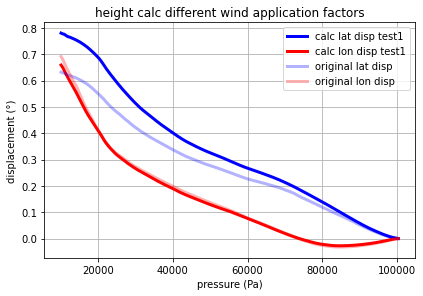

lat disp rmse:  0.09492240099874968
lon disp rmse:  0.012353518977627877
----------------
28.39 129.55 19201130.0 233100.0


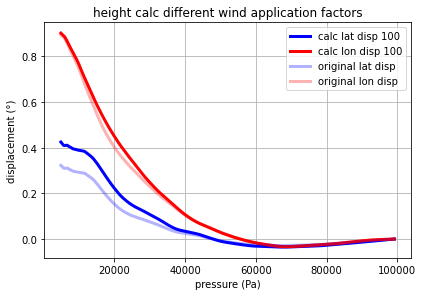

lat disp rmse:  0.061134412660800205
lon disp rmse:  0.02308313223677396


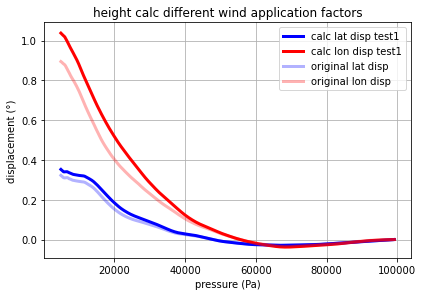

lat disp rmse:  0.021395144707155395
lon disp rmse:  0.0890235804538434
----------------
-28.8 114.7 19201130.0 231400.0


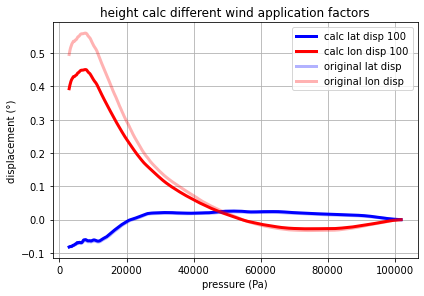

lat disp rmse:  0.0022932378537085917
lon disp rmse:  0.06785435840605855


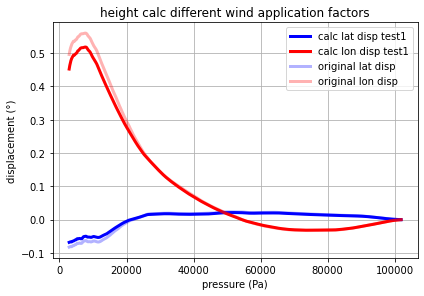

lat disp rmse:  0.00864877411303145
lon disp rmse:  0.026149858840895802
----------------
28.39 129.55 19201130.0 233100.0


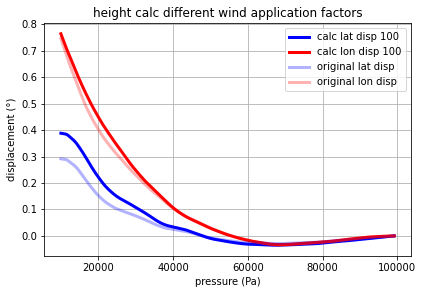

lat disp rmse:  0.05160582188953934
lon disp rmse:  0.024515688441315634


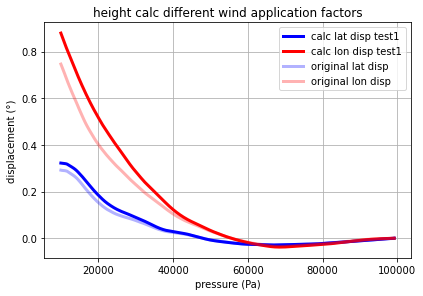

lat disp rmse:  0.01945044448340419
lon disp rmse:  0.07705835190552313
----------------
40.870000000000005 -72.86 19201130.0 234000.0


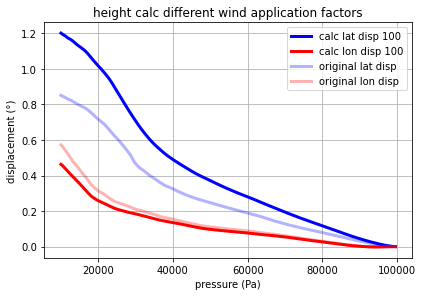

lat disp rmse:  0.22696215293378347
lon disp rmse:  0.04867343026553078


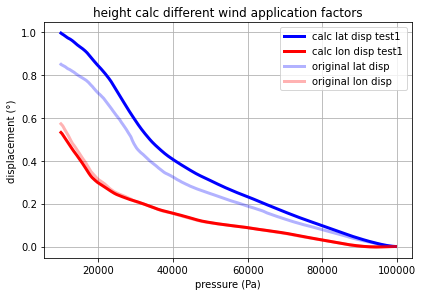

lat disp rmse:  0.09941536637155815
lon disp rmse:  0.015757365781761727
----------------
not a valid station
not a valid station
not a valid station
46.870000000000005 -68.01 19201130.0 233000.0


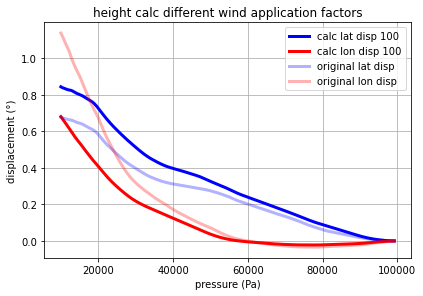

lat disp rmse:  0.10783599862504202
lon disp rmse:  0.20664365606762936


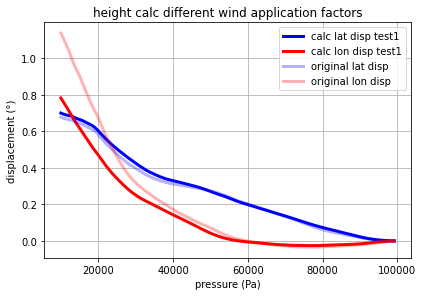

lat disp rmse:  0.018441927081868037
lon disp rmse:  0.15915450416273477
----------------
not a valid station
not a valid station
34.78 -76.88000000000001 19201130.0 235000.0


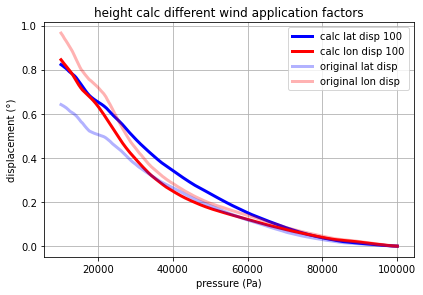

lat disp rmse:  0.11108160315145844
lon disp rmse:  0.062107818853348304


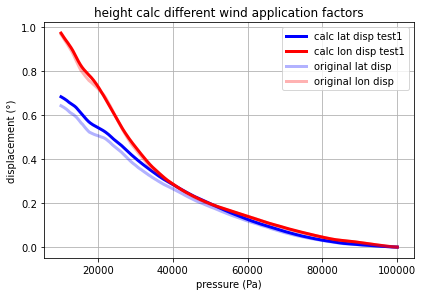

lat disp rmse:  0.027640083971390776
lon disp rmse:  0.009158029951954081
----------------
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a valid station
not a val

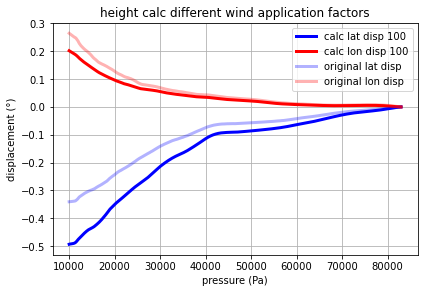

lat disp rmse:  0.08966311499756813
lon disp rmse:  0.028212292740317144


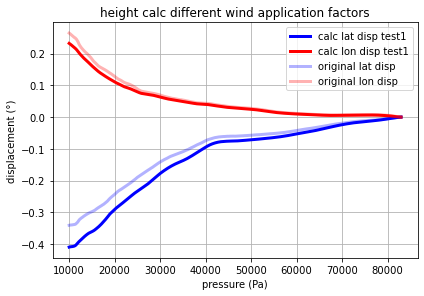

lat disp rmse:  0.041347400686512506
lon disp rmse:  0.01444029448566624
----------------
33.36 -84.57000000000001 19201201.0 110000.0


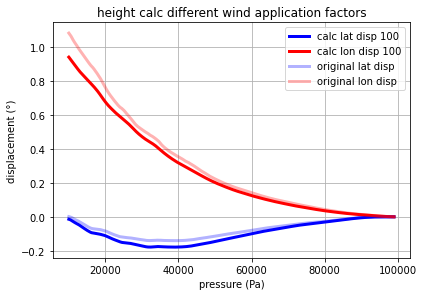

lat disp rmse:  0.026234880044670086
lon disp rmse:  0.07022808855047531


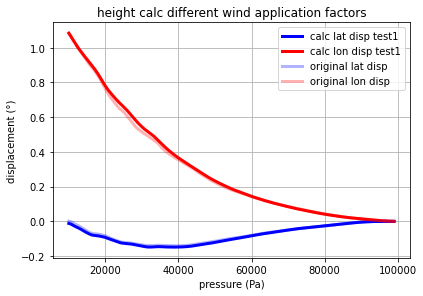

lat disp rmse:  0.007711729513126444
lon disp rmse:  0.015801543550428128
----------------
not a valid station
34.84 -92.26 19201201.0 110800.0


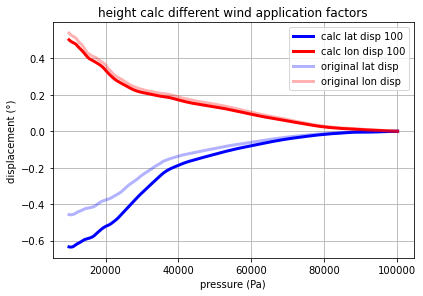

lat disp rmse:  0.10502154279287615
lon disp rmse:  0.019532058694069074


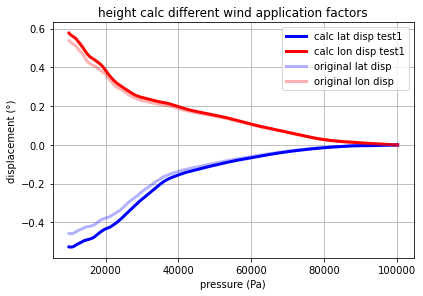

lat disp rmse:  0.041174360757169154
lon disp rmse:  0.02075349105467772
----------------
42.940000000000005 -78.72000000000001 19201201.0 110000.0


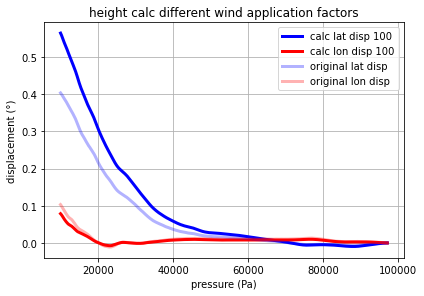

lat disp rmse:  0.0757194008015945
lon disp rmse:  0.00799416199286544


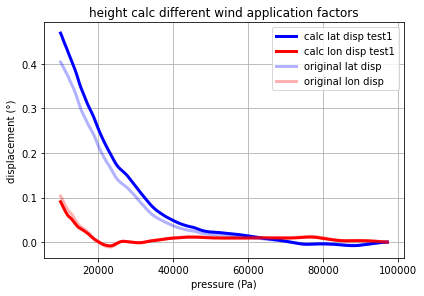

lat disp rmse:  0.03093333575874608
lon disp rmse:  0.00466881402992812
----------------
44.07 -103.21000000000001 19201201.0 110500.0


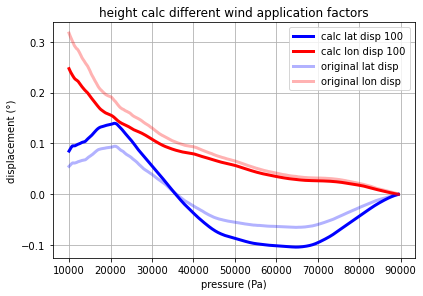

lat disp rmse:  0.03190260443993863
lon disp rmse:  0.03285120826437679


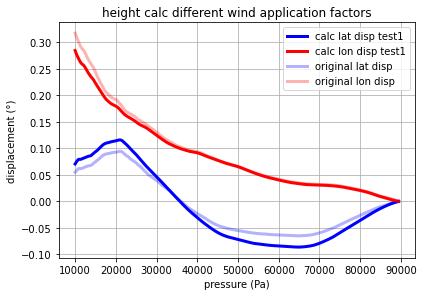

lat disp rmse:  0.016186231506361122
lon disp rmse:  0.013458885205344814
----------------
13.48 144.79000000000002 19201201.0 110400.0


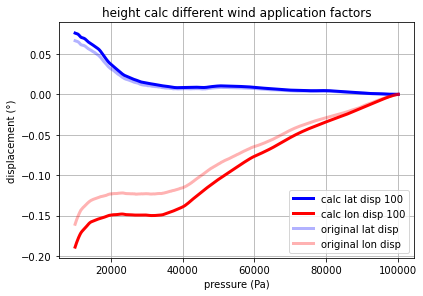

lat disp rmse:  0.0047284351790208325
lon disp rmse:  0.021853320472484273


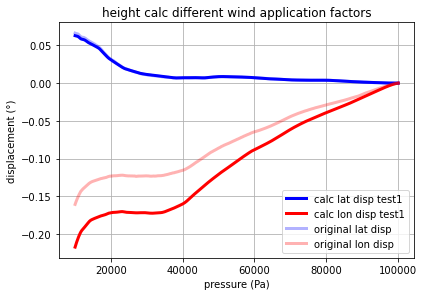

lat disp rmse:  0.0012959613115395019
lon disp rmse:  0.04103243907526657
----------------
39.57 -119.80000000000001 19201201.0 110000.0


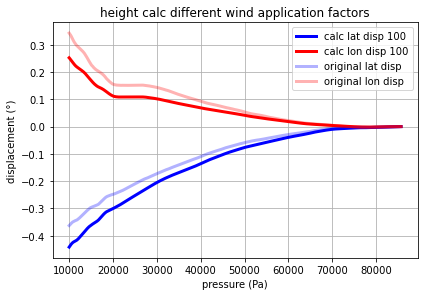

lat disp rmse:  0.041659761728201274
lon disp rmse:  0.04239708458093632


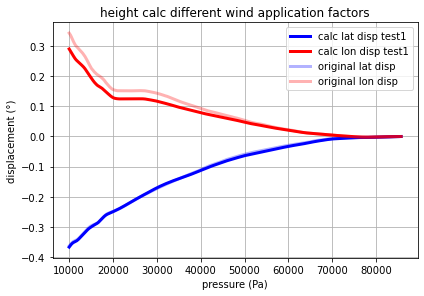

lat disp rmse:  0.002581394449426894
lon disp rmse:  0.025271908702437507
----------------
45.46 -98.41000000000001 19201201.0 110300.0


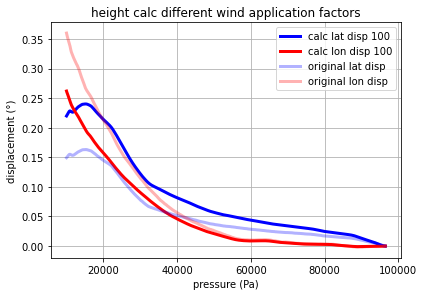

lat disp rmse:  0.04981590757753846
lon disp rmse:  0.045344849109311136


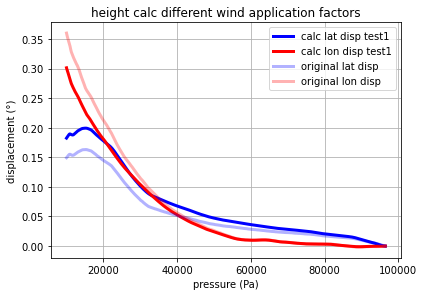

lat disp rmse:  0.024054855455284397
lon disp rmse:  0.026511306283246196
----------------
46.77 -100.76 19201201.0 110100.0


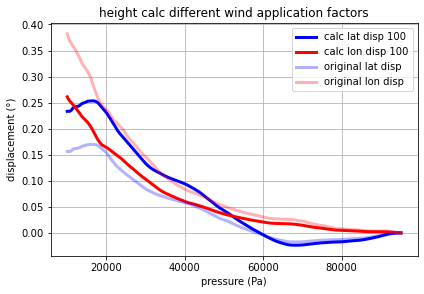

lat disp rmse:  0.05382751507216229
lon disp rmse:  0.0592669008756132


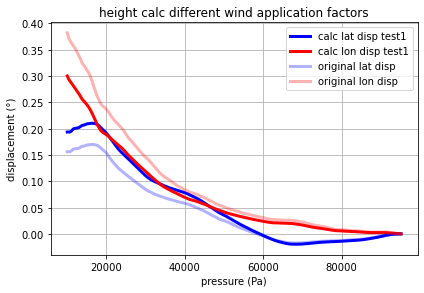

lat disp rmse:  0.02699615682563346
lon disp rmse:  0.039413216302926095
----------------
31.87 -106.7 19201201.0 110300.0


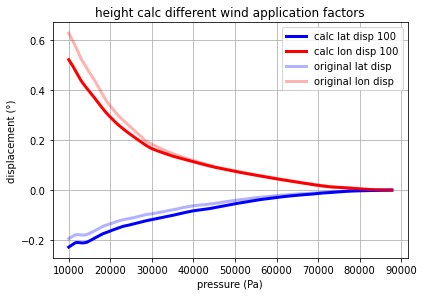

lat disp rmse:  0.023073981370137664
lon disp rmse:  0.04647339310745041


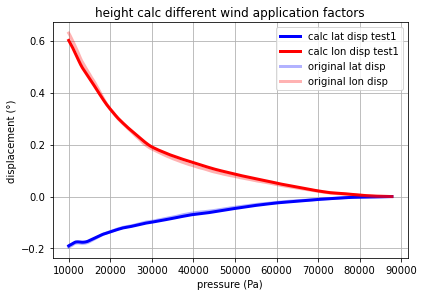

lat disp rmse:  0.0035605137374201236
lon disp rmse:  0.012300584784009607
----------------
35.040000000000006 -106.62 19201201.0 110200.0


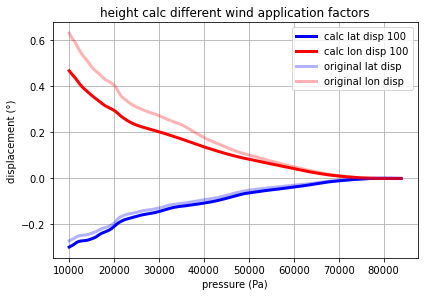

lat disp rmse:  0.016368290625240846
lon disp rmse:  0.08312930732298937


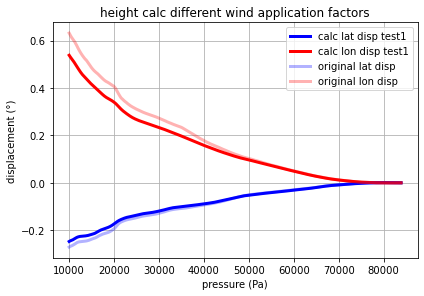

lat disp rmse:  0.012741306112302448
lon disp rmse:  0.04731054405878853
----------------
48.21 -106.63000000000001 19201201.0 110400.0


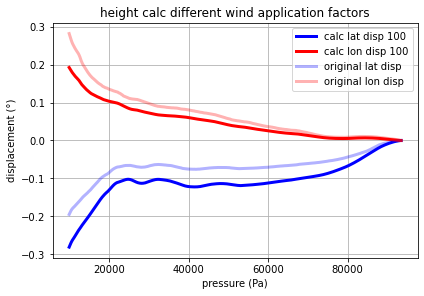

lat disp rmse:  0.04956374270629102
lon disp rmse:  0.03513922612308897


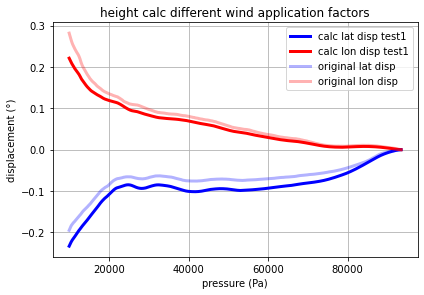

lat disp rmse:  0.02503435451736161
lon disp rmse:  0.02153006209583619
----------------
35.230000000000004 -111.82000000000001 19201201.0 110300.0


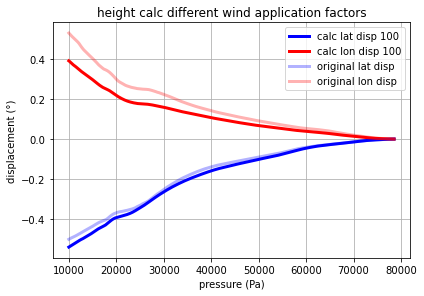

lat disp rmse:  0.020549456744069022
lon disp rmse:  0.07149830047939083


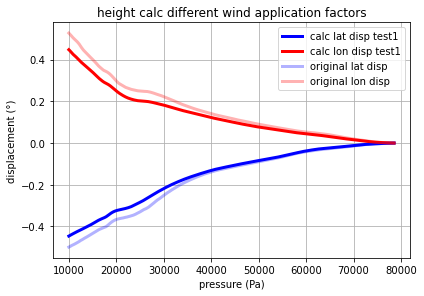

lat disp rmse:  0.03284735143007487
lon disp rmse:  0.04261744003955403
----------------
40.53 -80.22000000000001 19201201.0 111400.0


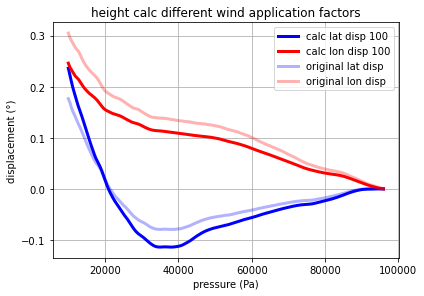

lat disp rmse:  0.023815208380716196
lon disp rmse:  0.033314950339192045


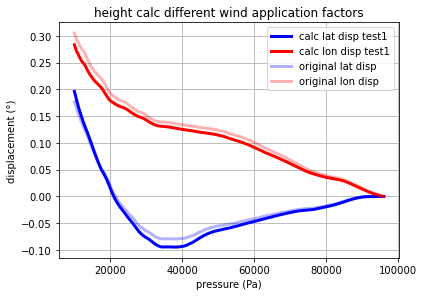

lat disp rmse:  0.008596944016419816
lon disp rmse:  0.012739565317223487
----------------
40.77 -111.96000000000001 19201201.0 110200.0


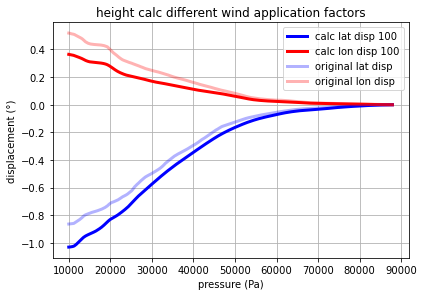

lat disp rmse:  0.09282175567191471
lon disp rmse:  0.08694512037912129


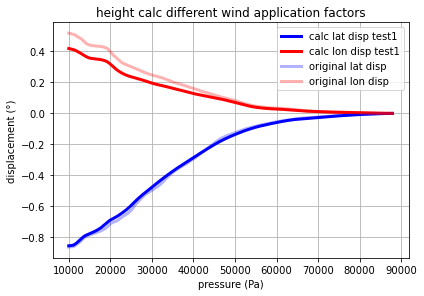

lat disp rmse:  0.0147063102113006
lon disp rmse:  0.05688885471975818
----------------
41.13 -100.7 19201201.0 110000.0


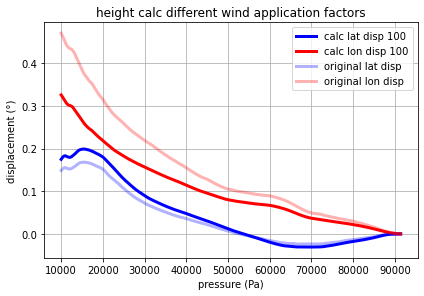

lat disp rmse:  0.01971659008853249
lon disp rmse:  0.07670805077624429


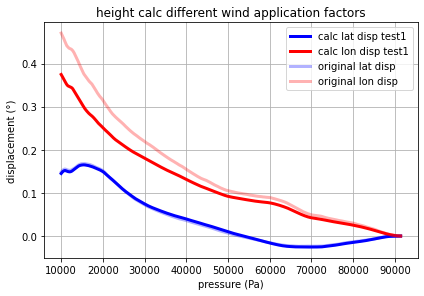

lat disp rmse:  0.002544766561787846
lon disp rmse:  0.05012947248781097
----------------
32.84 -97.30000000000001 19201201.0 110600.0


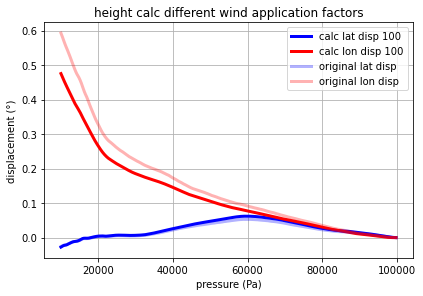

lat disp rmse:  0.004248358926036493
lon disp rmse:  0.055165125261221006


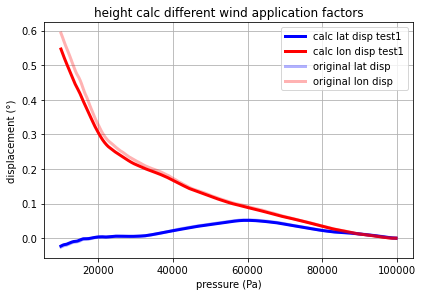

lat disp rmse:  0.0013196817093212181
lon disp rmse:  0.02102602080895543
----------------
not a valid station
40.150000000000006 -89.34 19201201.0 110300.0


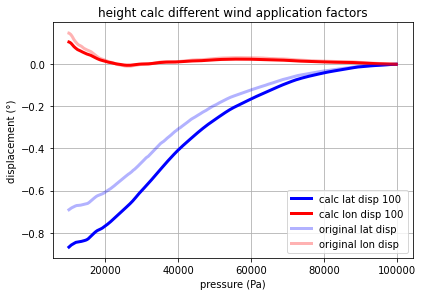

lat disp rmse:  0.12246425072789488
lon disp rmse:  0.01282830444270727


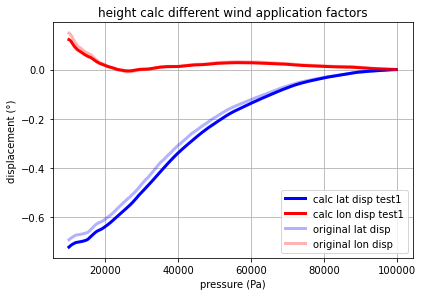

lat disp rmse:  0.026327562823460025
lon disp rmse:  0.007908550049471186
----------------
39.42 -83.82000000000001 19201201.0 110200.0


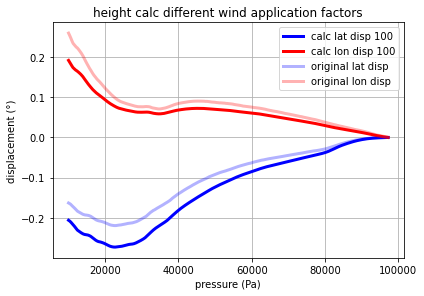

lat disp rmse:  0.041539298164454175
lon disp rmse:  0.029138623942095612


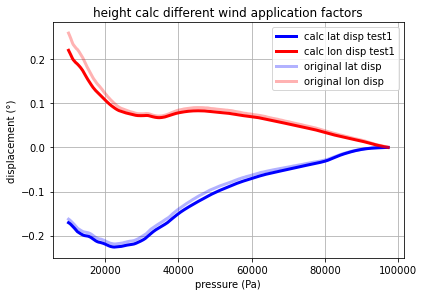

lat disp rmse:  0.007875207416292699
lon disp rmse:  0.01563264410158521
----------------
32.45 -93.84 19201201.0 110100.0


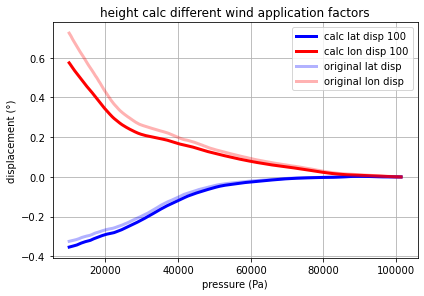

lat disp rmse:  0.018372054430433323
lon disp rmse:  0.0708896674565053


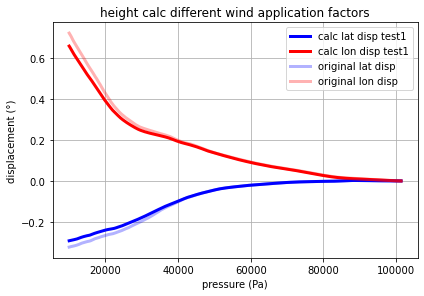

lat disp rmse:  0.018040479242722292
lon disp rmse:  0.02929608791077622
----------------
not a valid station
37.230000000000004 -93.4 19201201.0 110300.0


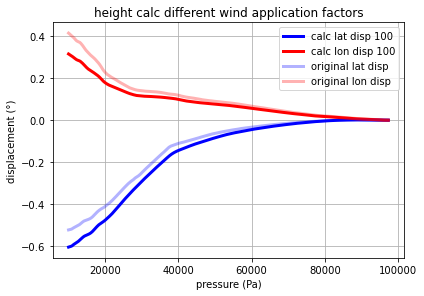

lat disp rmse:  0.04894332197680727
lon disp rmse:  0.0461673625758341


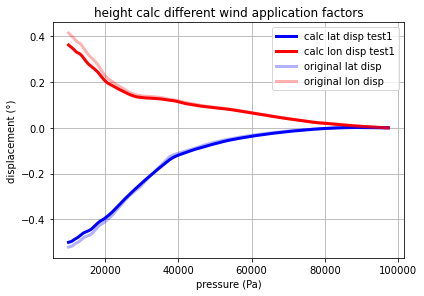

lat disp rmse:  0.012198476232069325
lon disp rmse:  0.022912591651402893
----------------
47.68000000000001 -117.63000000000001 19201201.0 110500.0


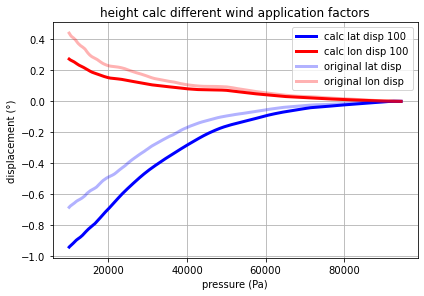

lat disp rmse:  0.15762060502914826
lon disp rmse:  0.07233142803651217


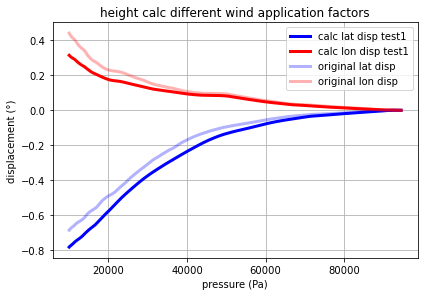

lat disp rmse:  0.06764133762476136
lon disp rmse:  0.052263679892166716
----------------
36.25 -86.56 19201201.0 110600.0


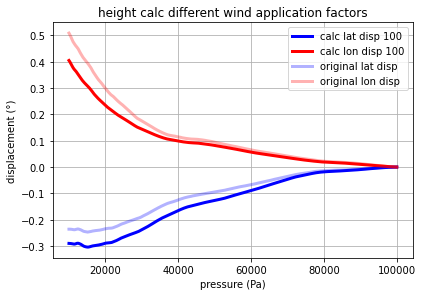

lat disp rmse:  0.04326270800175014
lon disp rmse:  0.051519215383981104


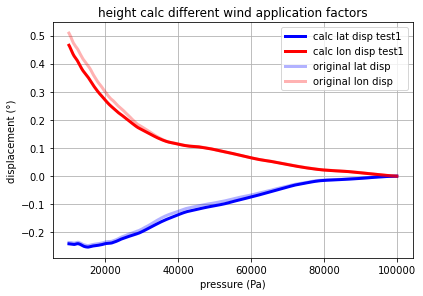

lat disp rmse:  0.007625503461047495
lon disp rmse:  0.022671387464122682
----------------
30.130000000000003 -93.22000000000001 19201201.0 110500.0


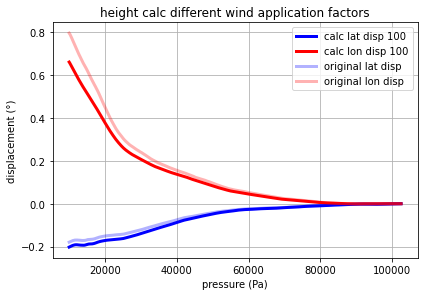

lat disp rmse:  0.015359710119247161
lon disp rmse:  0.06088016463940867


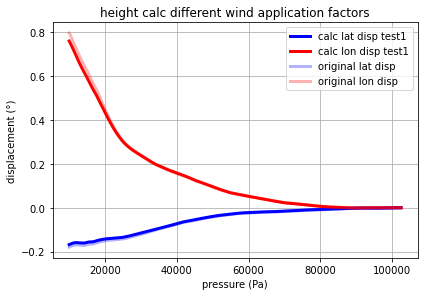

lat disp rmse:  0.00633657962298164
lon disp rmse:  0.01570454821420066
----------------
27.78 -97.51 19201201.0 110700.0


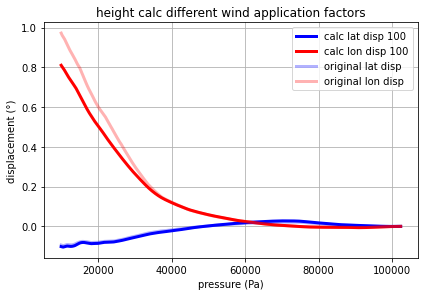

lat disp rmse:  0.005106386635544897
lon disp rmse:  0.07767243458567775


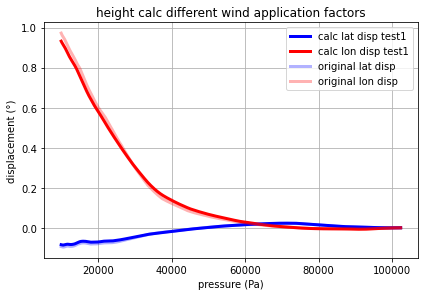

lat disp rmse:  0.005794726813743887
lon disp rmse:  0.02041852529842576
----------------
not a valid station
39.120000000000005 -108.53000000000002 19201201.0 111300.0


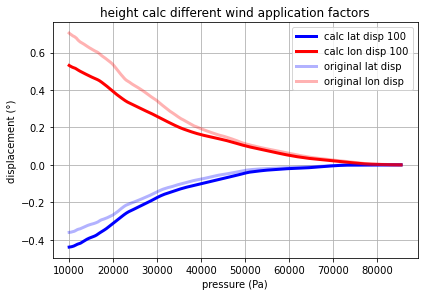

lat disp rmse:  0.04291584369244535
lon disp rmse:  0.09783204582042238


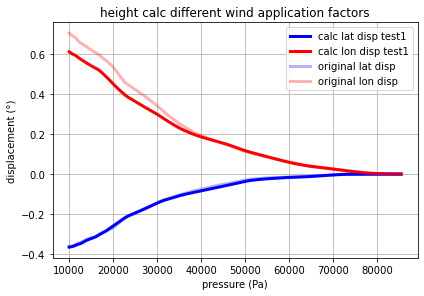

lat disp rmse:  0.00455601601151297
lon disp rmse:  0.05255554291278257
----------------


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, './out.bufr') #sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

# Testing

In [ ]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    old_rmse = 1
    older_rmse = 1
    fff = 1.0
    while True:
        alldata=''
        alldict=dict()

        bufrlist=[]
        tx=time.time()
    #     try:
        f = open(bufrfile)
        print(f)
        cnt = 0
        output = {}
        # loop over the messages in the file
        bc = 0


        rmse_sum_lat = []
        rmse_sum_lon = []
        rmse_sum_lat_1 = []
        rmse_sum_lon_1 = []
        rmse_sum_lat_2 = []
        rmse_sum_lon_2 = []

        while 1:
    #         try:
            # get handle for message
            bufr = codes_bufr_new_from_file(f)
            if bufr is None:
                break
            # we need to instruct ecCodes to expand all the descriptors
            # i.e. unpack the data section
            if codes_get_array(bufr,'dataSubCategory')[0]!=109:
                codes_release(bufr)
                continue
            codes_set(bufr, 'unpack', 1)
            # get all the timePeriods
            iterid = codes_bufr_keys_iterator_new(bufr)

            # loop over the keys
            #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
                ##print (codes_get_array(bufr,'dataSubCategory')[0])
                #codes_release(bufr)
                #continue
            hires=False
            while codes_bufr_keys_iterator_next(iterid):

                # print key name
                keyname = codes_bufr_keys_iterator_get_name(iterid)
    #             print(keyname,codes_get_array(bufr,keyname))
                #if keyname in ['#1#blockNumber','#1#stationNumber']:
                    #print (keyname,codes_get_array(bufr,keyname))
                if 'latitudeDisplacement' in keyname:
                    hires=True
            if not hires:
                codes_bufr_keys_iterator_delete(iterid)
                continue
            ## delete the key iterator
            codes_bufr_keys_iterator_delete(iterid)
            output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
            output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
            output['pressure'] = codes_get_array(bufr, "pressure")
            output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
            output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
            output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
            output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
            output['airTemperature'] = codes_get_array(bufr, "airTemperature")
            dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
            output['windDirection'] = codes_get_array(bufr, "windDirection")
            output['windSpeed'] = codes_get_array(bufr, "windSpeed")
            output['lat'] = codes_get(bufr, "latitude")
            output['lon'] = codes_get(bufr, "longitude")
            output['alt'] = float(codes_get(bufr, "heightOfStation"))
            output['blockNumber'] = codes_get(bufr, "blockNumber")
            output['stationNumber'] = codes_get(bufr, "stationNumber")
            try:
                data = pd.DataFrame.from_dict(output)
                cont = True
            except:
                cont = False
            if cont:
                if data.pressure[0] < 40000:
                    u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
                    data['u'] = u
                    v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
                    data['v'] = v
                    data = data[data.airTemperature < 350]
                    data = data[data.airTemperature > 180]

                    true_latd = data.latitudeDisplacement
                    true_lond = data.longitudeDisplacement


                    lat_displacement_100, lon_displacement_100 = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature), u_factor=0.83, v_factor = fff)

                    rmse_sum_lat.append(np.sqrt(np.nanmean((np.array(lat_displacement_100)-true_latd)**2)))
                    rmse_sum_lon.append(np.sqrt(np.nanmean((np.array(lon_displacement_100)-true_lond)**2)))

                    bc += 1
    #         except:
    #             pass
            if bc > 100: #if bc > 30:
                break
        print(fff)
        print('data set 0: ',np.median(rmse_sum_lat), np.median(rmse_sum_lon))
        if (old_rmse < np.median(rmse_sum_lon)) and (older_rmse < np.median(rmse_sum_lon)):
            break
        else:
            older_rmse = old_rmse
            old_rmse = np.median(rmse_sum_lon)
            fff += 0.01
        
    return output #, true_sum_lon, true_sum_lat, rmse_sum_lon, rmse_sum_lat, rmse_sum_lon_1, rmse_sum_lat_1, rmse_sum_lon_2, rmse_sum_lat_2


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()

In [ ]:
0.83
data set 0:  0.00991811611498853 0.07403057705528218

1.15
data set 0:  0.009949274964413392 0.03332059666137682

# Height testing

In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [ ]:
def par_read_bufr_stn_nofeedback(varno,bufrfile):
    alldata=''
    alldict=dict()

    bufrlist=[]
    tx=time.time()
#     try:
    f = open(bufrfile)
    print(f)
    cnt = 0
    output = {}
    # loop over the messages in the file
    while 1:
        # get handle for message
        bufr = codes_bufr_new_from_file(f)
        if bufr is None:
            break
        # we need to instruct ecCodes to expand all the descriptors
        # i.e. unpack the data section
        if codes_get_array(bufr,'dataSubCategory')[0]!=109:
            codes_release(bufr)
            continue
        codes_set(bufr, 'unpack', 1)
        # get all the timePeriods
        iterid = codes_bufr_keys_iterator_new(bufr)

        # loop over the keys
        #if codes_get_array(bufr,'dataSubCategory')[0]!=101:
            ##print (codes_get_array(bufr,'dataSubCategory')[0])
            #codes_release(bufr)
            #continue
        hires=False
        while codes_bufr_keys_iterator_next(iterid):

            # print key name
            keyname = codes_bufr_keys_iterator_get_name(iterid)
#             print(keyname,codes_get_array(bufr,keyname))
            #if keyname in ['#1#blockNumber','#1#stationNumber']:
                #print (keyname,codes_get_array(bufr,keyname))
            if 'latitudeDisplacement' in keyname:
                hires=True
        if not hires:
            codes_bufr_keys_iterator_delete(iterid)
            continue
        ## delete the key iterator
        codes_bufr_keys_iterator_delete(iterid)
        output['datum'] = float('19'+codes_get_array(bufr, "typicalDate")[0][2:])
        output['timePeriod'] = float(codes_get_array(bufr, "typicalTime")[0])
        output['pressure'] = codes_get_array(bufr, "pressure")
        output['extendedVerticalSoundingSignificance'] = codes_get_array(bufr, "extendedVerticalSoundingSignificance")
        output['geopotentialHeight'] = codes_get_array(bufr, "nonCoordinateGeopotentialHeight")
        output['latitudeDisplacement'] = codes_get_array(bufr, "latitudeDisplacement")
        output['longitudeDisplacement'] = codes_get_array(bufr, "longitudeDisplacement")
        output['airTemperature'] = codes_get_array(bufr, "airTemperature")
        dewpointTemperature = codes_get_array(bufr, "dewpointTemperature")
        output['windDirection'] = codes_get_array(bufr, "windDirection")
        output['windSpeed'] = codes_get_array(bufr, "windSpeed")
        output['lat'] = codes_get(bufr, "latitude")
        output['lon'] = codes_get(bufr, "longitude")
        output['alt'] = float(codes_get(bufr, "heightOfStation"))
        output['blockNumber'] = codes_get(bufr, "blockNumber")
        output['stationNumber'] = codes_get(bufr, "stationNumber")
        return output


In [ ]:
ipath=os.path.expanduser('~leo/ectrans/')
sodblist=glob.glob(ipath+'era5.bufr.202012')
sodblist.sort(key=os.path.getsize)
out = par_read_bufr_stn_nofeedback(111, sodblist[0])
# #list(map(func,  idx2))
# func = partial(par_read_bufr_stn_nofeedback,111)
# list(map(func,sodblist))

# # exit()


In [ ]:
data = pd.DataFrame.from_dict(out)
u = data.windSpeed * numpy.cos(np.radians(data.windDirection))
data['u'] = u
v = data.windSpeed * numpy.sin(np.radians(data.windDirection))
data['v'] = v
data = data[data.airTemperature < 350]
data = data[data.airTemperature > 180]
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
data


---
---

In [ ]:
reduced = reduced.reset_index()

In [ ]:
t = reduced.airTemperature
p = reduced.pressure
for i in range(len(reduced)):
    if i != 0:
        # from: https://www.cesm.ucar.edu/models/cesm1.1/cesm/cesmBbrowser/html_code/cam/tropopause.F90.html
        SHR_CONST_AVOGAD  = 6.02214e26
        SHR_CONST_BOLTZ   = 1.38065e-23
        SHR_CONST_MWDAIR  = 28.966
        SHR_CONST_RGAS    = SHR_CONST_AVOGAD*SHR_CONST_BOLTZ
        SHR_CONST_RDAIR   = SHR_CONST_RGAS/SHR_CONST_MWDAIR
        rair = SHR_CONST_RDAIR
        
        SHR_CONST_G       = 9.80616
        gravit = SHR_CONST_G
        
        SHR_CONST_CPDAIR  = 1.00464e3
        cappa        = (SHR_CONST_RGAS/SHR_CONST_MWDAIR)/SHR_CONST_CPDAIR
        cnst_kap = cappa

        cnst_faktor = -gravit/rair
        cnst_ka1    = cnst_kap - 1.

        # dt/dz
        pmk= .5 * (p[i-1]**cnst_kap+p[i]**cnst_kap)
        pm = pmk**(1/cnst_kap)               
        a = (t[i-1]-t[i])/(p[i-1]**cnst_kap-p[i]**cnst_kap)
        b = t[i]-(a*p[i]**cnst_kap)
        tm = a * pmk + b               
        dtdp = a * cnst_kap * (pm**cnst_ka1)
        dtdz = cnst_faktor*dtdp*pm/tm
        print(dtdz)
        print(-9.80665/287.053* (reduced.airTemperature[i-1]-reduced.airTemperature[i])/((reduced.pressure[i-1] - (reduced.pressure[i]) * reduced.pressure[i]/reduced.airTemperature[i])))
        print((3300 / 9.8 / 1000 * 1e9) / (reduced.airTemperature[i-1]-reduced.airTemperature[i])/((reduced.pressure[i-1] - reduced.pressure[i])))
        print((reduced.airTemperature[i-1]-reduced.airTemperature[i])/(np.log(reduced.pressure[i-1] - reduced.pressure[i])))
        print((reduced.airTemperature[i-1]-reduced.airTemperature[i])/(np.log(reduced.pressure[i-1]) - np.log(reduced.pressure[i])))
        print((reduced.airTemperature[i]-reduced.airTemperature[i-1])/(reduced.geopotentialHeight[i] - reduced.geopotentialHeight[i-1]))
        print('---')
 # /1000? K/m -> K/km

In [ ]:
calc_height(np.array(data.airTemperature), np.array(data.pressure), 'pthf')[-1]

In [ ]:
data = data.reset_index()

In [ ]:
z= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=False)
z2= calc_height(data.airTemperature, data.pressure, variant='pthf', jump=True)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

# plt.plot(data.pressure,z,label='z')
# plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure[:-50],np.array(z[:-50])-np.array(z2[:-50]),label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
data2 = data[np.array(z) > 20000000]

In [ ]:
data2

In [ ]:
data[data.geopotentialHeight < 18479]

In [ ]:
data2 = data2.reset_index()

In [ ]:
for i in range(len(data2)):
    if i != 0:
        print((np.log(data2.pressure[i-1] - data2.pressure[i])))
        print((np.log(data2.pressure[i-1]) - np.log(data2.pressure[i])))
        print((np.log(data2.pressure[i]) - np.log(data2.pressure[i-1])))

        print((data2.geopotentialHeight[i-1] - data2.geopotentialHeight[i]))
        print('---')
 # /1000? K/m -> K/km

In [ ]:
z[-16]

In [ ]:
z = calc_height(data.airTemperature, data.pressure, 'pthf', jump = False)
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure), 'pthf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(reduced.pressure,reduced.geopotentialHeight,label='geop.h.')
plt.plot(reduced.pressure,reduced.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
z = calc_height(data.airTemperature, data.pressure, 'ithf')
# vec_expint = numpy.vectorize(expint)
# z = vec_expint(z)

plt.plot(data.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.plot(data.pressure,data.geopotentialHeight-z,label='diff')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
z = calc_height(np.array(reduced.airTemperature), np.array(reduced.pressure))
vec_expint = numpy.vectorize(expint)
z = vec_expint(z)

plt.plot(reduced.pressure,z,label='z')
plt.plot(data.pressure,data.geopotentialHeight,label='geop.h.')
plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

---
---

In [ ]:
lat = data.lat.iloc[0]
lon = data.lon.iloc[0]
print(lat, lon)
print(transport(lat, lon, [111,-111],[0,0]))

print(transport(lat, lon, 100,0))
print(transport(lat, lon, -100,0))

print(transport(lat, lon, 0,100))
print(transport(lat, lon, 0,-100))

---
---

In [ ]:
lat_displacement, lon_displacement = trajectory(np.array(data.lat)[0], np.array(data.lon)[0], np.array(data.u), np.array(data.v), np.array(data.pressure), np.array(data.airTemperature))

In [ ]:
plt.plot(data.pressure,np.array(lat_displacement),label='calc lat disp')
plt.plot(data.pressure,np.array(lon_displacement),label='calc lon disp')
plt.plot(data.pressure,data.latitudeDisplacement,label='original lat disp')
plt.plot(data.pressure,data.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()

In [ ]:
reduced = data[numpy.isin(data.pressure, [100000,85000,75000,50000,40000,30000,20000,10000,5000,3000,1000])]
lat_displacement, lon_displacement = trajectory(np.array(reduced.lat)[0], np.array(reduced.lon)[0], np.array(reduced.u), np.array(reduced.v), np.array(reduced.pressure), np.array(reduced.airTemperature))

In [ ]:
plt.plot(reduced.pressure,lat_displacement,label='calc lat disp')
plt.plot(reduced.pressure,lon_displacement,label='calc lon disp')
plt.plot(reduced.pressure,reduced.latitudeDisplacement,label='original lat disp')
plt.plot(reduced.pressure,reduced.longitudeDisplacement,label='original lon disp')

plt.title('height calc')
plt.legend()
plt.grid()
plt.show()